# Random forest for HAMBI data 

In [1]:
from sklearn.ensemble import RandomForestClassifier
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from datetime import datetime
import joblib

seed = 98


In [2]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'

In [3]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['Domain to species'].unique())
    print(f"before filtering number of classes {len(data['Domain to species'].value_counts())}")    
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"after filtering number of classes {len(data_filtered['Domain to species'].value_counts())}")
    classes_after = set(data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    """Filter out the contigs that have less than n samples in the given column.
    
    Parameters:
    - data (pd.DataFrame): Data frame with the data.
    - column_name (str): Column name to filter out.
    - n (int): Minimum number of samples.
    """
    print(f"before filtering number of classes {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"after filtering number of classes {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model: RandomForestClassifier, title: str, output_dir: str, target: str):
    """Plot the confusion matrix for the given true and predicted values.
    
    Parameters:
    - y_true (pd.Series): True labels.
    - y_pred (pd.Series): Predicted labels.
    - model (RandomForestClassifier): Trained model.
    - title (str): Title of the plot.
    - output_dir (str): Path to the output directory where the plot will be saved.
    - target (str): Target column.
    """

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(50, 50))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True, annot_kws={"size": 30})
    if target == 'Domain to species':
        plt.xticks(rotation=90, fontsize=20)
        plt.yticks(rotation=0, fontsize=20)
    else:
        plt.xticks(rotation=90, fontsize=40)
        plt.yticks(rotation=0, fontsize=40)
    if target == 'Domain to species':
        plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=40)
    else:
        plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}', fontsize=50)

    plt.xlabel('Predicted Labels', fontsize=35)
    plt.ylabel('True Labels', fontsize=35)
    plt.subplots_adjust(top=0.85)

    plt.tight_layout()
    title = title.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{title}.png'))
    plt.savefig(os.path.join(output_dir, f'{title}.jpg'))
    plt.close()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, output_dir: str, target: str):
    """Plot the distribution of the train and test sets.
    
    Parameters:
    - y_train (pd.Series): True labels of the train set.
    - y_test (pd.Series): True labels of the test set.
    - output_dir (str): Path to the output directory.
    """
    print("Plotting the distribution")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    print("Number of samples in each species in the train set:")
    print(train_species_counts)
    print("\nNumber of samples in each species in the test set:")
    print(test_species_counts)
    num_classes = len(set(y_train.unique()).union(set(y_test.unique())))
    
    width = max(12, num_classes * 0.6)
    height = max(8, num_classes * 0.8)
    
    plt.figure(figsize=(width, height))
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90, fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)

    target = target.replace(' ', '_')
    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.png'), bbox_inches='tight')

    plt.savefig(os.path.join(output_dir, f'{target}_train_test_distribution.jpg'))
    plt.show()

    plt.close()

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target:str, top_n: int = 30, output_dir: str = None):
    """Plot the feature importance of the model.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    - output_dir (str): Path to the output directory.
    """

    plt.figure(figsize=(20, 10))
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    plt.bar(range(top_n), importances[top_indices], align='center', color='skyblue')
    plt.xticks(range(top_n), X.columns[top_indices], rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of {top_n} features with target {target}", fontsize=20)
    plt.tight_layout()
    output_name = f'{target.replace(" ", "_")}_feature_importance.png'
    plt.savefig(os.path.join(output_dir, output_name))
    plt.savefig(os.path.join(output_dir, output_name.replace('.png', '.jpg')))
    plt.close()

def train_test_model(df: pd.DataFrame, output_folder: str, target: str):
    """Train and test the random forest classifier.

    Parameters:
    - df (pd.DataFrame): Data frame with the data.
    - output_folder (str): Path to the output directory to save the results for the model plots
    - target (str): Target column.
    """
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X_DS = filtered_data.iloc[:, :492] 
    y_DS = filtered_data[target]

    X_train_DS, X_test_DS, y_train_DS, y_test_DS = train_test_split(X_DS, y_DS, test_size=0.2, random_state=seed, stratify=y_DS)
    plot_train_test_distribution(y_train_DS, y_test_DS, output_folder, target)
    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train_DS, y_train_DS)

    y_train_pred_DS = model.predict(X_train_DS)
    y_test_pred_DS = model.predict(X_test_DS)

    plot_confusion_matrix(y_train_DS, y_train_pred_DS, model, f'Train Set with target {target}', output_folder, target)
    plot_confusion_matrix(y_test_DS, y_test_pred_DS, model, f'Test Set with target {target}', output_folder, target)

    plot_feature_importance(model, X_DS, target, 30, output_folder)

    metrics = pd.DataFrame({
            'Accuracy Train': [accuracy_score(y_train_DS, y_train_pred_DS)],
            'Accuracy Test': [accuracy_score(y_test_DS, y_test_pred_DS)],
            'Precision': [precision_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'Recall': [recall_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)],
            'F1 Score': [f1_score(y_test_DS, y_test_pred_DS, average='weighted', zero_division=0)]
        })
    
    metrics.to_csv(os.path.join(output_folder, f'{target.replace(" ", "_")}_metrics.tsv'), sep='\t')
    print(f"Metrics for target {target}")
    print(metrics)

    if accuracy_score(y_test_DS, y_test_pred_DS) > 0.7:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
        model_file_path = os.path.join(output_folder, f'{target.replace(" ", "_")}_model.joblib')
        print(f"Saving the model to {model_file_path}")
        joblib.dump(model, model_file_path)
    else:
        print(f"Model trained with accuracy: {accuracy_score(y_test_DS, y_test_pred_DS)}")
    return y_test_DS, y_test_pred_DS
    

In [4]:
data = pd.read_csv("/scratch/project_2006608/Methylation/HAMBI_data/merged_data.tsv", sep="\t", index_col=0, header=0,low_memory=False)

In [5]:
data.head()

-20_A_m4C  -19_A_m4C  -18_A_m4C  -17_A_m4C  \
0                                                                             
bcAd1023T--bcAd1023T_ptg000028l   0.000000   0.000000   0.000000   0.000000   
bcAd1023T--bcAd1023T_ptg000139l   0.000000   0.000000   0.000000   0.000000   
bcAd1023T--bcAd1023T_ptg000005c   0.002806  -0.008088  -0.020686   0.001876   
bcAd1023T--bcAd1023T_ptg000084l   0.000000   0.000000   0.000000   0.000000   
bcAd1023T--bcAd1023T_ptg000212l   0.000000   0.000000   0.000000   0.000000   

                                 -16_A_m4C  -15_A_m4C  -14_A_m4C  -13_A_m4C  \
0                                                                             
bcAd1023T--bcAd1023T_ptg000028l   0.000000   0.000000    0.00000    0.00000   
bcAd1023T--bcAd1023T_ptg000139l   0.000000   0.000000    0.00000    0.00000   
bcAd1023T--bcAd1023T_ptg000005c   0.002186  -0.022589   -0.00434   -0.03184   
bcAd1023T--bcAd1023T_ptg000084l   0.000000   0.000000    0.00000    0.00000   
bcAd1023T--bcAd1023T_ptg000212l   0.000000   0.000000    0.00000    0.00000   

                                 -12_A_m4C  -11_A_m4C  ...  \
0                                                      ...   
bcAd1023T--bcAd1023T_ptg000028l   0.000000   0.000000  ...   
bcAd1023T--bcAd1023T_ptg000139l   0.000000   0.000000  ...   
bcAd1023T--bcAd1023T_ptg000005c  -0.078417   0.034193  ...   
bcAd1023T--bcAd1023T_ptg000084l   0.000000   0.000000  ...   
bcAd1023T--bcAd1023T_ptg000212l   0.000000   0.000000  ...   

                                                             s     element  \
0                                                                            
bcAd1023T--bcAd1023T_ptg000028l       Comamonas_testosteroni_C  chromosome   
bcAd1023T--bcAd1023T_ptg000139l                            NaN         NaN   
bcAd1023T--bcAd1023T_ptg000005c  Sphingobacterium_spiritivorum  chromosome   
bcAd1023T--bcAd1023T_ptg000084l       Comamonas_testosteroni_C  chromosome   
bcAd1023T--bcAd1023T_ptg000212l   Stenotrophomonas_maltophilia  chromosome   

                                        str  \
0                                             
bcAd1023T--bcAd1023T_ptg000028l  HAMBI_0403   
bcAd1023T--bcAd1023T_ptg000139l         NaN   
bcAd1023T--bcAd1023T_ptg000005c  HAMBI_1896   
bcAd1023T--bcAd1023T_ptg000084l  HAMBI_0403   
bcAd1023T--bcAd1023T_ptg000212l  HAMBI_2659   

                                                                               All  \
0                                                                                    
bcAd1023T--bcAd1023T_ptg000028l  Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...   
bcAd1023T--bcAd1023T_ptg000139l                                                NaN   
bcAd1023T--bcAd1023T_ptg000005c  Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...   
bcAd1023T--bcAd1023T_ptg000084l  Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...   
bcAd1023T--bcAd1023T_ptg000212l  Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...   

                                                                 Domain to species  \
0                                                                                    
bcAd1023T--bcAd1023T_ptg000028l  Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...   
bcAd1023T--bcAd1023T_ptg000139l                                                NaN   
bcAd1023T--bcAd1023T_ptg000005c  Bacteria_Bacteroidota_Bacteroidia_Sphingobacte...   
bcAd1023T--bcAd1023T_ptg000084l  Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...   
bcAd1023T--bcAd1023T_ptg000212l  Bacteria_Pseudomonadota_Gammaproteobacteria_Xa...   

                                                                   Domain to genus  \
0                                                                                    
bcAd1023T--bcAd1023T_ptg000028l  Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...   
bcAd1023T--bcAd1023T_ptg000139l                                                NaN   
bcAd1023T--bcAd1023T_ptg000005c  Bacteria_Bacteroidota_Bacteroi

In [6]:
len(data['Domain to species'].value_counts())

15

In [7]:
data['Domain to species'].value_counts()

Domain to species
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Citrobacter_Citrobacter_B_koseri              253
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales_Beijerinckiaceae_Microvirga_Microvirga_lotononidis                    157
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_C_Bordetella_Bordetella_avium                    154
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_B_Comamonas_Comamonas_testosteroni_C             147
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_Cupriavidus_Cupriavidus_oxalaticus               116
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales_Pseudomonadaceae_Pseudomonas_E_Pseudomonas_E_putida               111
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Morganella_Morganella_morganii                 87
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhodobacterales_Rhodobactera

# Random forest classifier 

Training the model with target: Domain to species
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 15
after filtering number of classes 11
Plotting the distribution
Number of samples in each species in the train set:
Domain to species
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Citrobacter_Citrobacter_B_koseri       186
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales_Beijerinckiaceae_Microvirga_Microvirga_lotononidis              78
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_B_Comamonas_Comamonas_testosteroni_C       77
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_C_Bordetella_Bordetella_avium              76
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales_Pseudomonadaceae_Pseudomonas_E_Pseudomonas_E_putida         74
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhodobacterales_Rhodob

/tmp/markkan5/26831858/ipykernel_3755835/4231959101.py:104: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


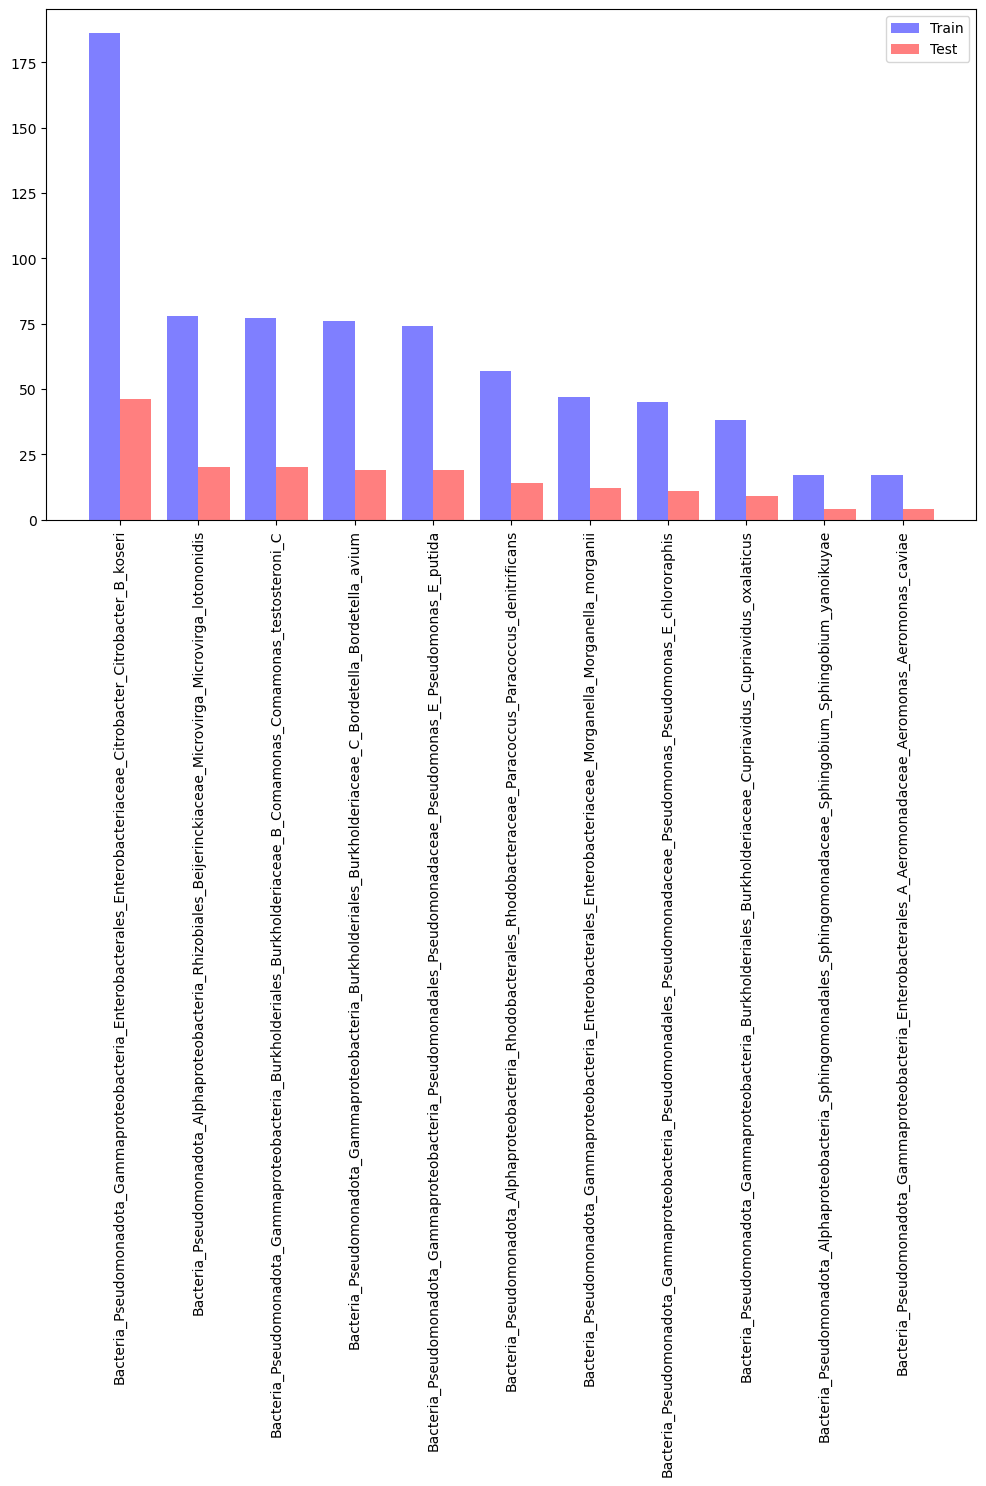

Metrics for target Domain to species
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151
Model trained with accuracy: 0.8707865168539326
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_species_model.joblib


In [8]:
output_folder = '/scratch/project_2006608/Methylation/notebooks/RF_HAMBI'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

y_test_DS, y_test_pred_DS = train_test_model(data, output_folder, 'Domain to species')

In [9]:
len(np.unique(y_test_pred_DS))


11

Training the model with target: Domain to genus
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 15
after filtering number of classes 11
Plotting the distribution
Number of samples in each species in the train set:
Domain to genus
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Citrobacter    186
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales_Beijerinckiaceae_Microvirga             78
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_B_Comamonas        77
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_C_Bordetella       76
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales_Pseudomonadaceae_Pseudomonas_E      74
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhodobacterales_Rhodobacteraceae_Paracoccus         57
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae_Morganella 

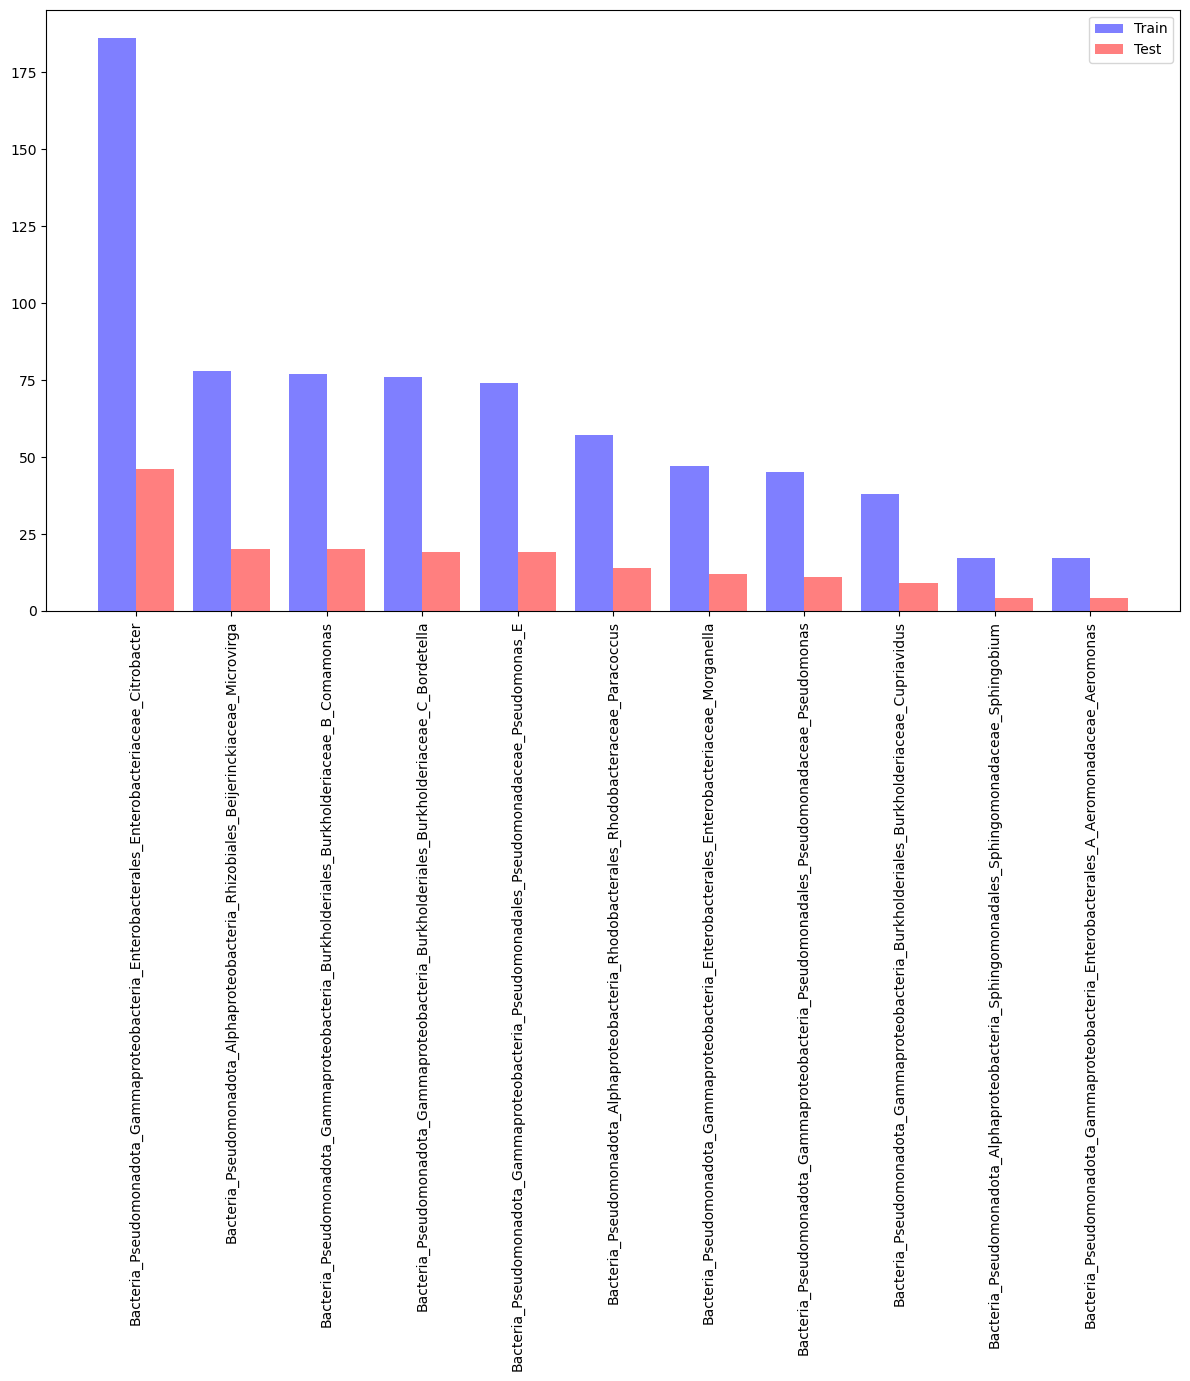

Metrics for target Domain to genus
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.848315   0.824003  0.848315  0.827039
Model trained with accuracy: 0.848314606741573
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_genus_model.joblib


(0
 bcAd1023T--bcAd1023T_ptg000249l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
 bcAd1063T--bcAd1063T_ptg000314l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1039T--bcAd1039T_ptg000177l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1023T--bcAd1023T_ptg000081l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1039T--bcAd1039T_ptg000514l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
                                                          ...                        
 bcAd1037T--bcAd1037T_ptg000068l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1063T--bcAd1063T_ptg000036l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1063T--bcAd1063T_ptg000217l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1039T--bcAd1039T_ptg000693l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1063T--bcAd1063T_ptg000362l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 Name: Domain to genus, Length: 178, dtype: object,

In [10]:
train_test_model(data, output_folder, 'Domain to genus')

Training the model with target: Domain to family
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 12
after filtering number of classes 9
Plotting the distribution
Number of samples in each species in the train set:
Domain to family
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_Enterobacteriaceae    234
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales_Pseudomonadaceae       119
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales_Beijerinckiaceae            78
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_B      77
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae_C      76
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhodobacterales_Rhodobacteraceae        57
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales_Burkholderiaceae        38
Bacteria_Pseudomonadota_Alphaproteobacteria_Sphingomonadales_Sphingomonadac

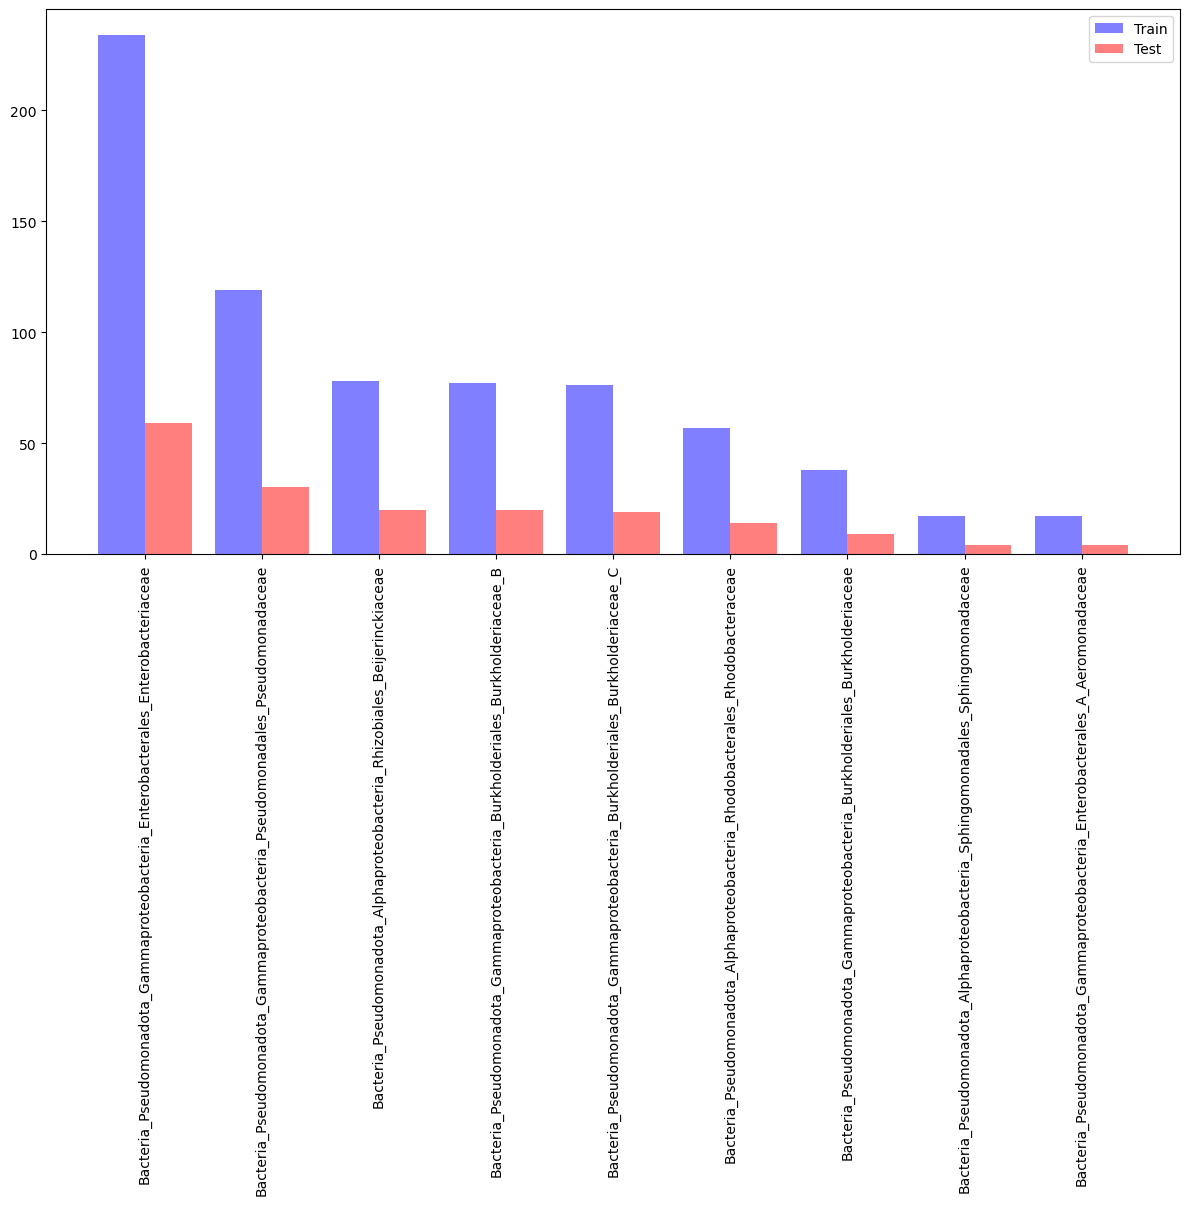

Metrics for target Domain to family
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.893855    0.83331  0.893855  0.861783
Model trained with accuracy: 0.8938547486033519
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_family_model.joblib


(0
 bcAd1023T--bcAd1023T_ptg000252l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
 bcAd1039T--bcAd1039T_ptg000558l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1063T--bcAd1063T_ptg000131l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1039T--bcAd1039T_ptg000377l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1023T--bcAd1023T_ptg000222l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
                                                          ...                        
 bcAd1037T--bcAd1037T_ptg000072l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1063T--bcAd1063T_ptg000041l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1039T--bcAd1039T_ptg000060l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1063T--bcAd1063T_ptg000248l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1037T--bcAd1037T_ptg000328l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 Name: Domain to family, Length: 179, dtype: object

In [11]:
train_test_model(data, output_folder, 'Domain to family')

Training the model with target: Domain to order
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 9
after filtering number of classes 7
Plotting the distribution
Number of samples in each species in the train set:
Domain to order
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales      234
Bacteria_Pseudomonadota_Gammaproteobacteria_Burkholderiales       191
Bacteria_Pseudomonadota_Gammaproteobacteria_Pseudomonadales       119
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhizobiales            82
Bacteria_Pseudomonadota_Alphaproteobacteria_Rhodobacterales        57
Bacteria_Pseudomonadota_Alphaproteobacteria_Sphingomonadales       17
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales_A     17
Name: count, dtype: int64

Number of samples in each species in the test set:
Domain to order
Bacteria_Pseudomonadota_Gammaproteobacteria_Enterobacterales      59
Bacteria_Pseudomonadota_Gammaprote

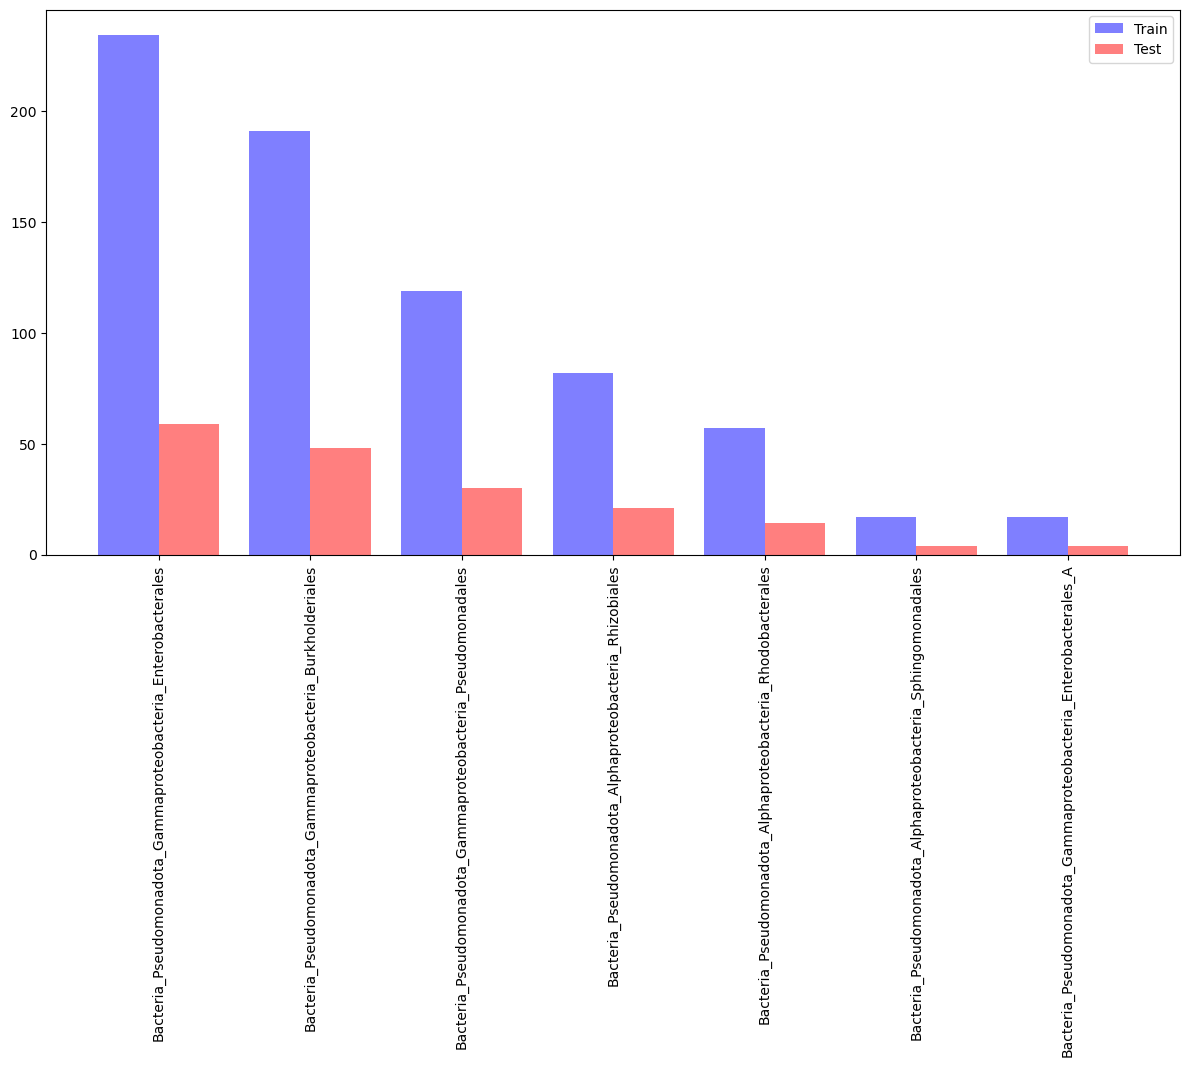

Metrics for target Domain to order
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.905556   0.914272  0.905556  0.897663
Model trained with accuracy: 0.9055555555555556
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_order_model.joblib


(0
 bcAd1039T--bcAd1039T_ptg000622l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
 bcAd1039T--bcAd1039T_ptg000561l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
 bcAd1023T--bcAd1023T_ptg000268l    Bacteria_Pseudomonadota_Gammaproteobacteria_Ps...
 bcAd1039T--bcAd1039T_ptg000582l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1037T--bcAd1037T_ptg000069l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
                                                          ...                        
 bcAd1039T--bcAd1039T_ptg000302l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1039T--bcAd1039T_ptg000377l    Bacteria_Pseudomonadota_Gammaproteobacteria_Bu...
 bcAd1037T--bcAd1037T_ptg000093l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1046T--bcAd1046T_ptg000046c    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 bcAd1039T--bcAd1039T_ptg000175l    Bacteria_Pseudomonadota_Gammaproteobacteria_En...
 Name: Domain to order, Length: 180, dtype: object,

In [12]:
train_test_model(data, output_folder, 'Domain to order')

Training the model with target: Domain to class
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 3
after filtering number of classes 2
Plotting the distribution
Number of samples in each species in the train set:
Domain to class
Bacteria_Pseudomonadota_Gammaproteobacteria    569
Bacteria_Pseudomonadota_Alphaproteobacteria    156
Name: count, dtype: int64

Number of samples in each species in the test set:
Domain to class
Bacteria_Pseudomonadota_Gammaproteobacteria    143
Bacteria_Pseudomonadota_Alphaproteobacteria     39
Name: count, dtype: int64


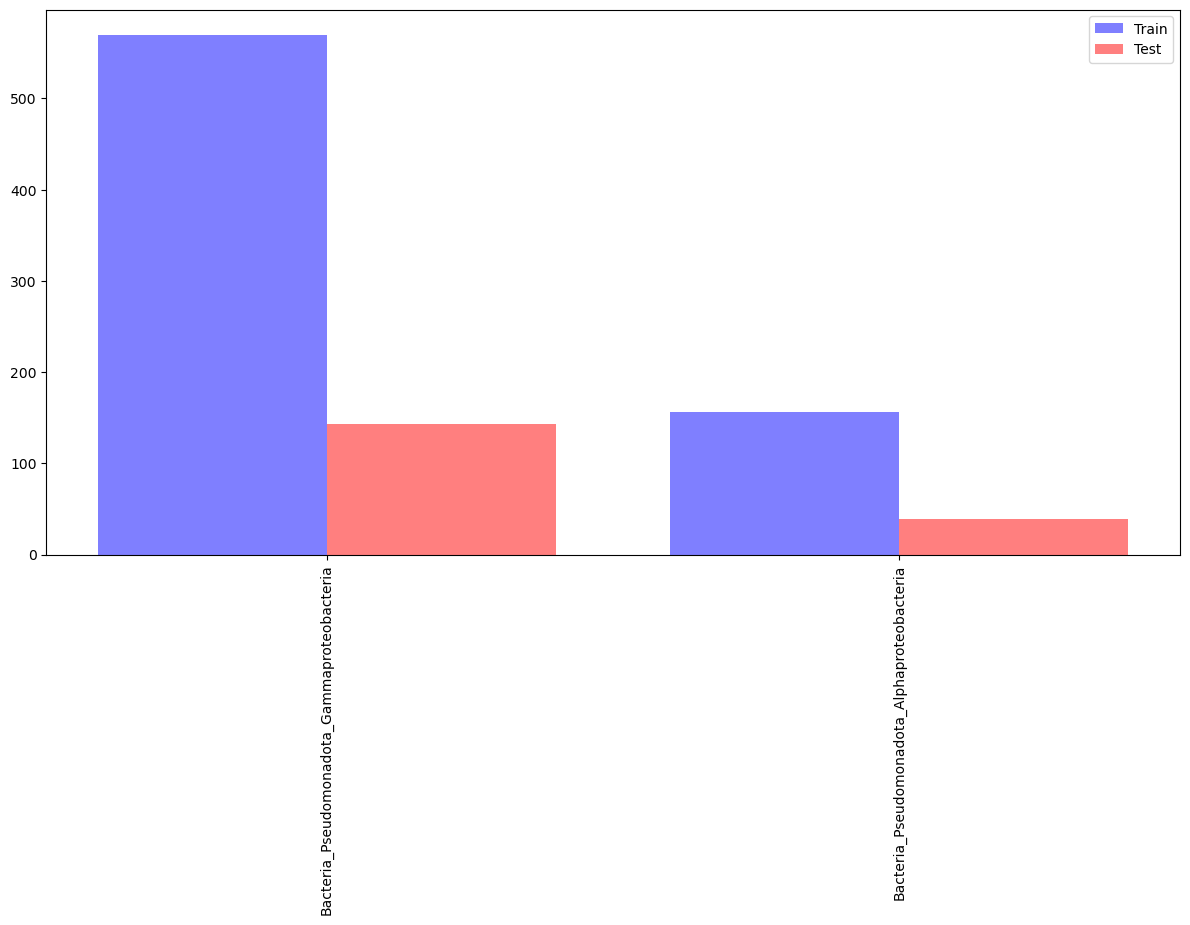

Metrics for target Domain to class
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.934066   0.936122  0.934066  0.930332
Model trained with accuracy: 0.9340659340659341
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_class_model.joblib


(0
 bcAd1037T--bcAd1037T_ptg000059l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1037T--bcAd1037T_ptg000325l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1037T--bcAd1037T_ptg000259l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1039T--bcAd1039T_ptg000535l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1039T--bcAd1039T_ptg000554l    Bacteria_Pseudomonadota_Gammaproteobacteria
                                                       ...                     
 bcAd1039T--bcAd1039T_ptg000613l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1039T--bcAd1039T_ptg000564l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1037T--bcAd1037T_ptg000097l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1063T--bcAd1063T_ptg000348l    Bacteria_Pseudomonadota_Gammaproteobacteria
 bcAd1063T--bcAd1063T_ptg000372l    Bacteria_Pseudomonadota_Gammaproteobacteria
 Name: Domain to class, Length: 182, dtype: object,
 array(['Bacteria_Pseudomonadota_Gammaproteobacteria',
        'B

In [13]:
train_test_model(data, output_folder, 'Domain to class')

Training the model with target: Domain to phylum
before filtering number of classes 15
after filtering number of classes 15
Dropped classes: {nan}
before filtering number of classes 2
after filtering number of classes 1
Plotting the distribution
Number of samples in each species in the train set:
Domain to phylum
Bacteria_Pseudomonadota    725
Name: count, dtype: int64

Number of samples in each species in the test set:
Domain to phylum
Bacteria_Pseudomonadota    182
Name: count, dtype: int64


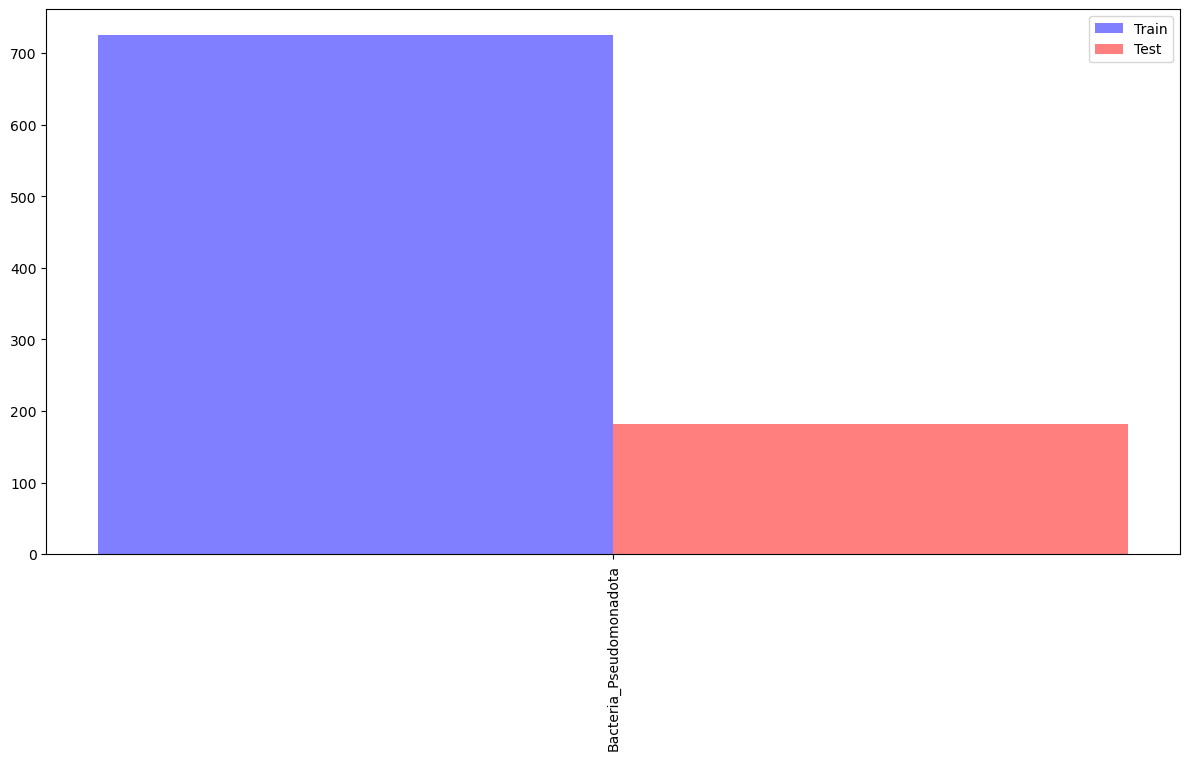

/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/PUHTI_TYKKY_FRQGCcR/miniconda/envs/env1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Metrics for target Domain to phylum
   Accuracy Train  Accuracy Test  Precision  Recall  F1 Score
0             1.0            1.0        1.0     1.0       1.0
Model trained with accuracy: 1.0
Saving the model to /scratch/project_2006608/Methylation/notebooks/RF_HAMBI/Domain_to_phylum_model.joblib


(0
 bcAd1039T--bcAd1039T_ptg000114l    Bacteria_Pseudomonadota
 bcAd1039T--bcAd1039T_ptg000168l    Bacteria_Pseudomonadota
 bcAd1039T--bcAd1039T_ptg000029l    Bacteria_Pseudomonadota
 bcAd1023T--bcAd1023T_ptg000277l    Bacteria_Pseudomonadota
 bcAd1037T--bcAd1037T_ptg000213l    Bacteria_Pseudomonadota
                                             ...           
 bcAd1063T--bcAd1063T_ptg000273l    Bacteria_Pseudomonadota
 bcAd1039T--bcAd1039T_ptg000666l    Bacteria_Pseudomonadota
 bcAd1039T--bcAd1039T_ptg000560l    Bacteria_Pseudomonadota
 bcAd1039T--bcAd1039T_ptg000660l    Bacteria_Pseudomonadota
 bcAd1046T--bcAd1046T_ptg000187l    Bacteria_Pseudomonadota
 Name: Domain to phylum, Length: 182, dtype: object,
 array(['Bacteria_Pseudomonadota', 'Bacteria_Pseudomonadota',
        'Bacteria_Pseudomonadota', 'Bacteria_Pseudomonadota',
        'Bacteria_Pseudomonadota', 'Bacteria_Pseudomonadota',
        'Bacteria_Pseudomonadota', 'Bacteria_Pseudomonadota',
        'Bacteria_Pseudomonadota', '

In [14]:
train_test_model(data, output_folder, 'Domain to phylum')

# Trying with the most important features

In [15]:
def clean_data(data: pd.DataFrame) -> pd.DataFrame:
    classes_before = set(data['Domain to species'].unique())
    print(f"Before filtering, number of classes: {len(data['Domain to species'].value_counts())}")    
    data_filtered = data.dropna(subset=['All'], axis=0)
    data_filtered = data_filtered[(data_filtered['All'] != '') & (data_filtered['All'] != 'Bacteria')]
    data_filtered = data_filtered[(data_filtered.iloc[:, :492] != 0).any(axis=1)]
    print(f"After filtering, number of classes: {len(data_filtered['Domain to species'].value_counts())}")
    classes_after = set(data_filtered['Domain to species'].unique())
    dropped_classes = classes_before - classes_after
    if dropped_classes:
        print(f"Dropped classes: {dropped_classes}")
    else:
        print("No classes were dropped.")
    return data_filtered

def filter_out_n(data: pd.DataFrame, column_name: str, n: int) -> pd.DataFrame:
    print(f"Before filtering, number of classes: {len(data[column_name].value_counts())}")
    counts = data[column_name].value_counts()
    classes = counts[counts > n].index
    filtered_data = data[data[column_name].isin(classes)]
    filtered_data = filtered_data.dropna(subset=[column_name], axis=0)
    print(f"After filtering, number of classes: {len(filtered_data[column_name].value_counts())}")

    return filtered_data

def plot_confusion_matrix(y_true: pd.Series, y_pred: pd.Series, model, title: str, target: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=model.classes_, yticklabels=model.classes_, cbar=True)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title(f'{title} - Accuracy: {accuracy_score(y_true, y_pred):.2f}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()

    #plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat_200.png'), bbox_inches='tight')
    plt.savefig(os.path.join(output_folder, f'{target}_confusion_mat_70.png'), bbox_inches='tight')
    
    plt.show()

def plot_train_test_distribution(y_train: pd.Series, y_test: pd.Series, target: str):
    print("Plotting the distribution of train and test sets")
    train_species_counts = y_train.value_counts()
    test_species_counts = y_test.value_counts()
    
    categories = pd.concat([y_train, y_test]).value_counts().index
    train_counts = y_train.value_counts().reindex(categories, fill_value=0)
    test_counts = y_test.value_counts().reindex(categories, fill_value=0)
    
    indices = range(len(categories))
    bar_width = 0.4 

    plt.figure(figsize=(12, 8))
    plt.bar([i - bar_width / 2 for i in indices], train_counts, width=bar_width, color='blue', alpha=0.5, label='Train')
    plt.bar([i + bar_width / 2 for i in indices], test_counts, width=bar_width, color='red', alpha=0.5, label='Test')
    
    plt.xticks(indices, categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def plot_feature_importance(model: RandomForestClassifier, X: pd.DataFrame, target: str, top_n: int = 30):
    """Plot the feature importance of the model with color-coded bars by methylation type.
    
    Parameters:
    - model (RandomForestClassifier): Trained model.
    - X (pd.DataFrame): Data frame with the features.
    - target (str): Target column.
    - top_n (int): Number of top features to plot.
    """
    methylation_colors = {
        'm6A': 'skyblue',
        'm4C': 'lightcoral',
        'modified_base': 'lightgreen',
        'other': 'gray'
    }

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    top_indices = indices[:top_n]
    top_features = X.columns[top_indices]

    def get_color(feature_name):
        if 'm6A' in feature_name:
            return methylation_colors['m6A']
        elif 'm4C' in feature_name:
            return methylation_colors['m4C']
        elif 'modified_base' in feature_name:
            return methylation_colors['modified_base']
        else:
            return methylation_colors['other']

    bar_colors = [get_color(feature) for feature in top_features]

    # Vertical bar plot
    plt.figure(figsize=(25, 10))
    plt.bar(range(top_n), importances[top_indices], align='center', color=bar_colors)
    plt.xticks(range(top_n), top_features, rotation=45, ha='right', fontsize=10)
    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.tight_layout()
    plt.show()

    # Horizontal bar plot
    fig, ax = plt.subplots(figsize=(20, max(5, top_n // 3)))
    ax.barh(range(top_n), importances[top_indices], color=bar_colors)
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(top_features, fontsize=8)
    ax.set_ylim(-0.5, top_n - 0.5) 

    ax.set_xlim(0, max(importances[top_indices]) * 1.05)

    plt.title(f"Feature Importance of Top {top_n} Features with Target {target}", fontsize=20)
    plt.gca().invert_yaxis()

    plt.tight_layout()
    #plt.save
    plt.savefig(os.path.join(output_folder, f'{target}_features.png'))
    plt.show()

def train_test_model(df: pd.DataFrame, target: str, n:int):
    
    print(f"Training the model with target: {target}")
    filtered_data = clean_data(df)
    filtered_data = filter_out_n(filtered_data, target, 10)
    
    X = filtered_data.iloc[:, :492]
    y = filtered_data[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    plot_train_test_distribution(y_train, y_test, target)

    model = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    #plot_confusion_matrix(y_train, y_train_pred, model, 'Train Set', target)
    #plot_confusion_matrix(y_test, y_test_pred, model, 'Test Set', target)

    plot_feature_importance(model, X, target, top_n=n)

    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with all features")
    print(metrics)

    importances = model.feature_importances_
    top_n = n
    top_features_indices = np.argsort(importances)[::-1][:top_n]
    X_train_top = X_train.iloc[:, top_features_indices]
    X_test_top = X_test.iloc[:, top_features_indices]

    model_top = RandomForestClassifier(random_state=seed, n_jobs=-1)
    model_top.fit(X_train_top, y_train)

    y_train_pred = model_top.predict(X_train_top)
    y_test_pred = model_top.predict(X_test_top)

    plot_confusion_matrix(y_train, y_train_pred, model_top, 'Train Set', target)
    plot_confusion_matrix(y_test, y_test_pred, model_top, 'Test Set', target)


    metrics = pd.DataFrame({
        'Accuracy Train': [accuracy_score(y_train, y_train_pred)],
        'Accuracy Test': [accuracy_score(y_test, y_test_pred)],
        'Precision': [precision_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'Recall': [recall_score(y_test, y_test_pred, average='weighted', zero_division=0)],
        'F1 Score': [f1_score(y_test, y_test_pred, average='weighted', zero_division=0)]
    })
    print(f"Metrics for target {target} with top {n} features")
    print(metrics)

    return y_test, y_test_pred

# Trying different number of features 

Training the model with target: Domain to species
Before filtering, number of classes: 15
After filtering, number of classes: 15
Dropped classes: {nan}
Before filtering, number of classes: 15
After filtering, number of classes: 11
Plotting the distribution of train and test sets


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


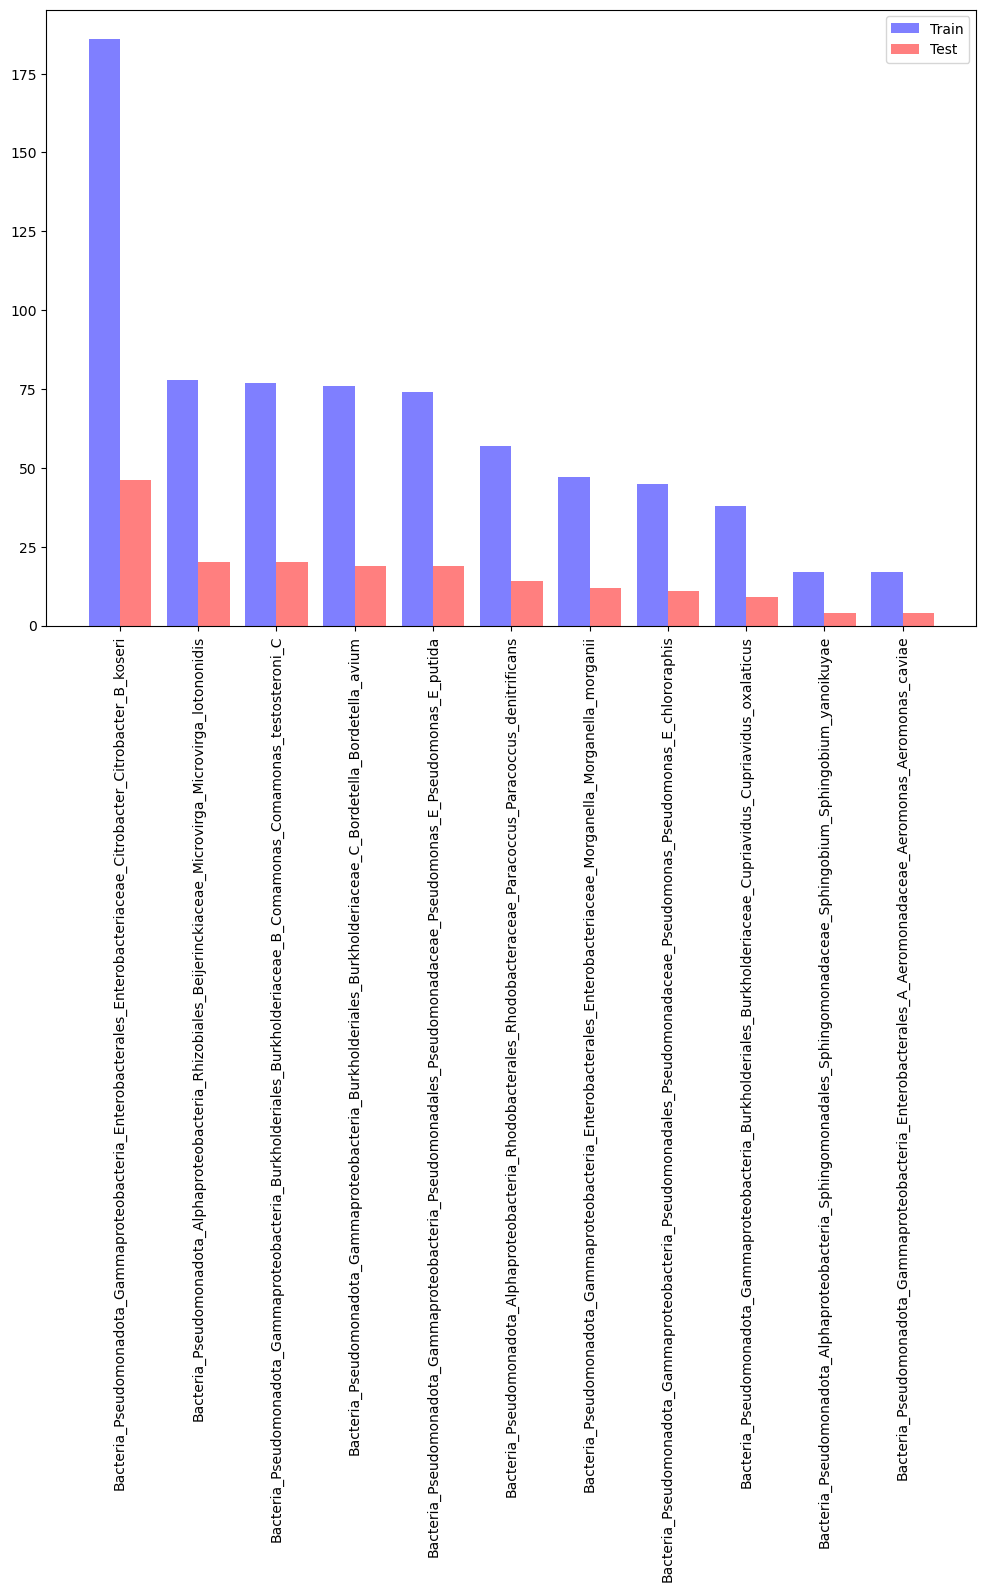

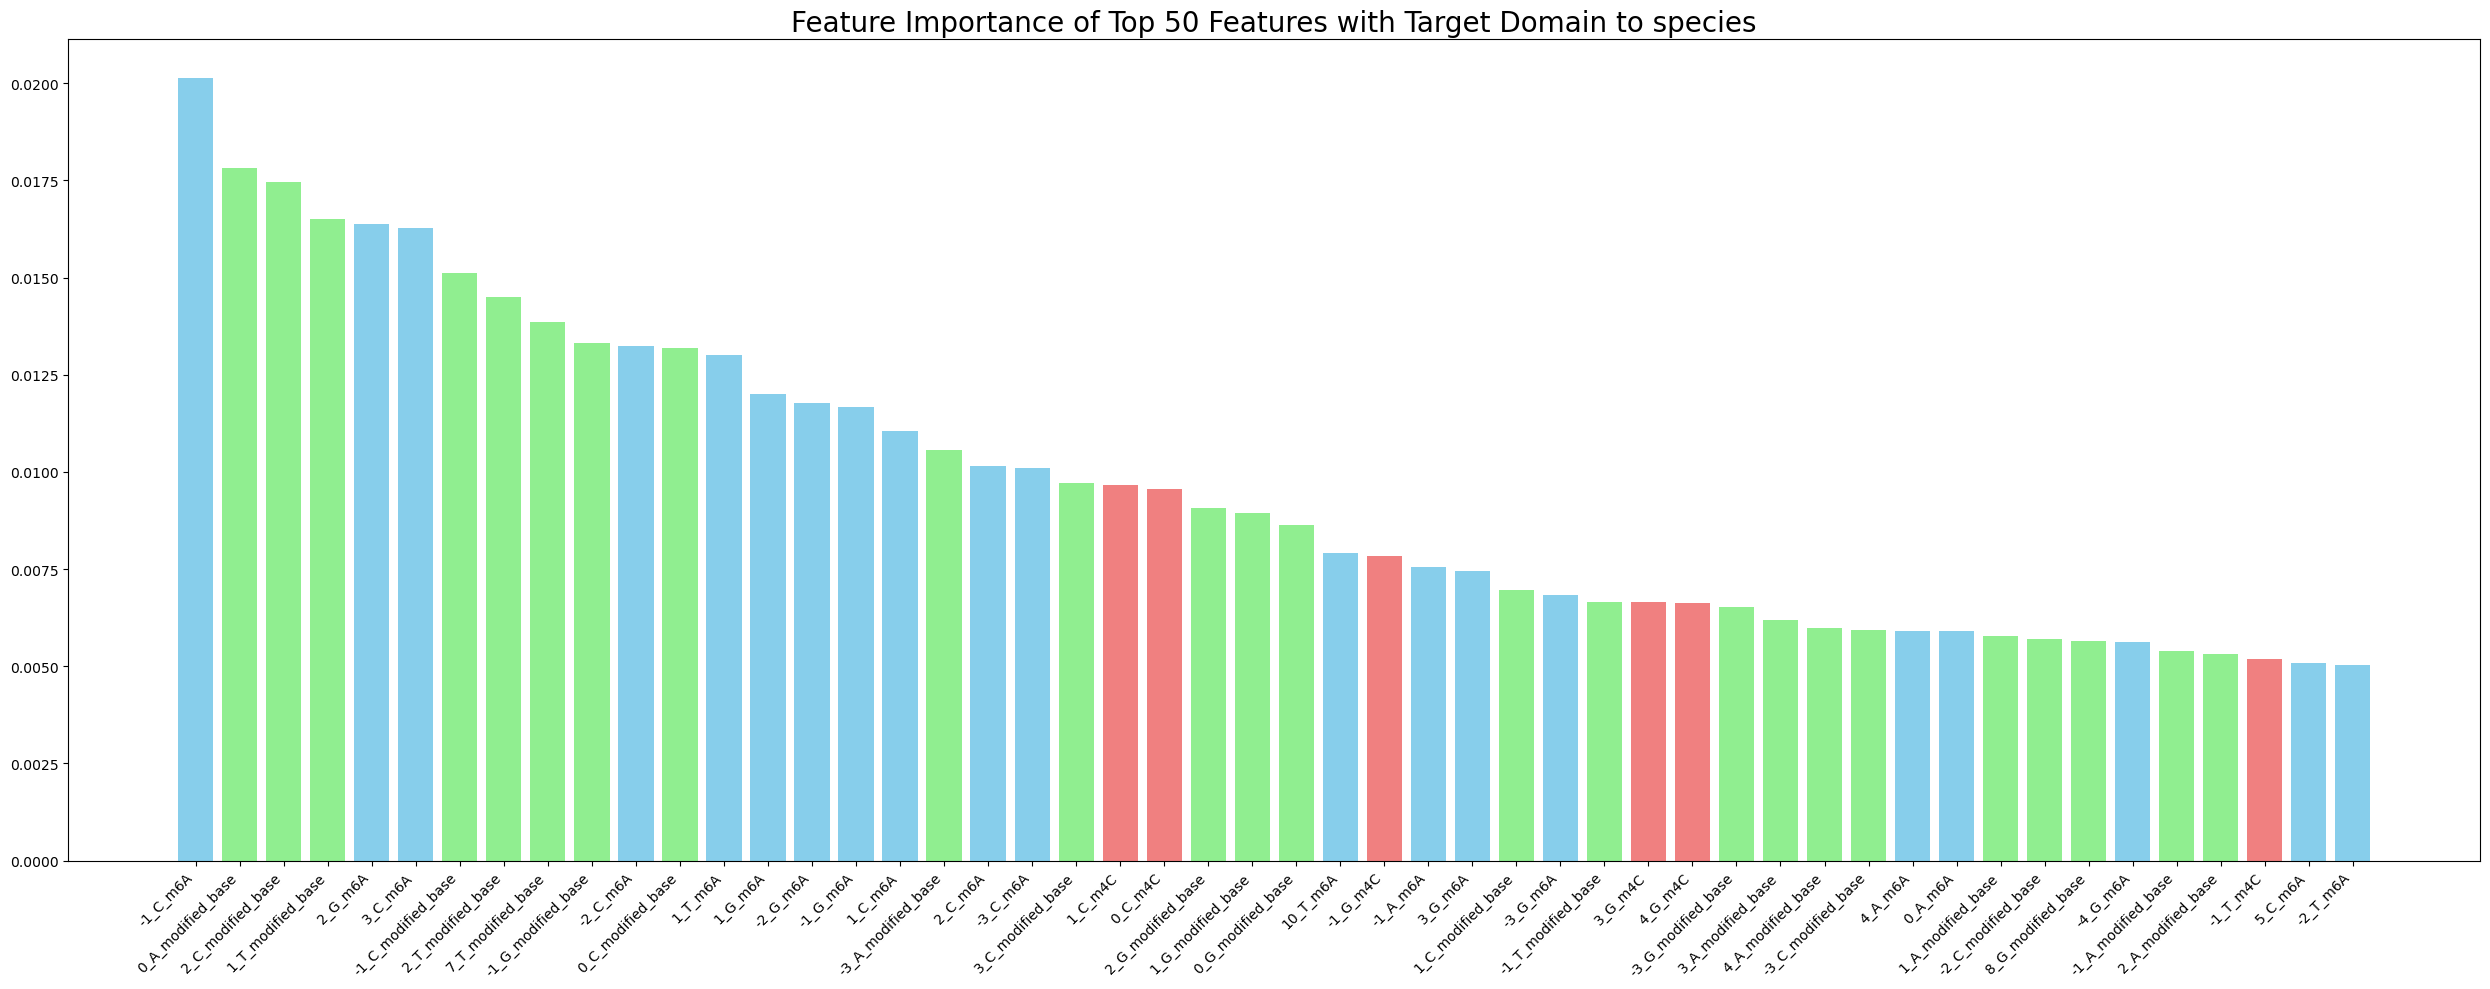

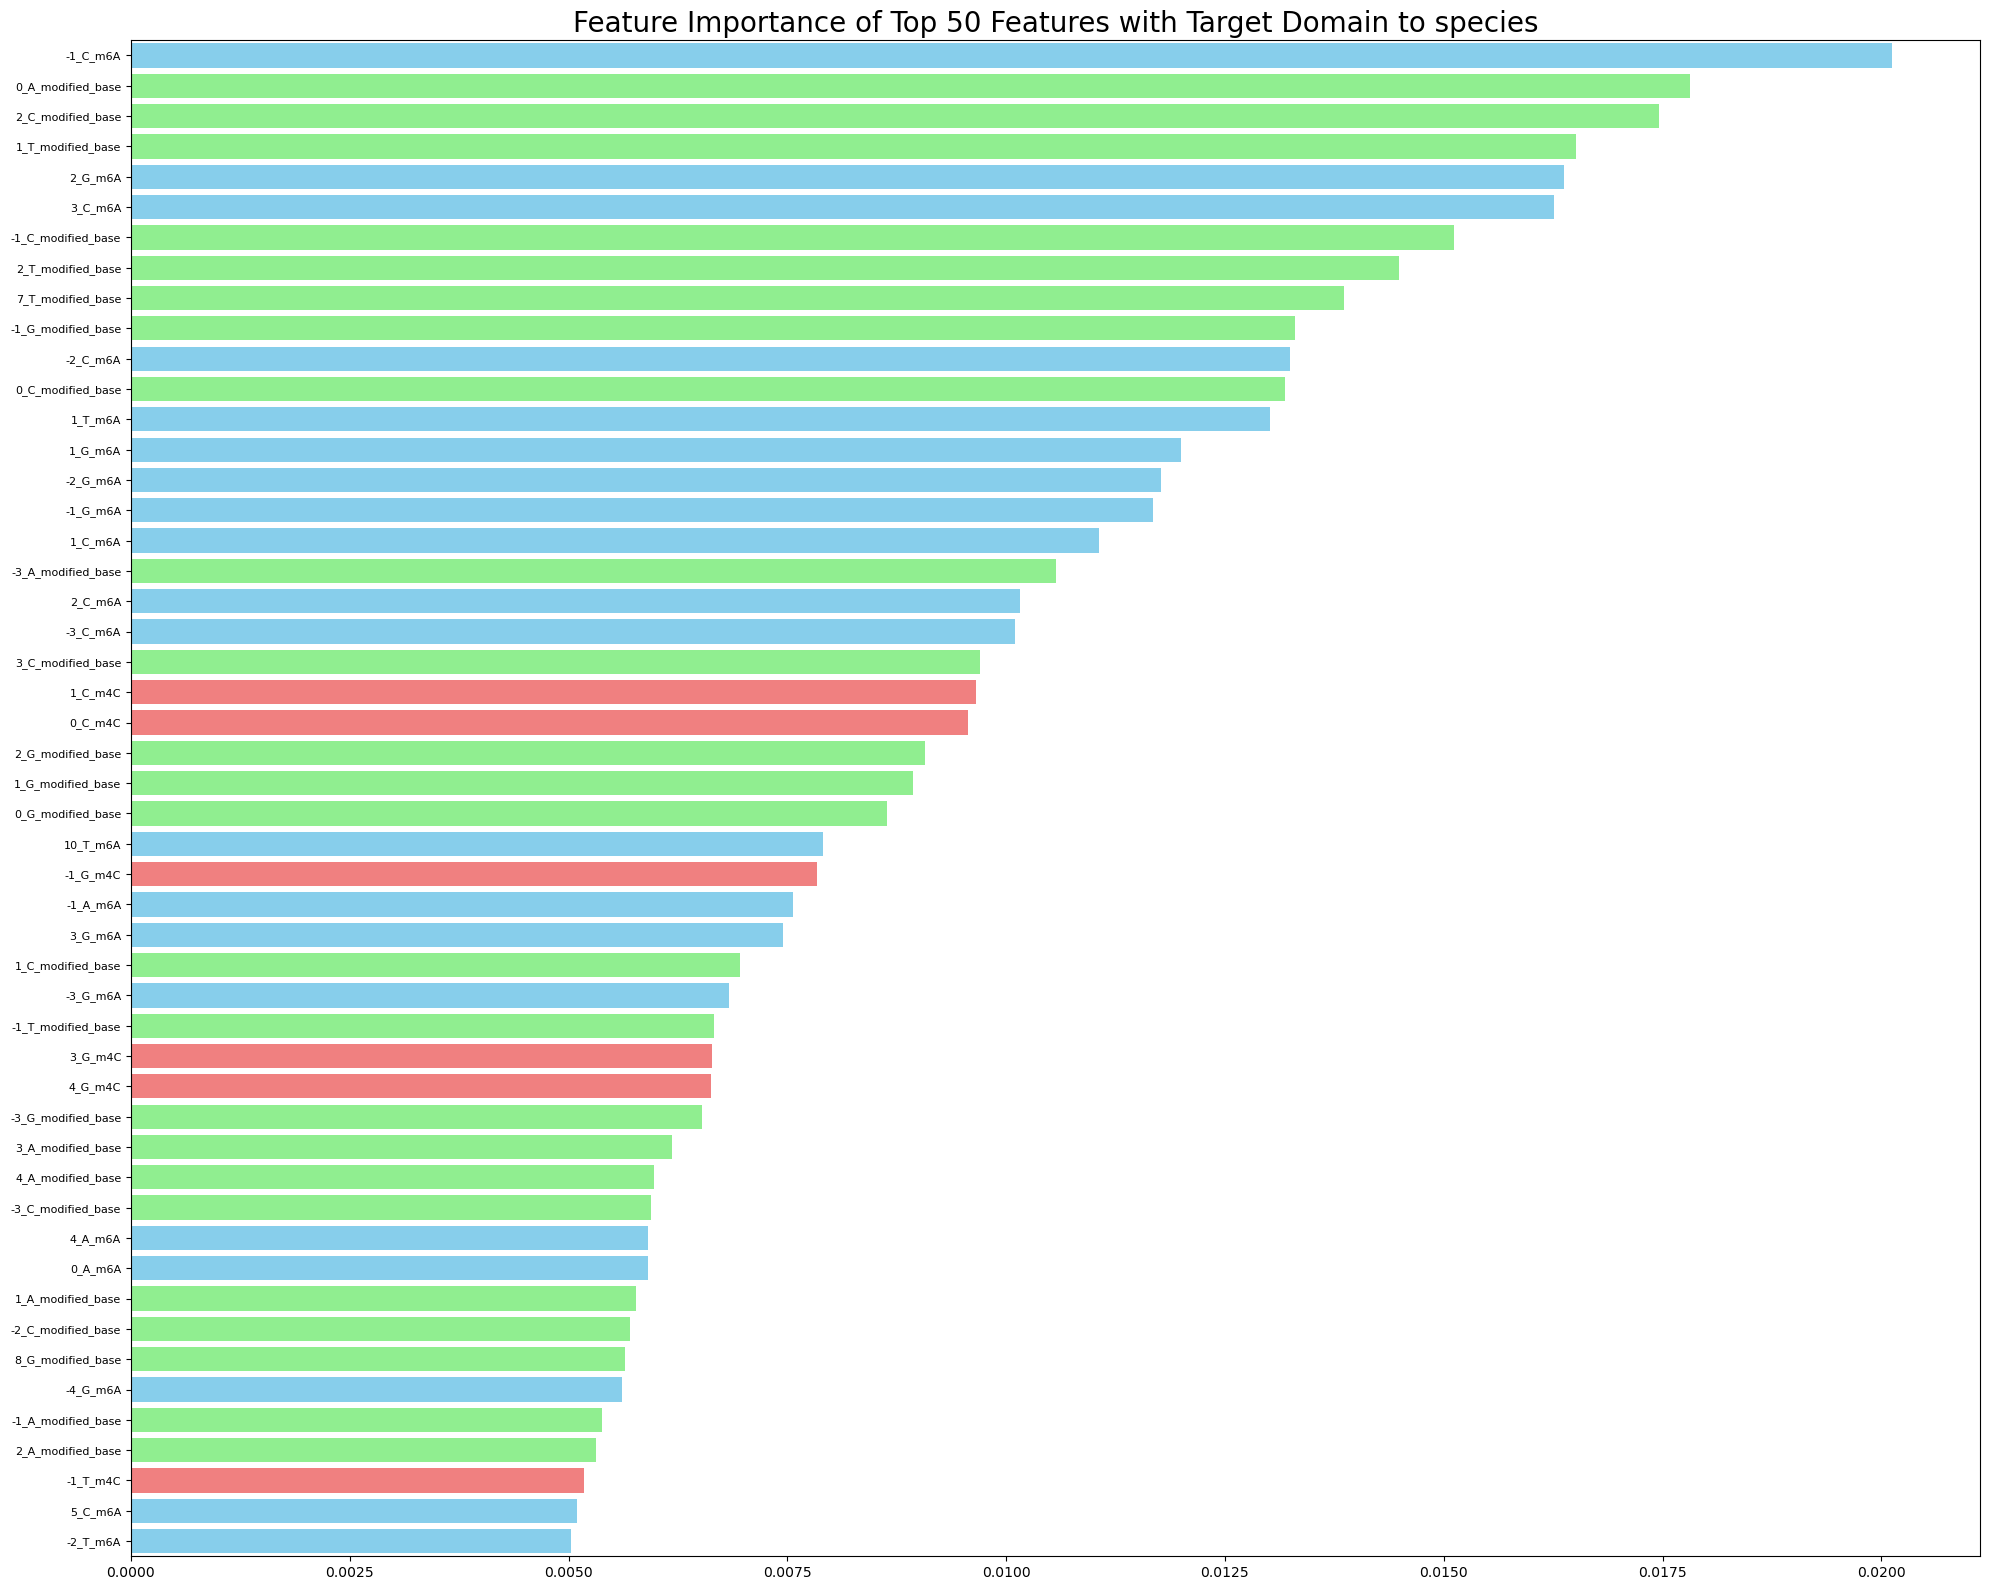

Metrics for target Domain to species with all features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


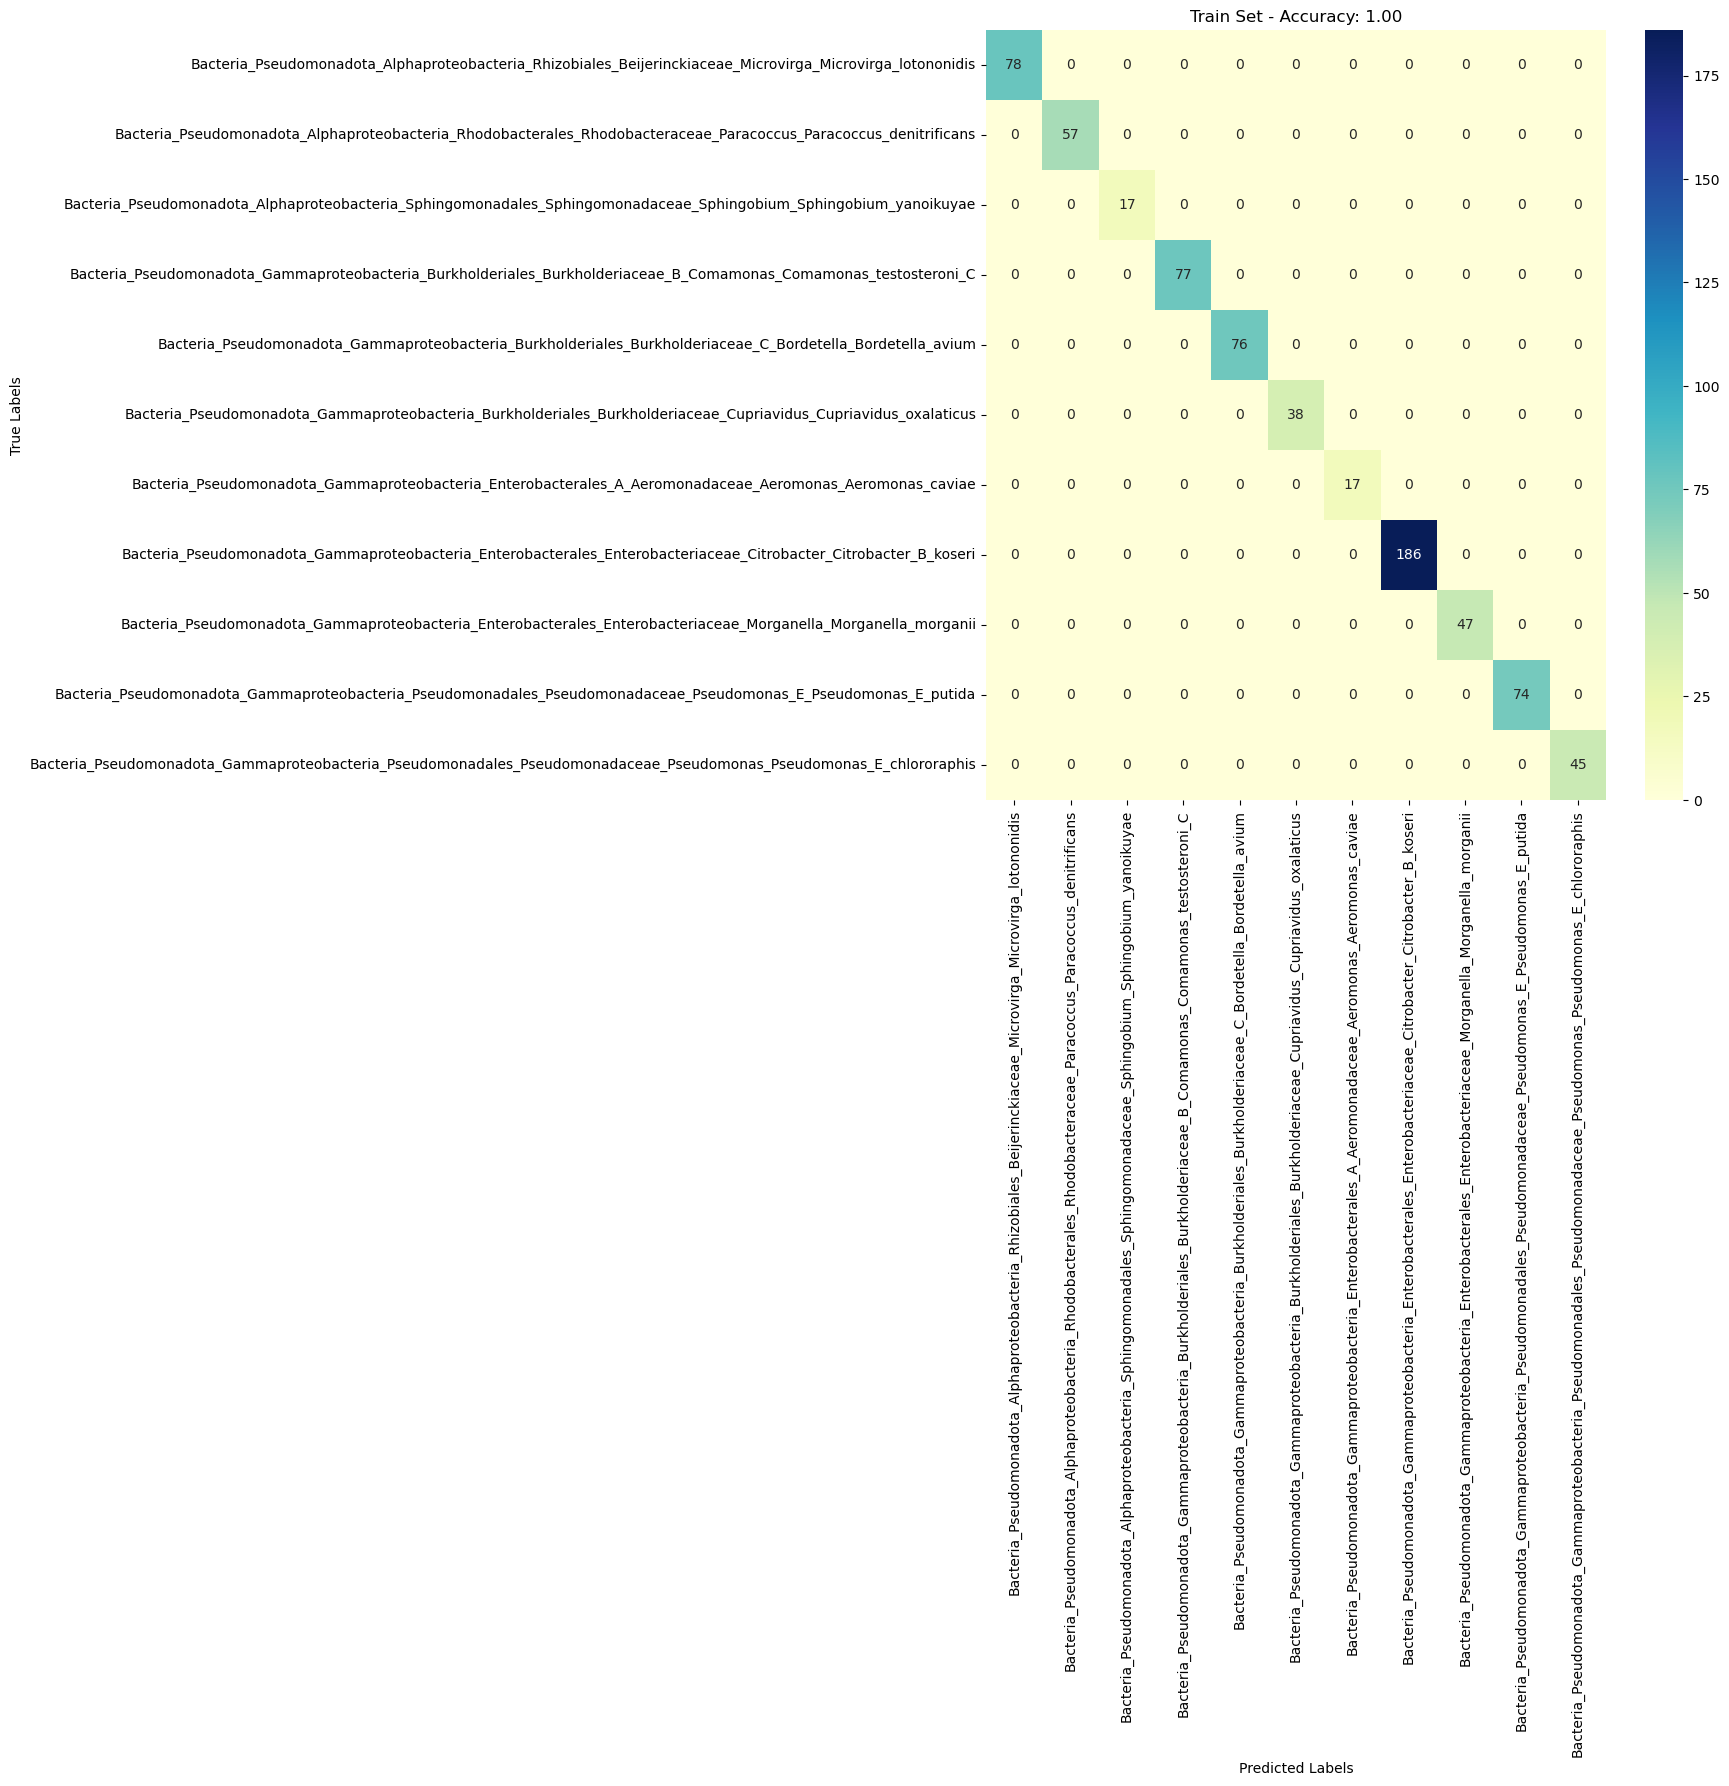

/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


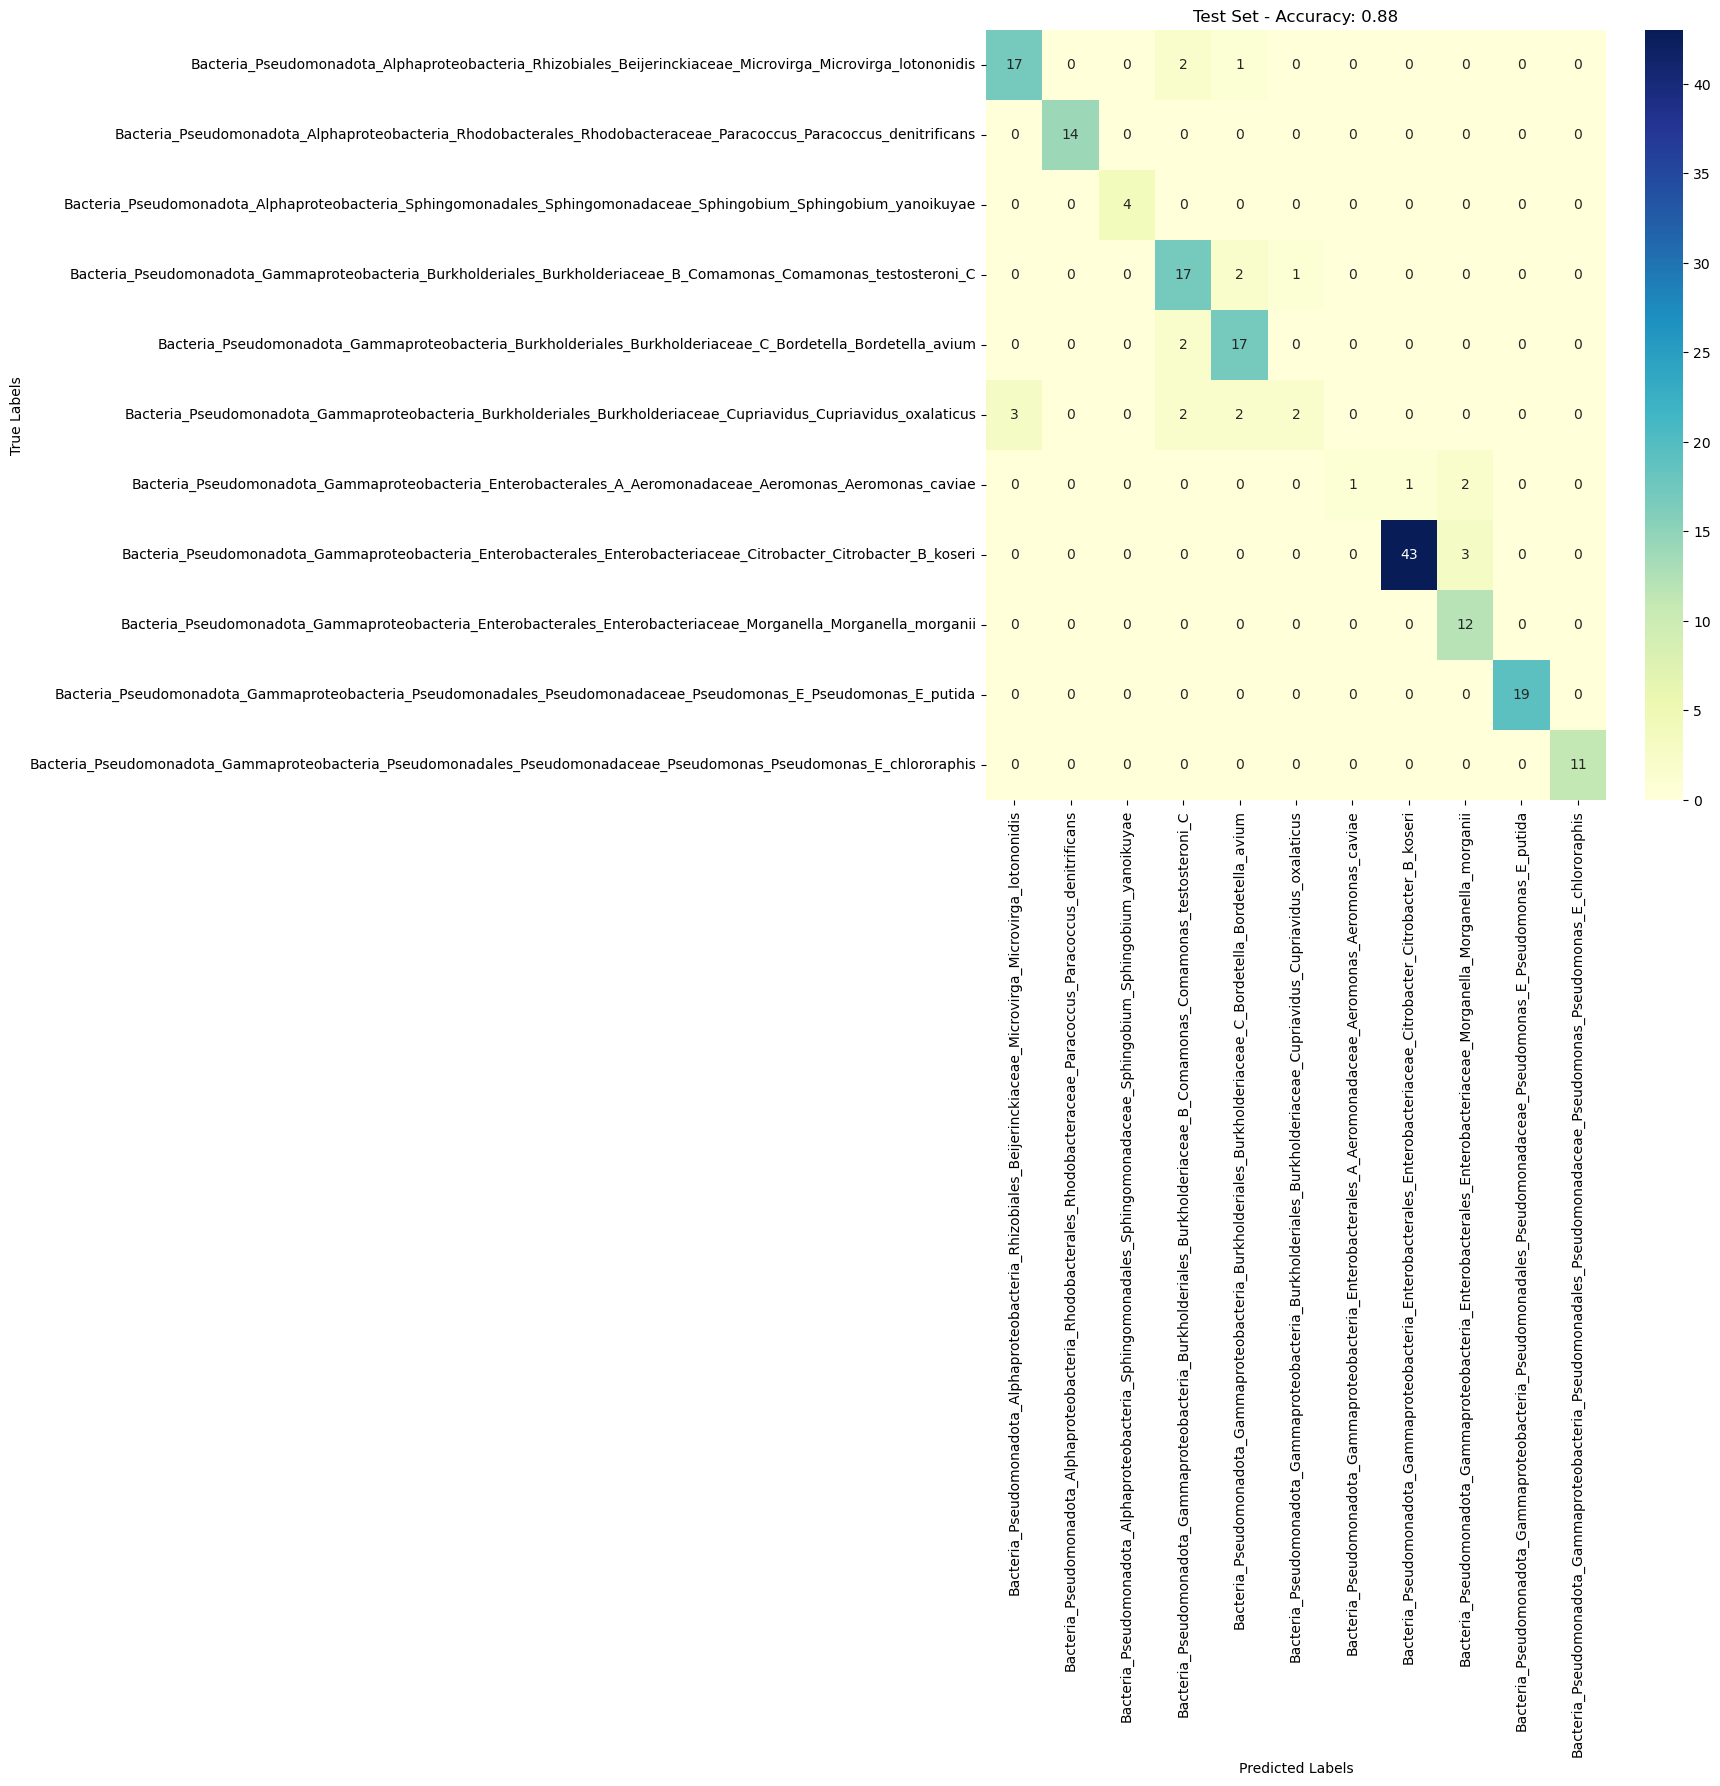

Metrics for target Domain to species with top 50 features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.882022    0.88702  0.882022  0.871105


In [16]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 50)

Training the model with target: Domain to species
Before filtering, number of classes: 15
After filtering, number of classes: 15
Dropped classes: {nan}
Before filtering, number of classes: 15
After filtering, number of classes: 11
Plotting the distribution of train and test sets


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


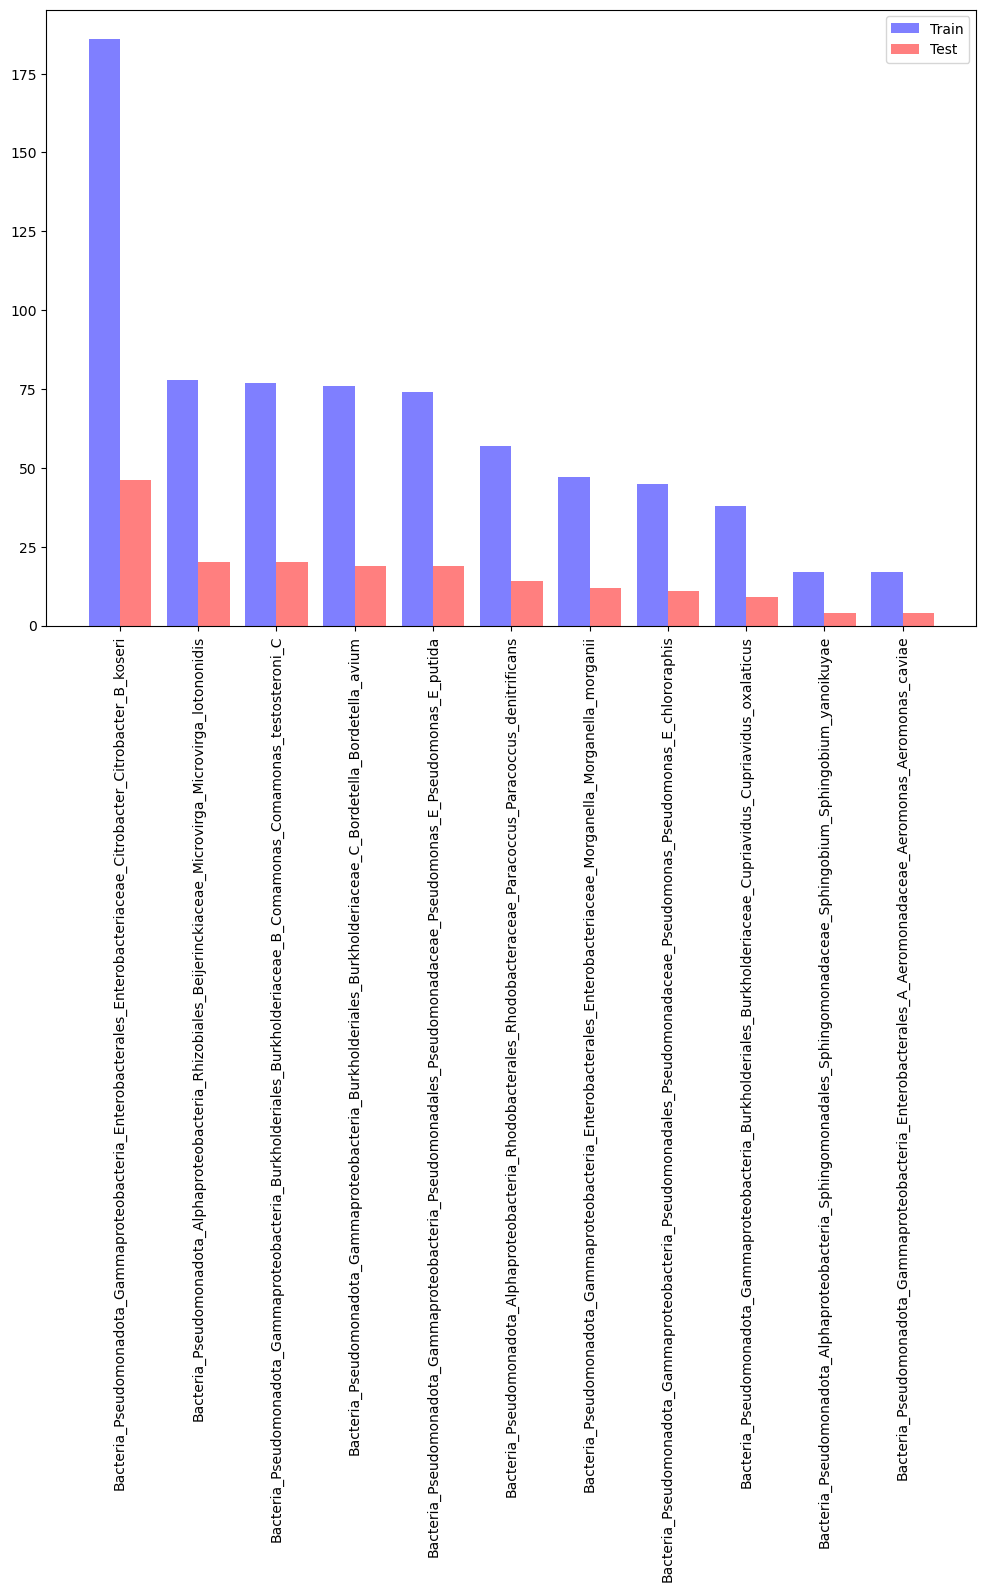

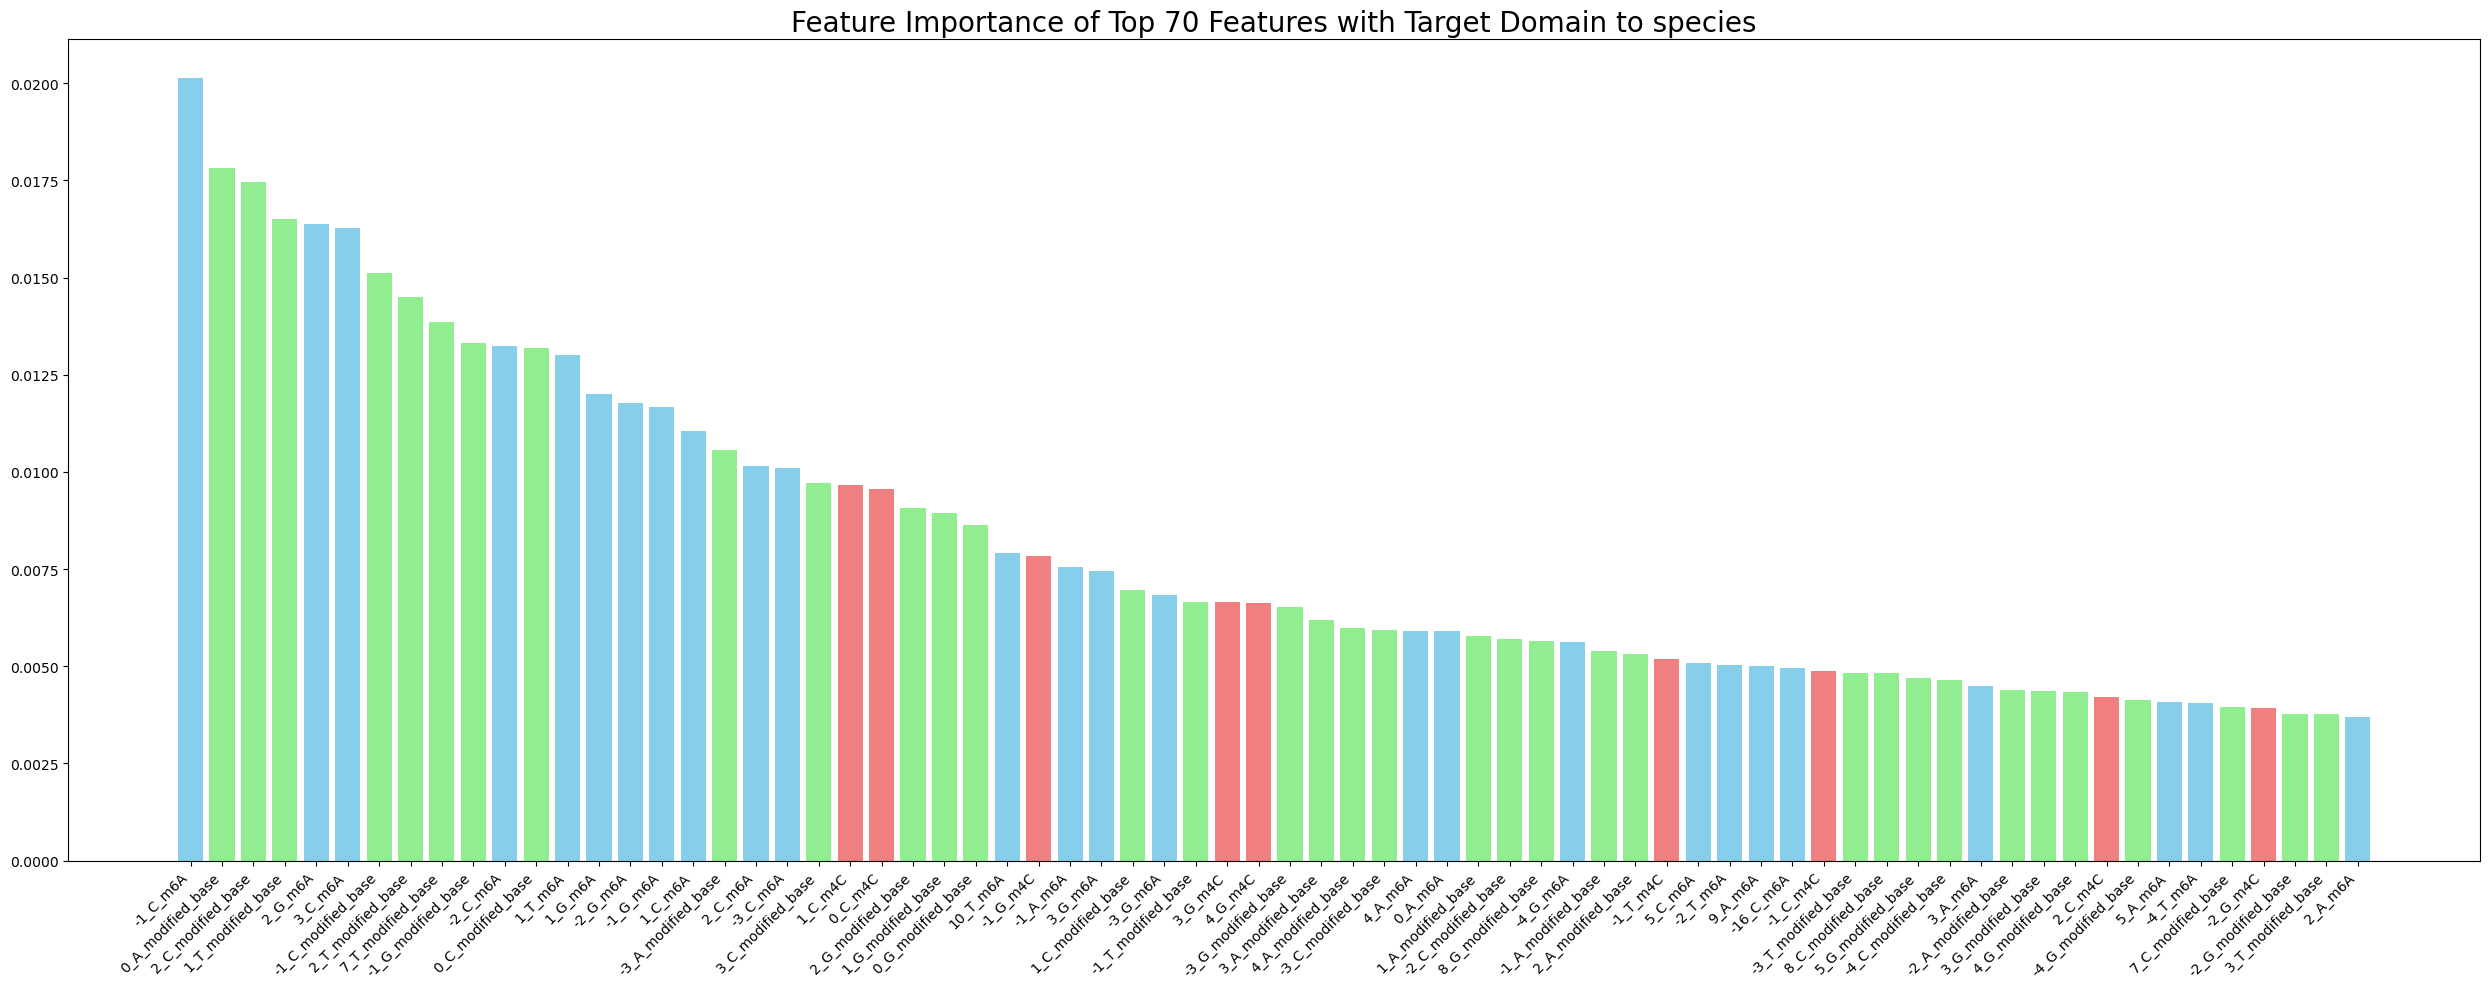

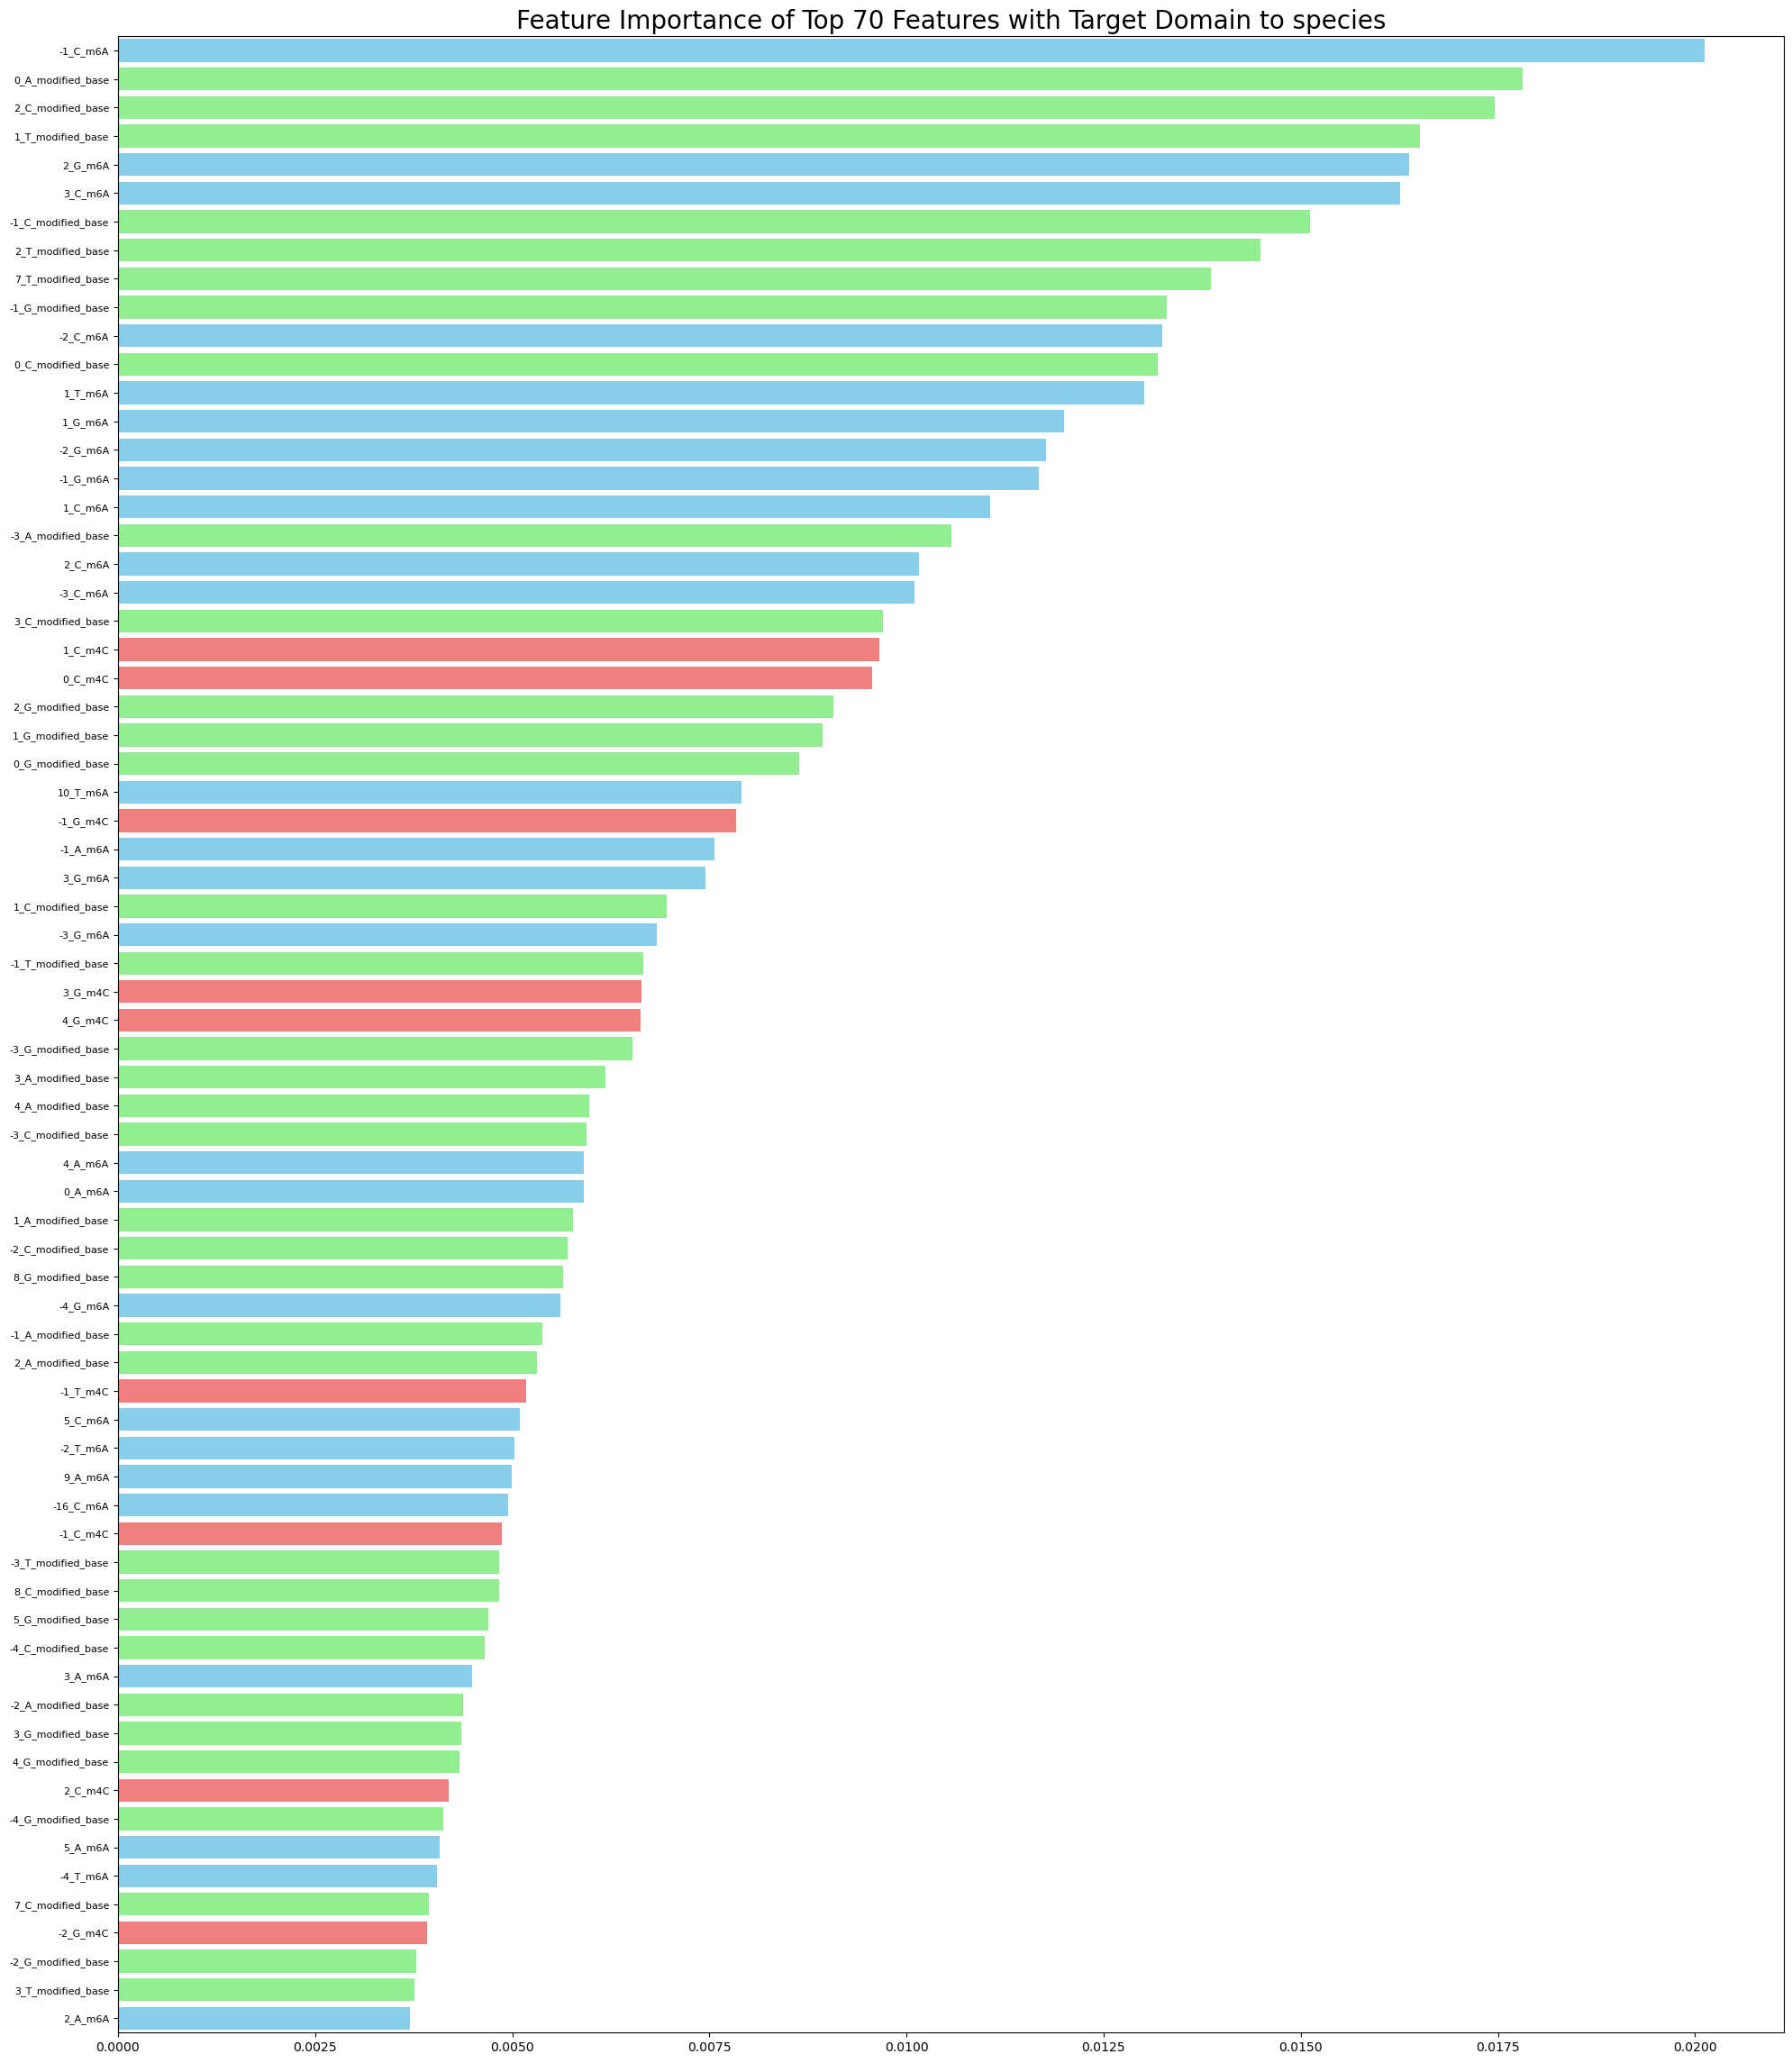

Metrics for target Domain to species with all features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


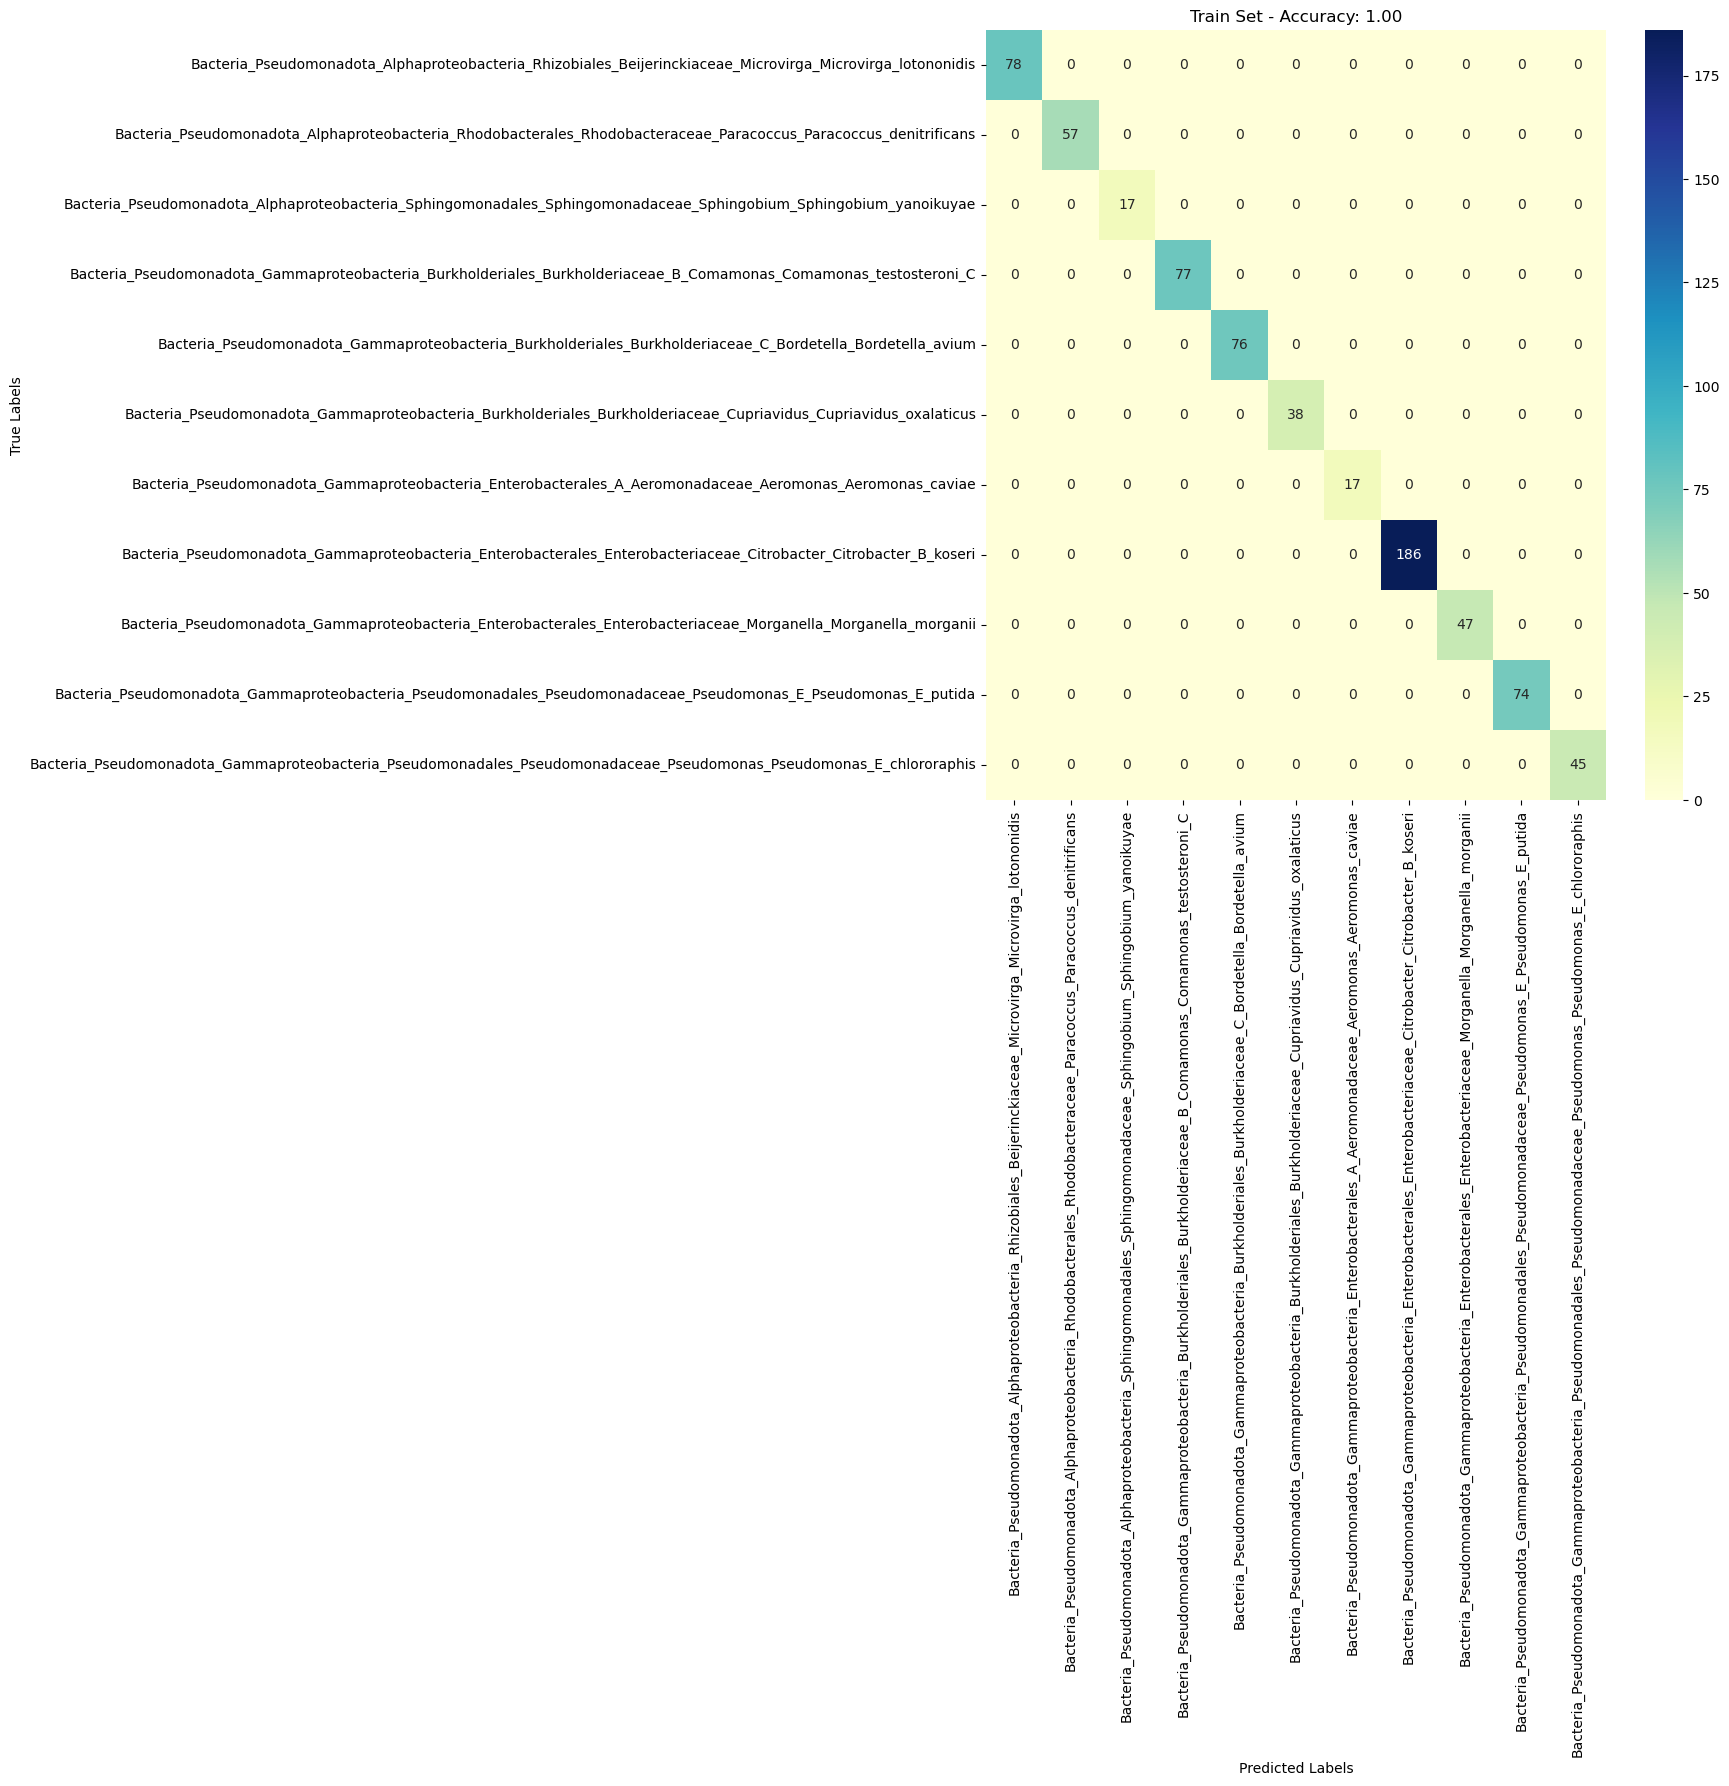

/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


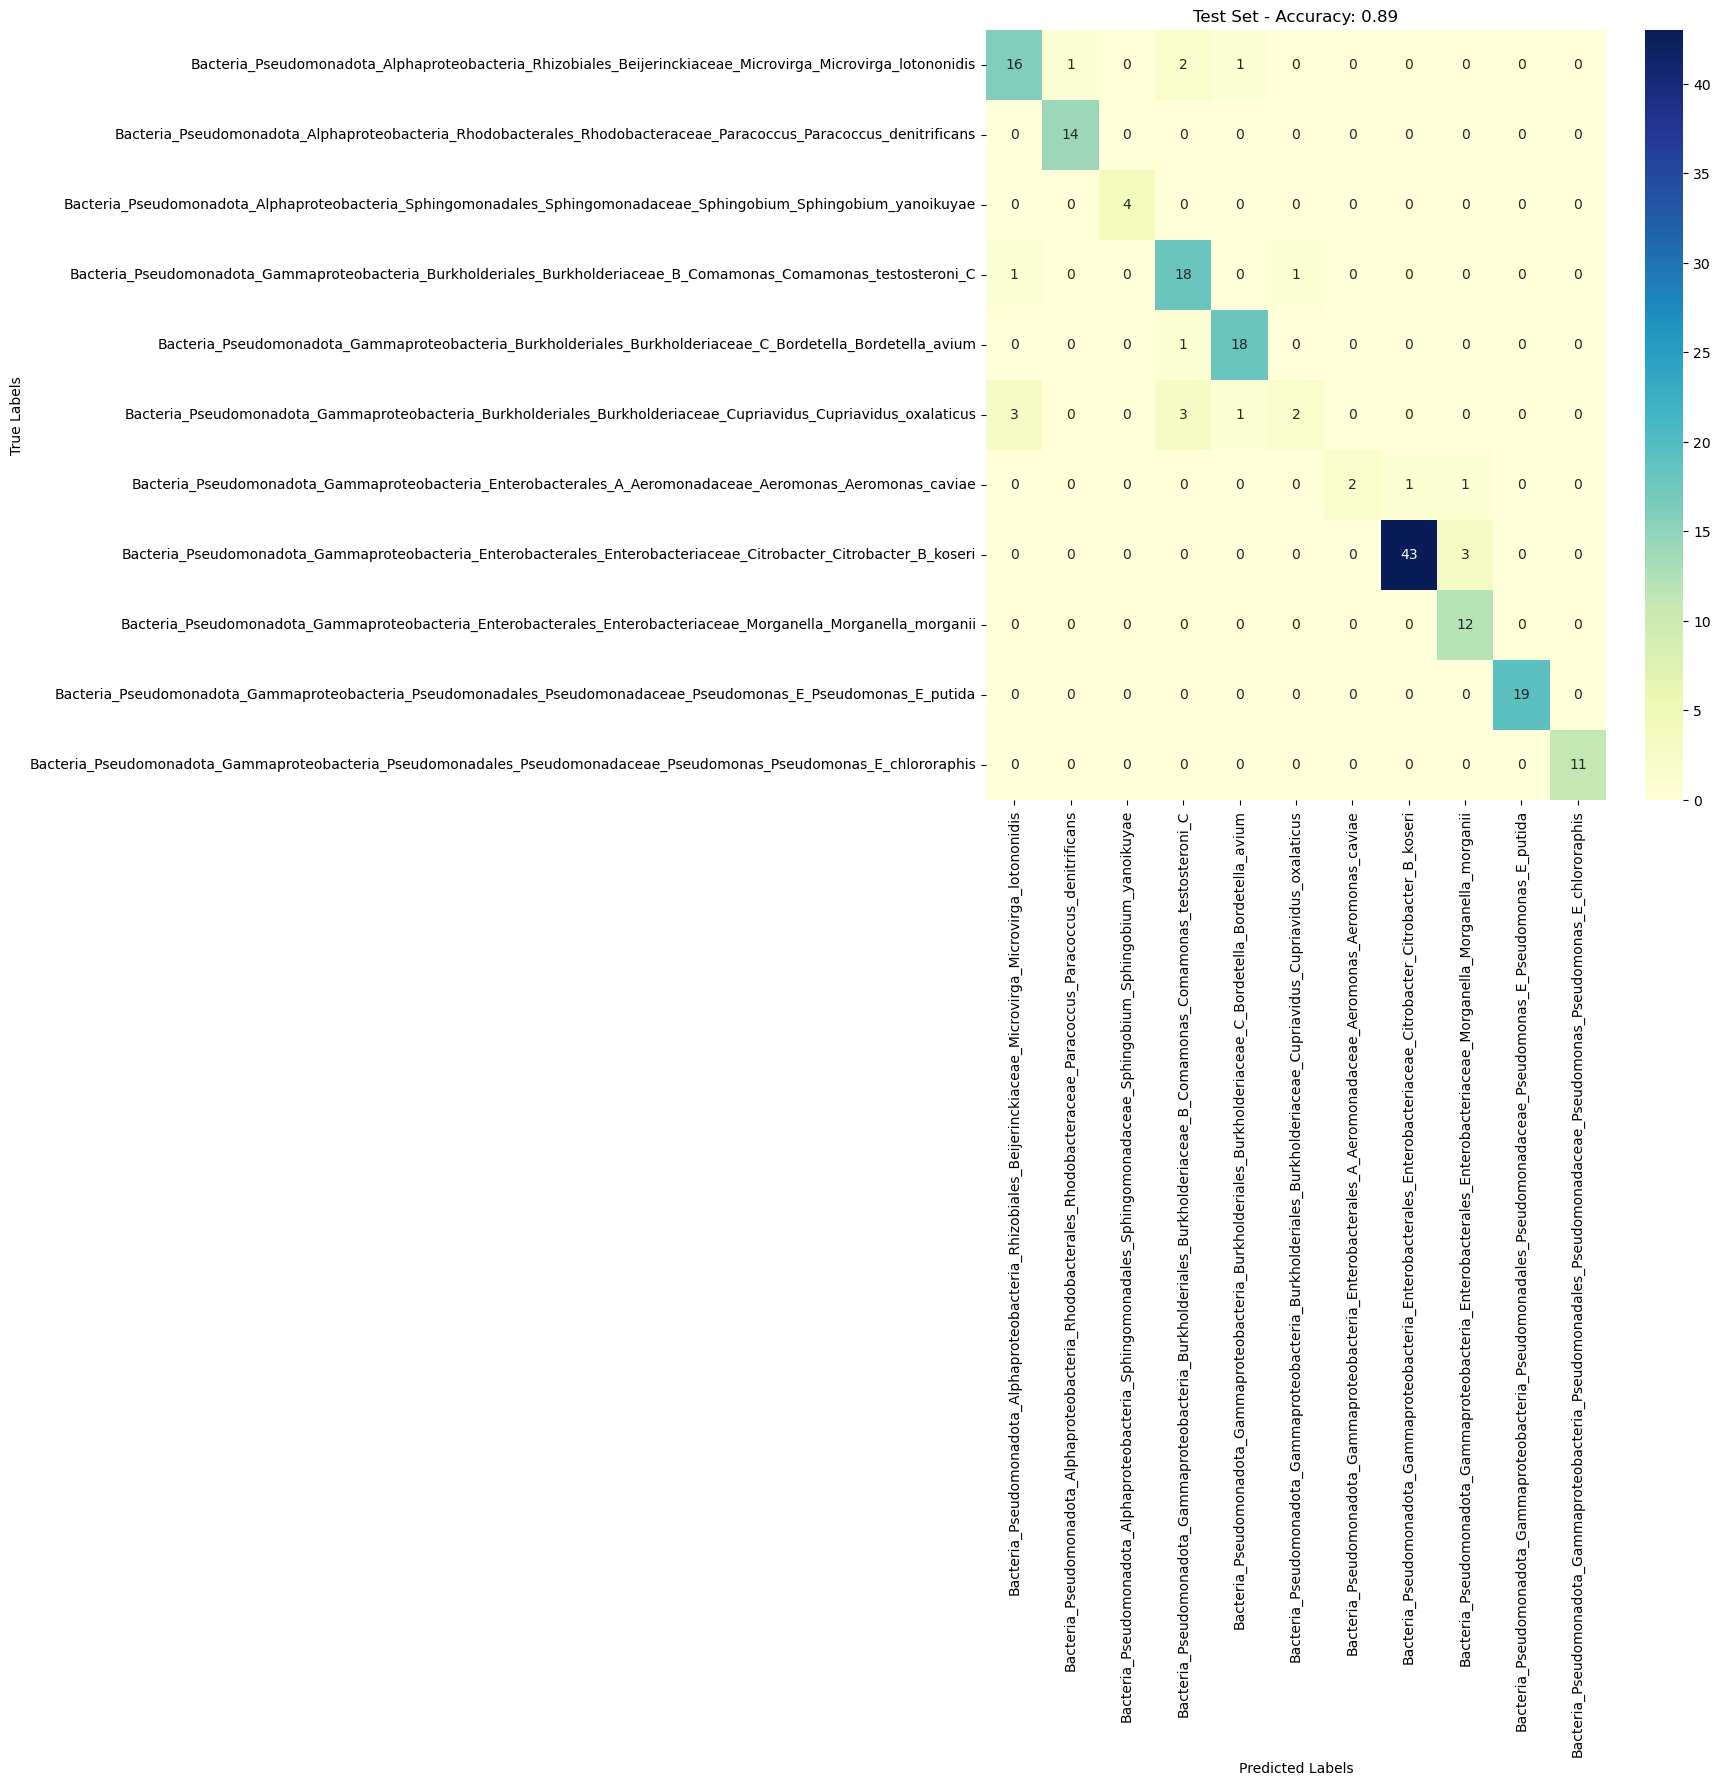

Metrics for target Domain to species with top 70 features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.893258   0.893939  0.893258  0.883861


In [17]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 70)

Training the model with target: Domain to species
Before filtering, number of classes: 15
After filtering, number of classes: 15
Dropped classes: {nan}
Before filtering, number of classes: 15
After filtering, number of classes: 11
Plotting the distribution of train and test sets


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


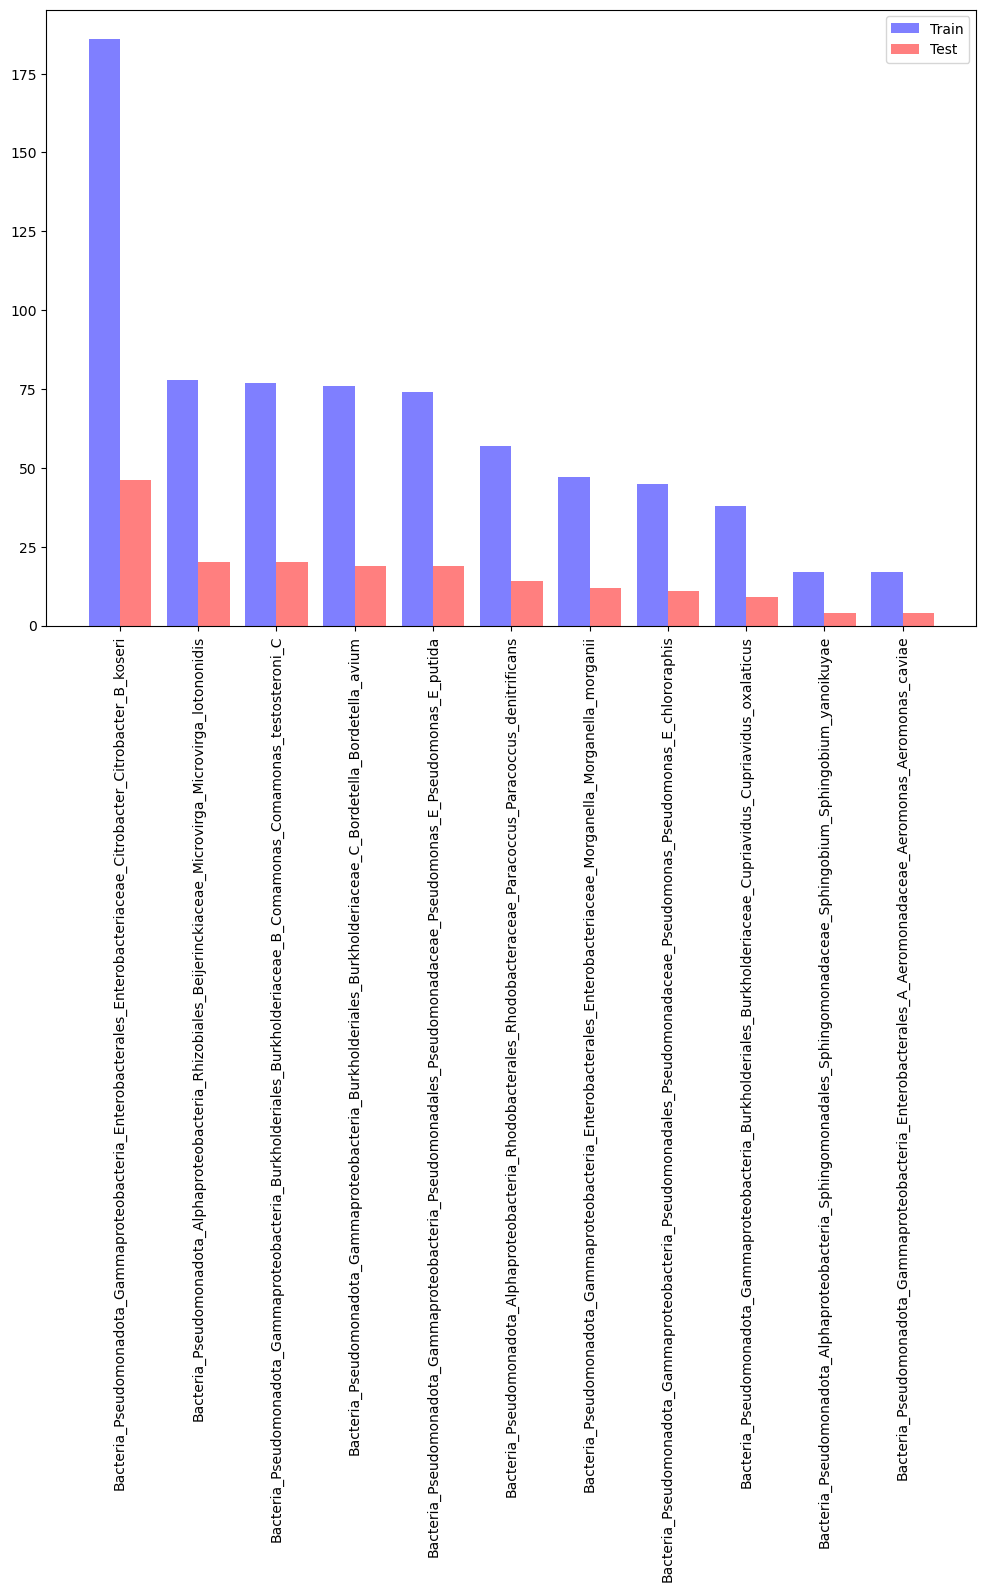

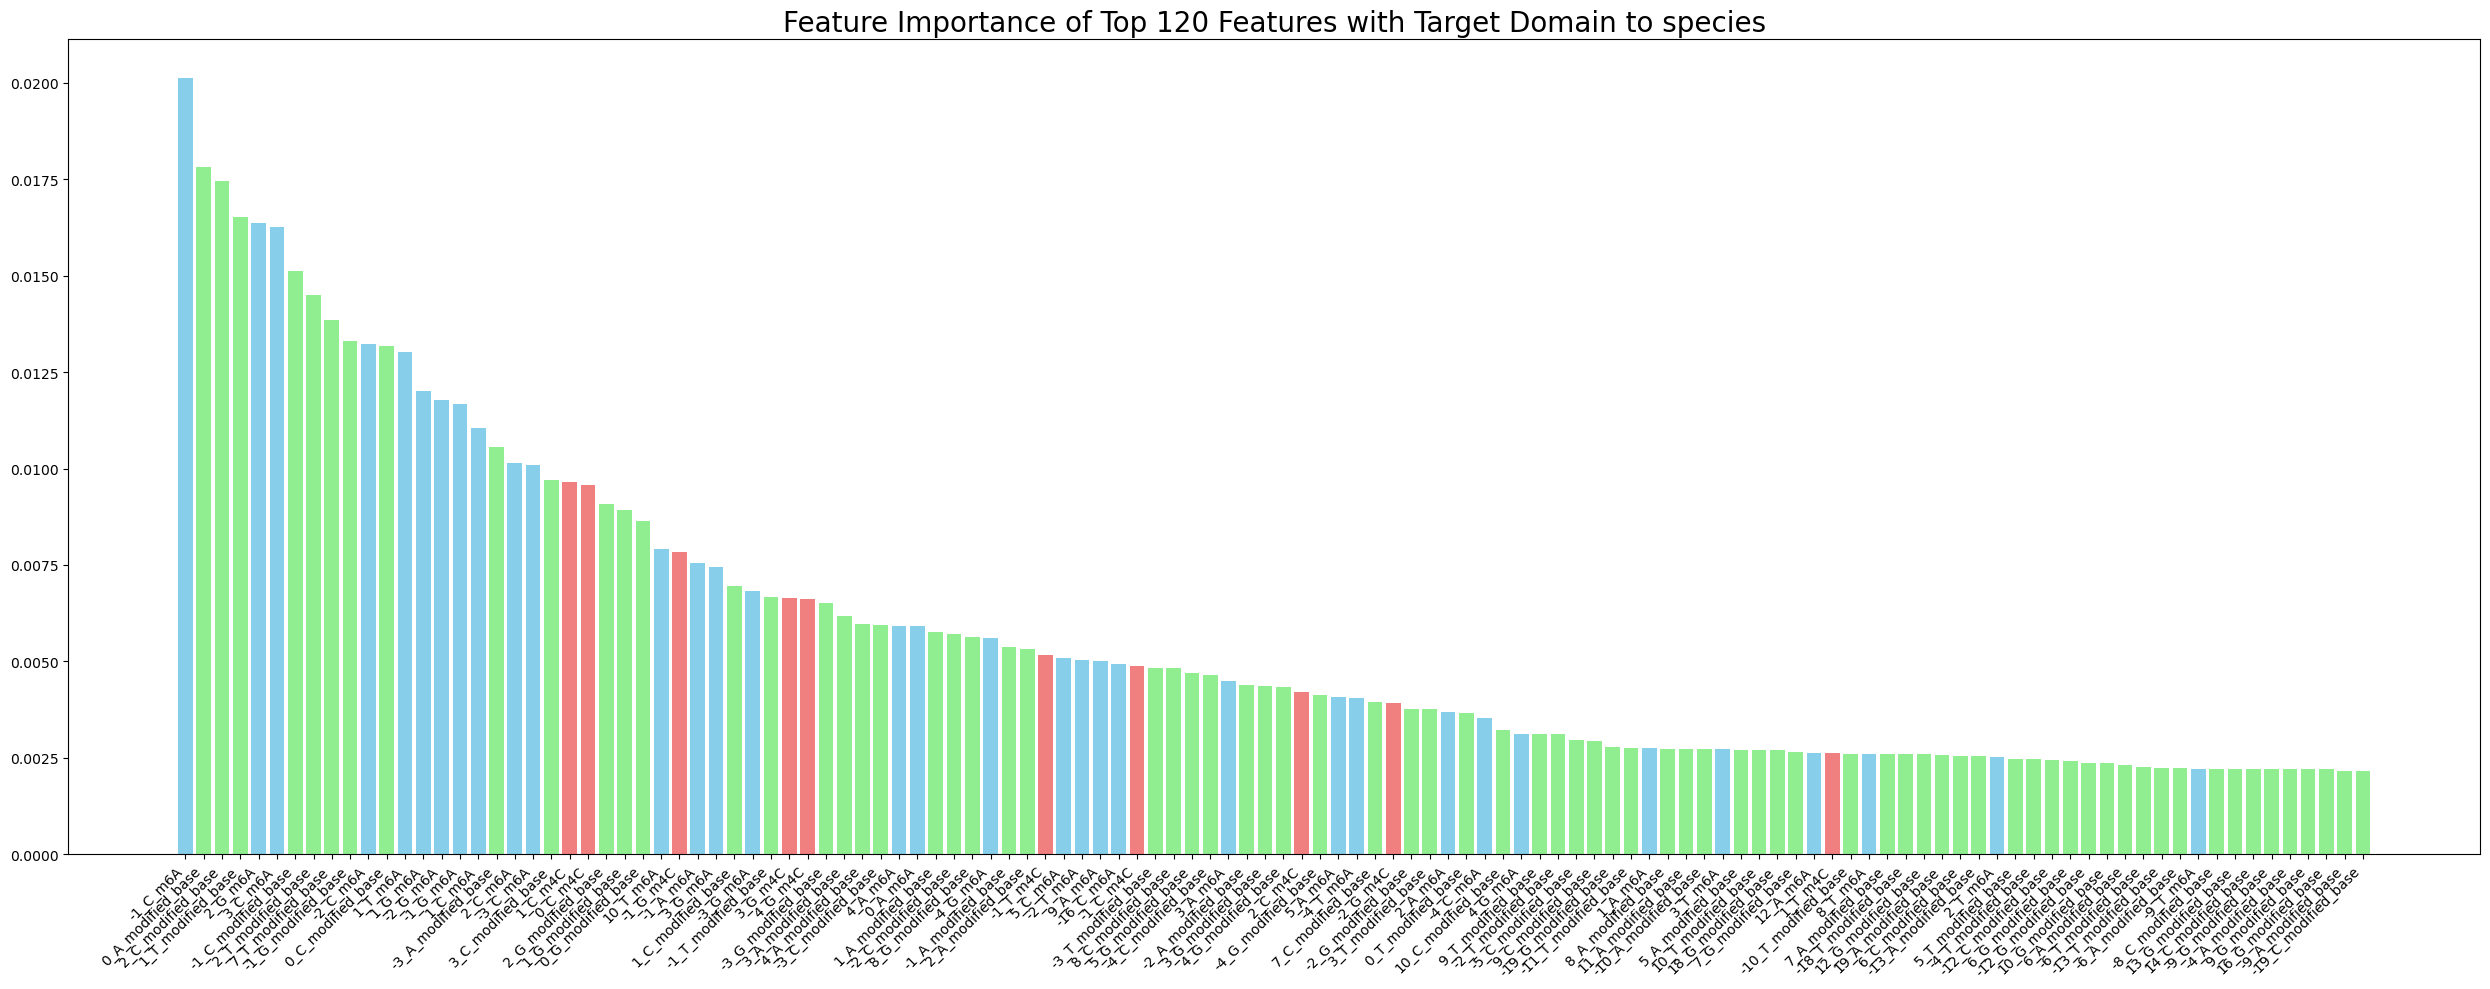

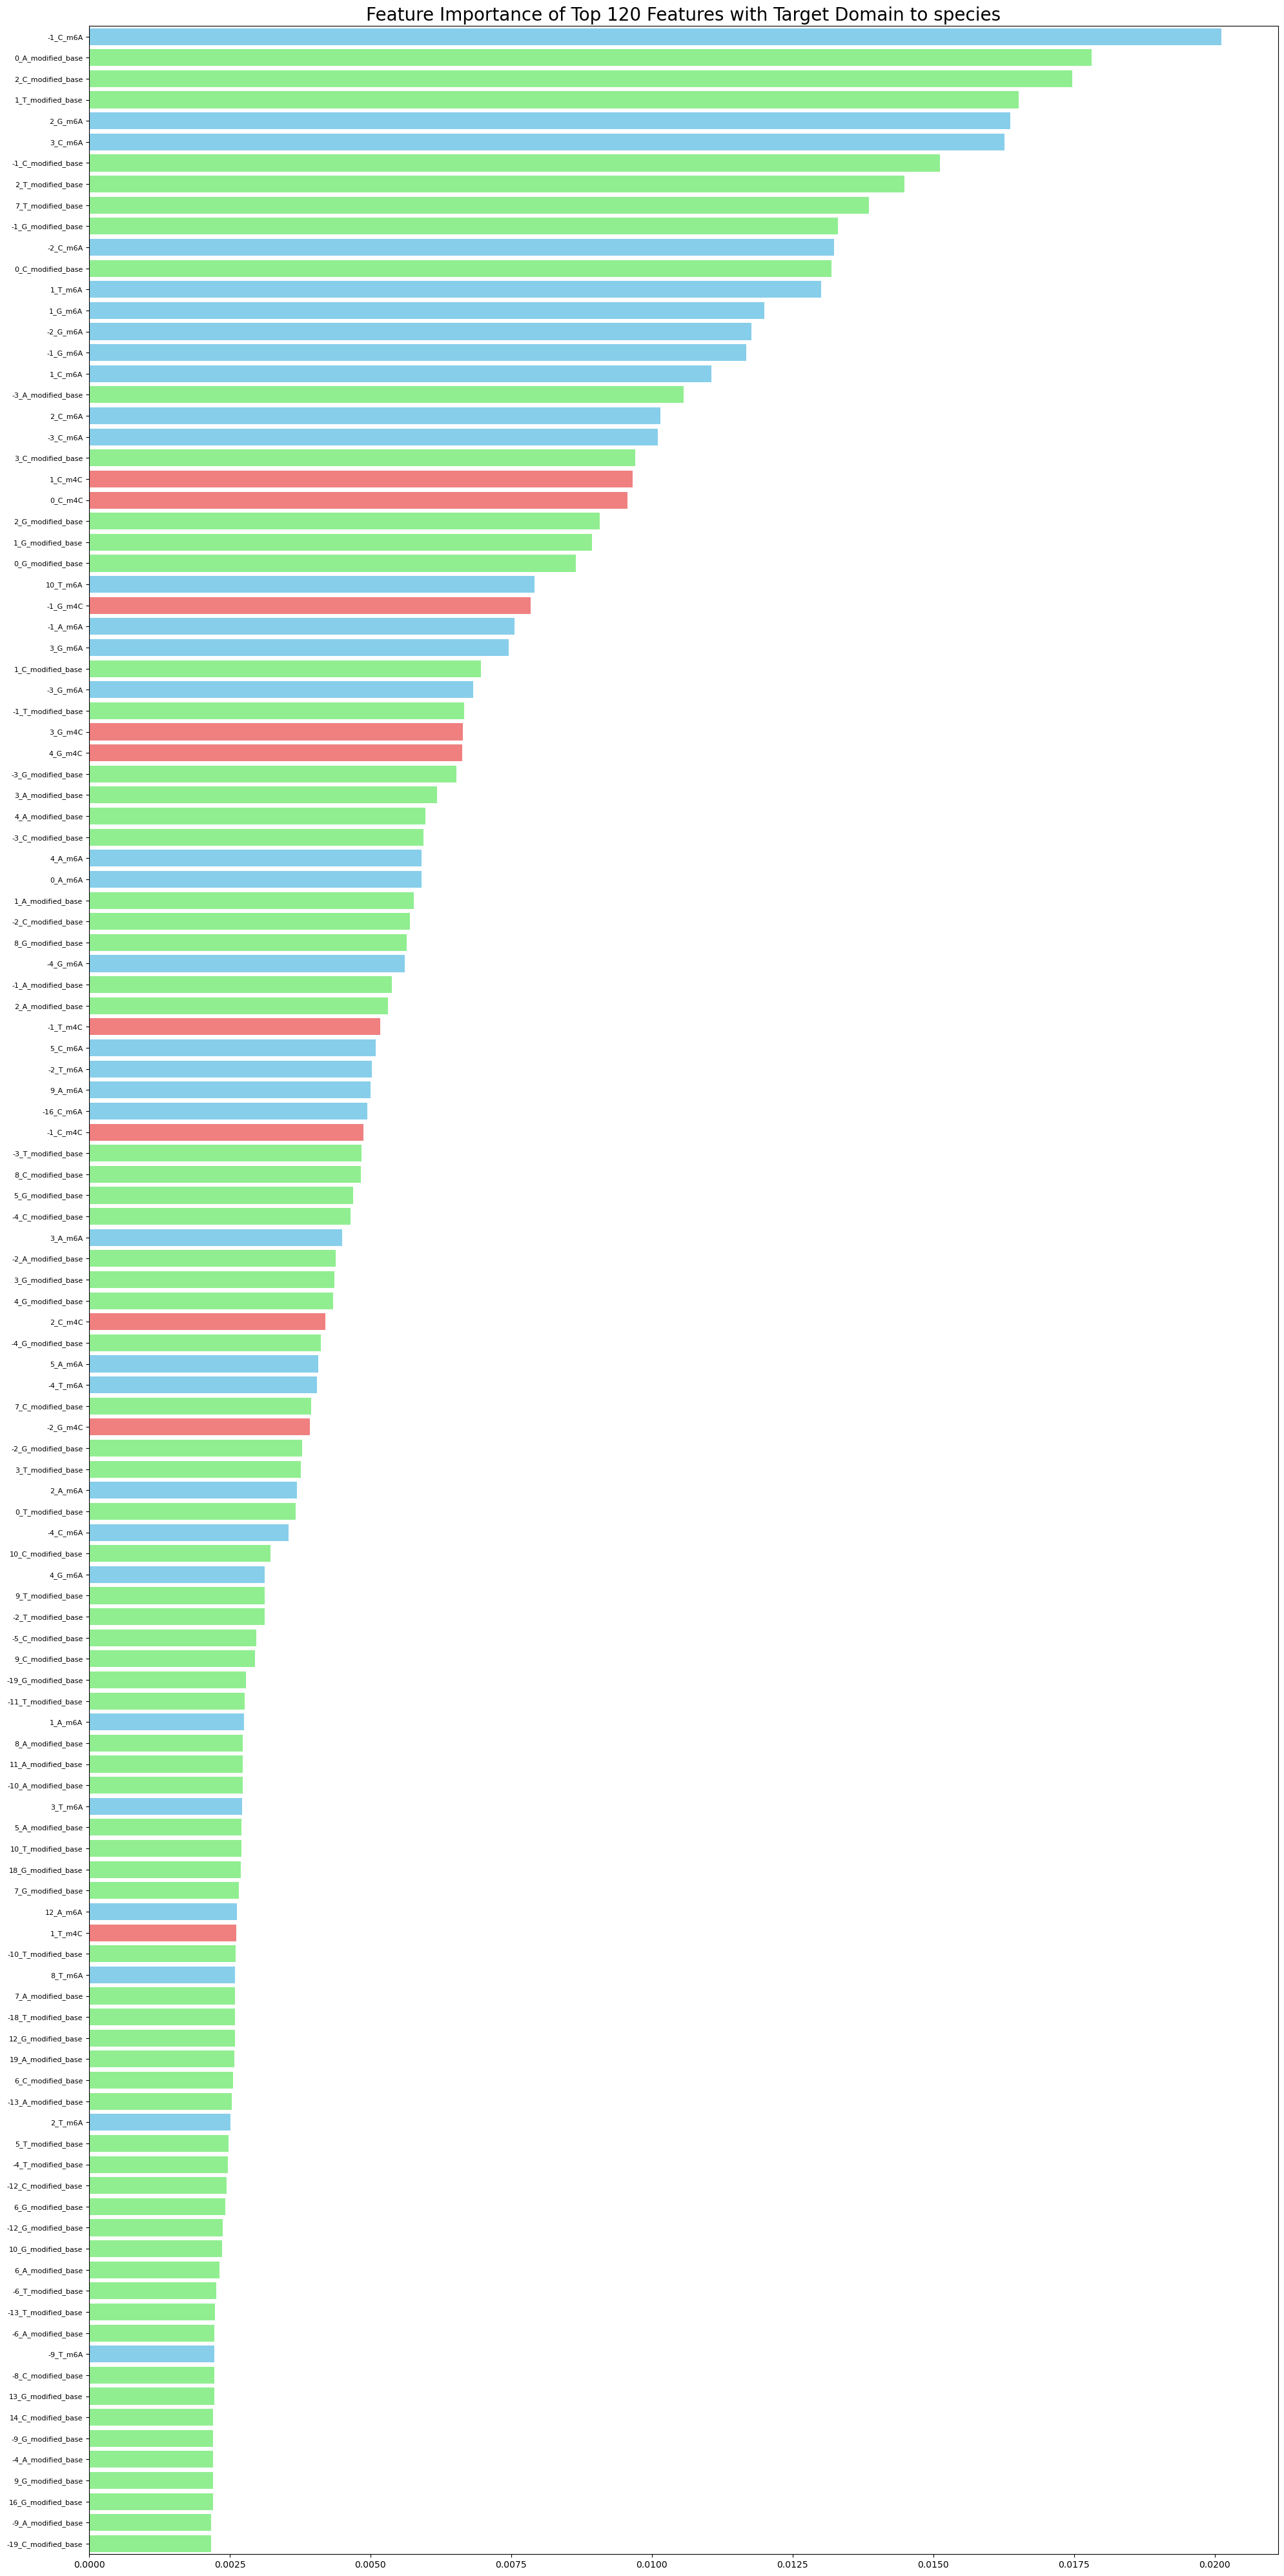

Metrics for target Domain to species with all features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


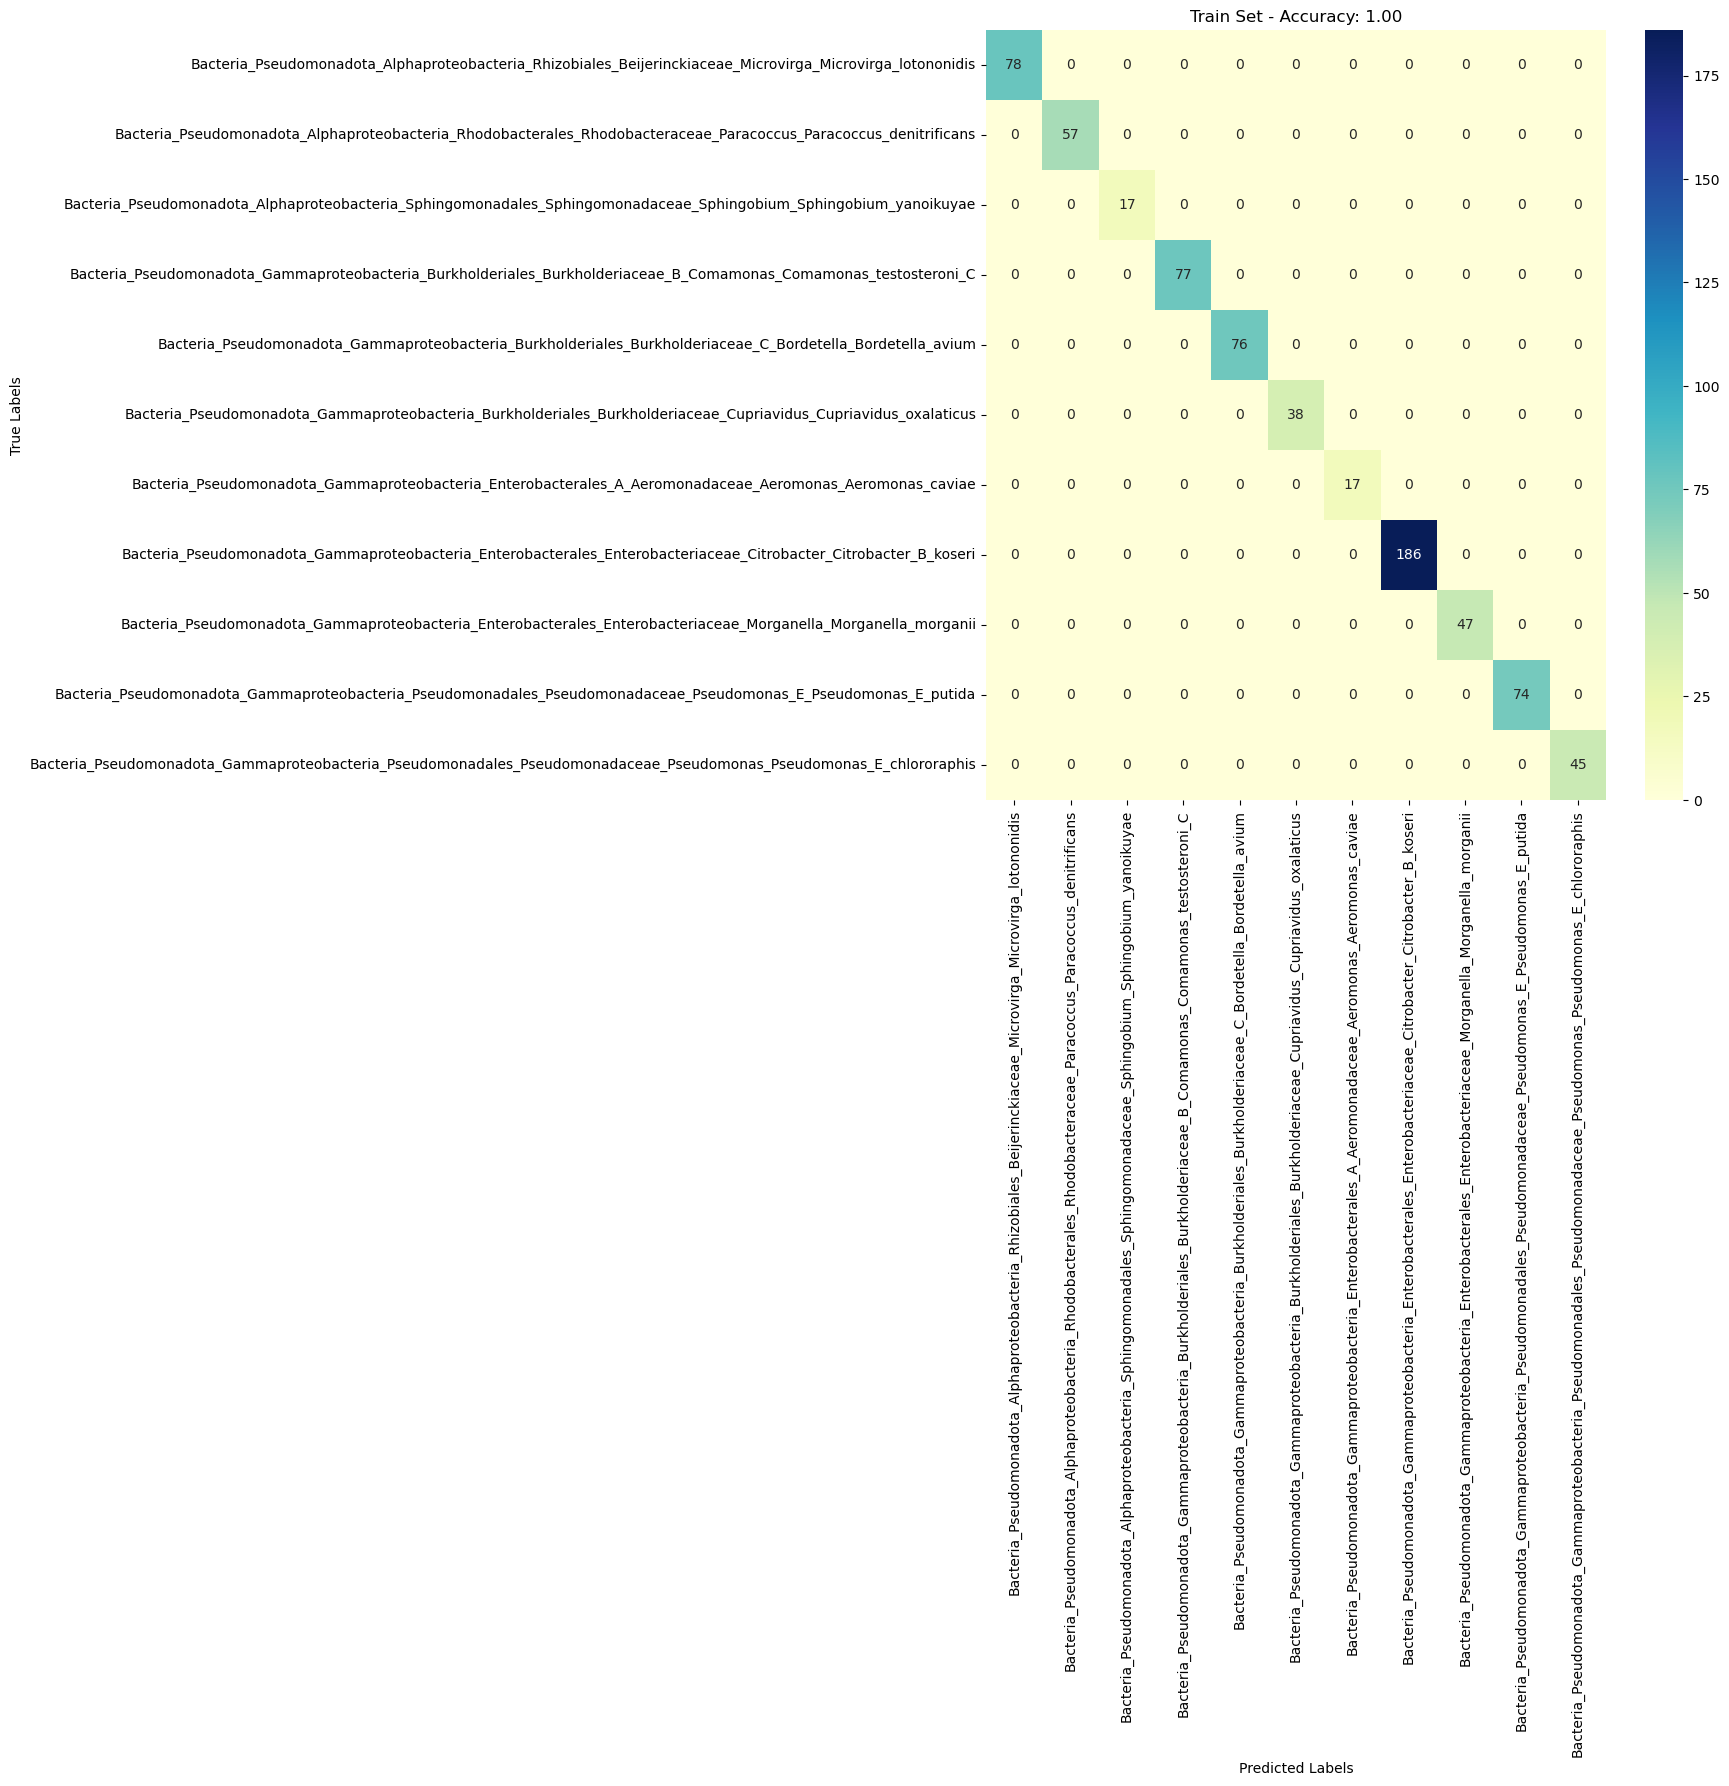

/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


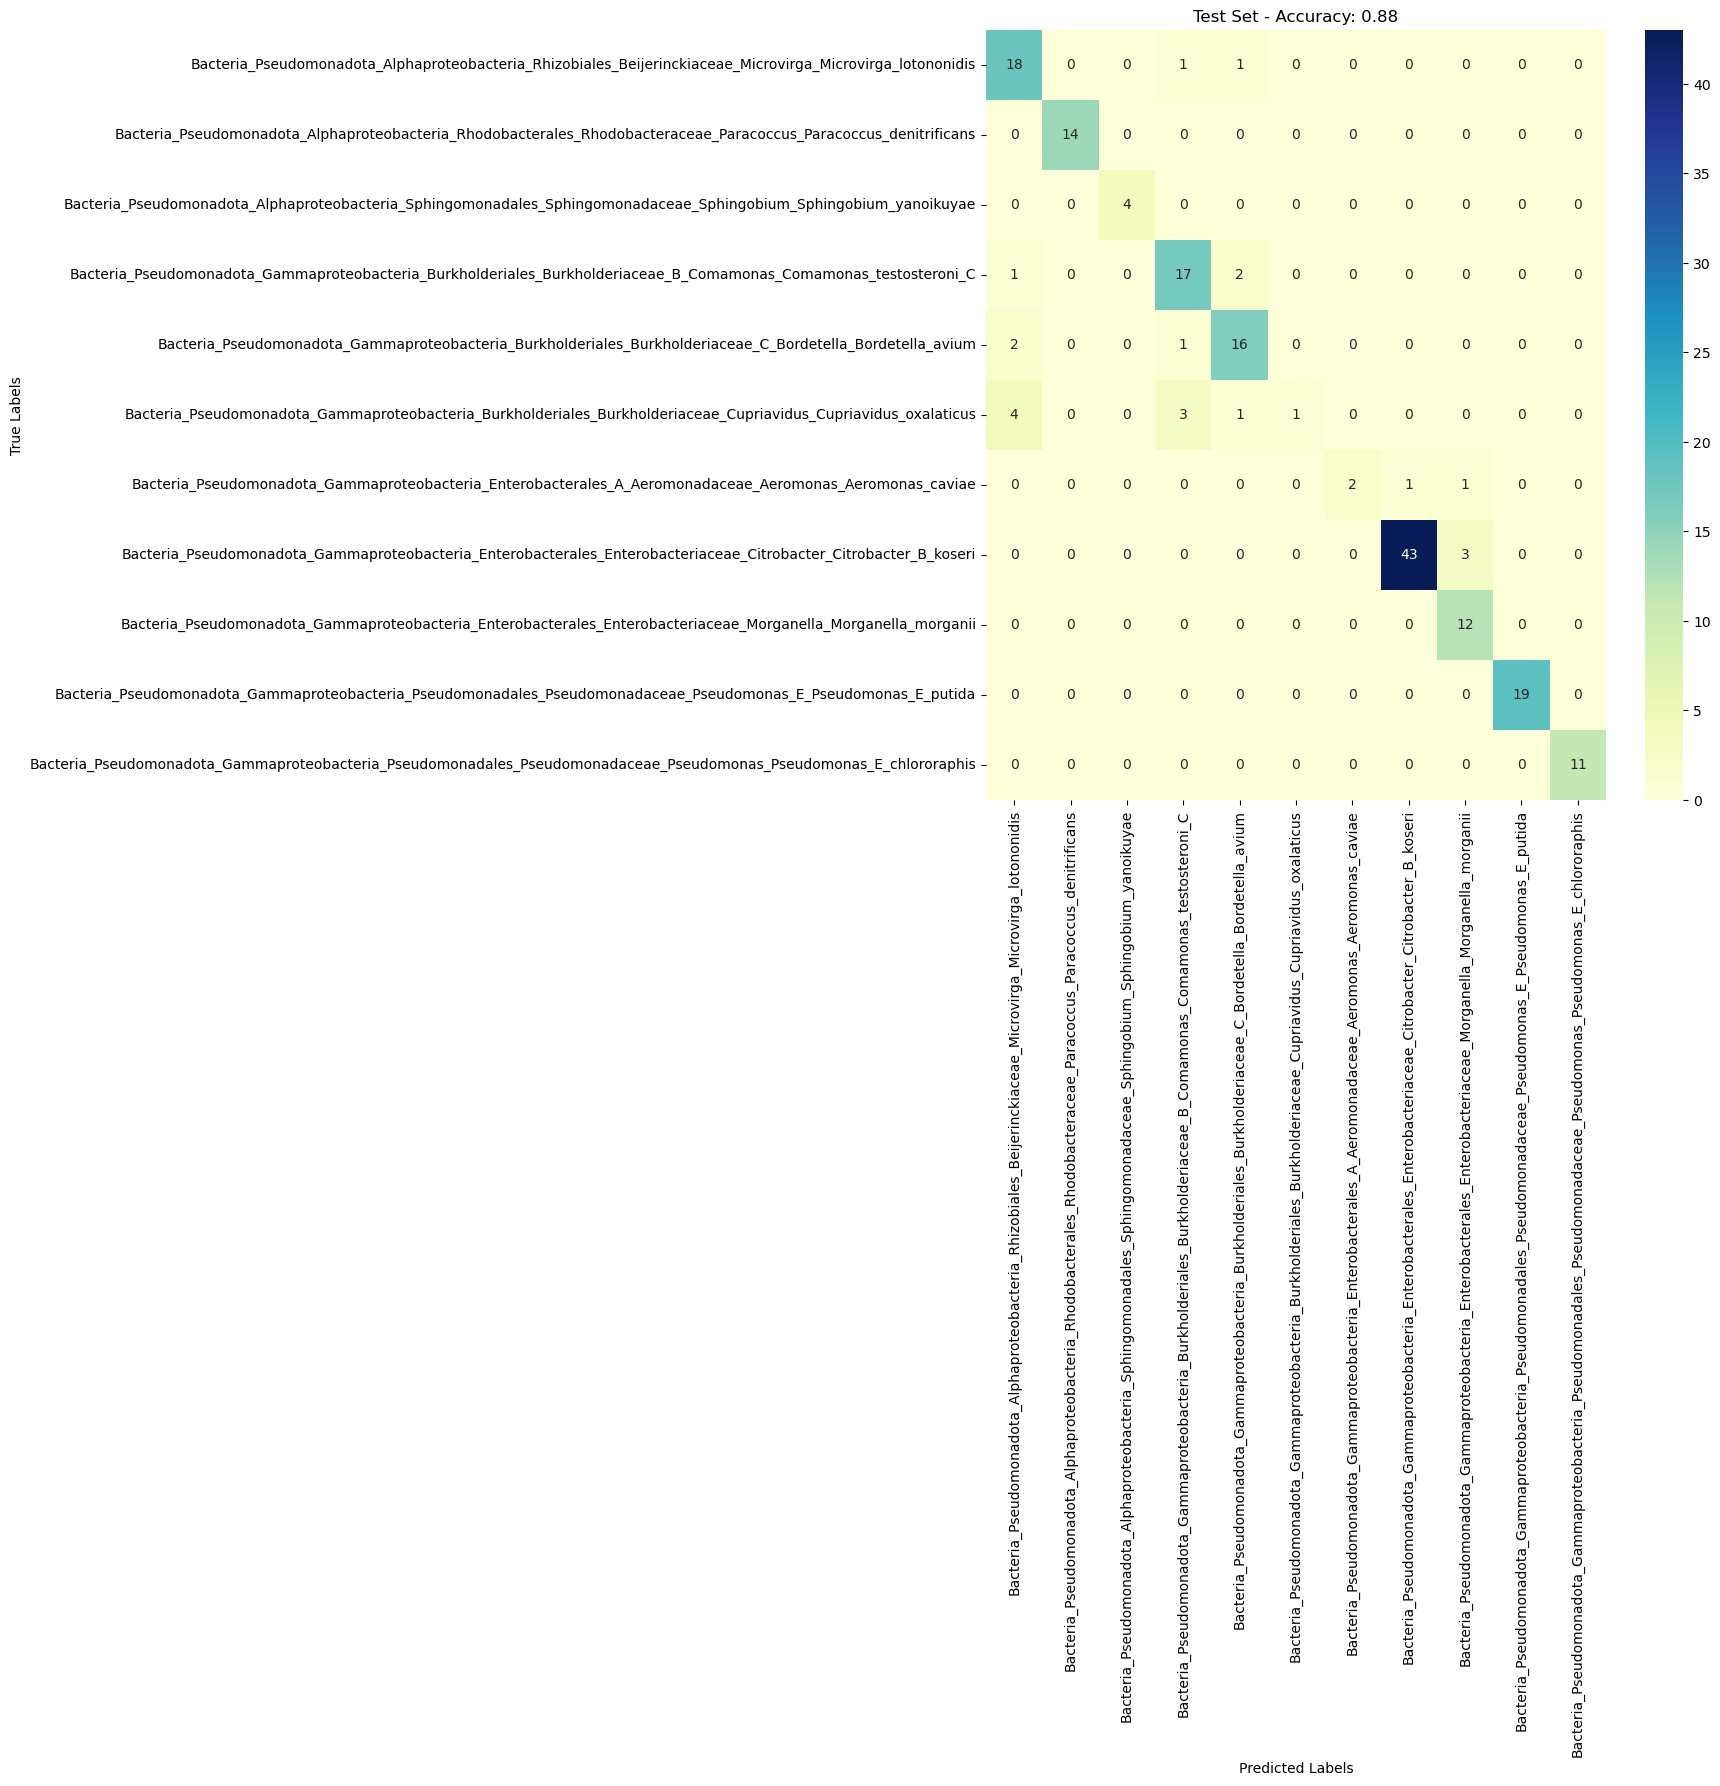

Metrics for target Domain to species with top 120 features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.882022   0.898927  0.882022  0.867911


In [18]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 120)

Training the model with target: Domain to species
Before filtering, number of classes: 15
After filtering, number of classes: 15
Dropped classes: {nan}
Before filtering, number of classes: 15
After filtering, number of classes: 11
Plotting the distribution of train and test sets


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


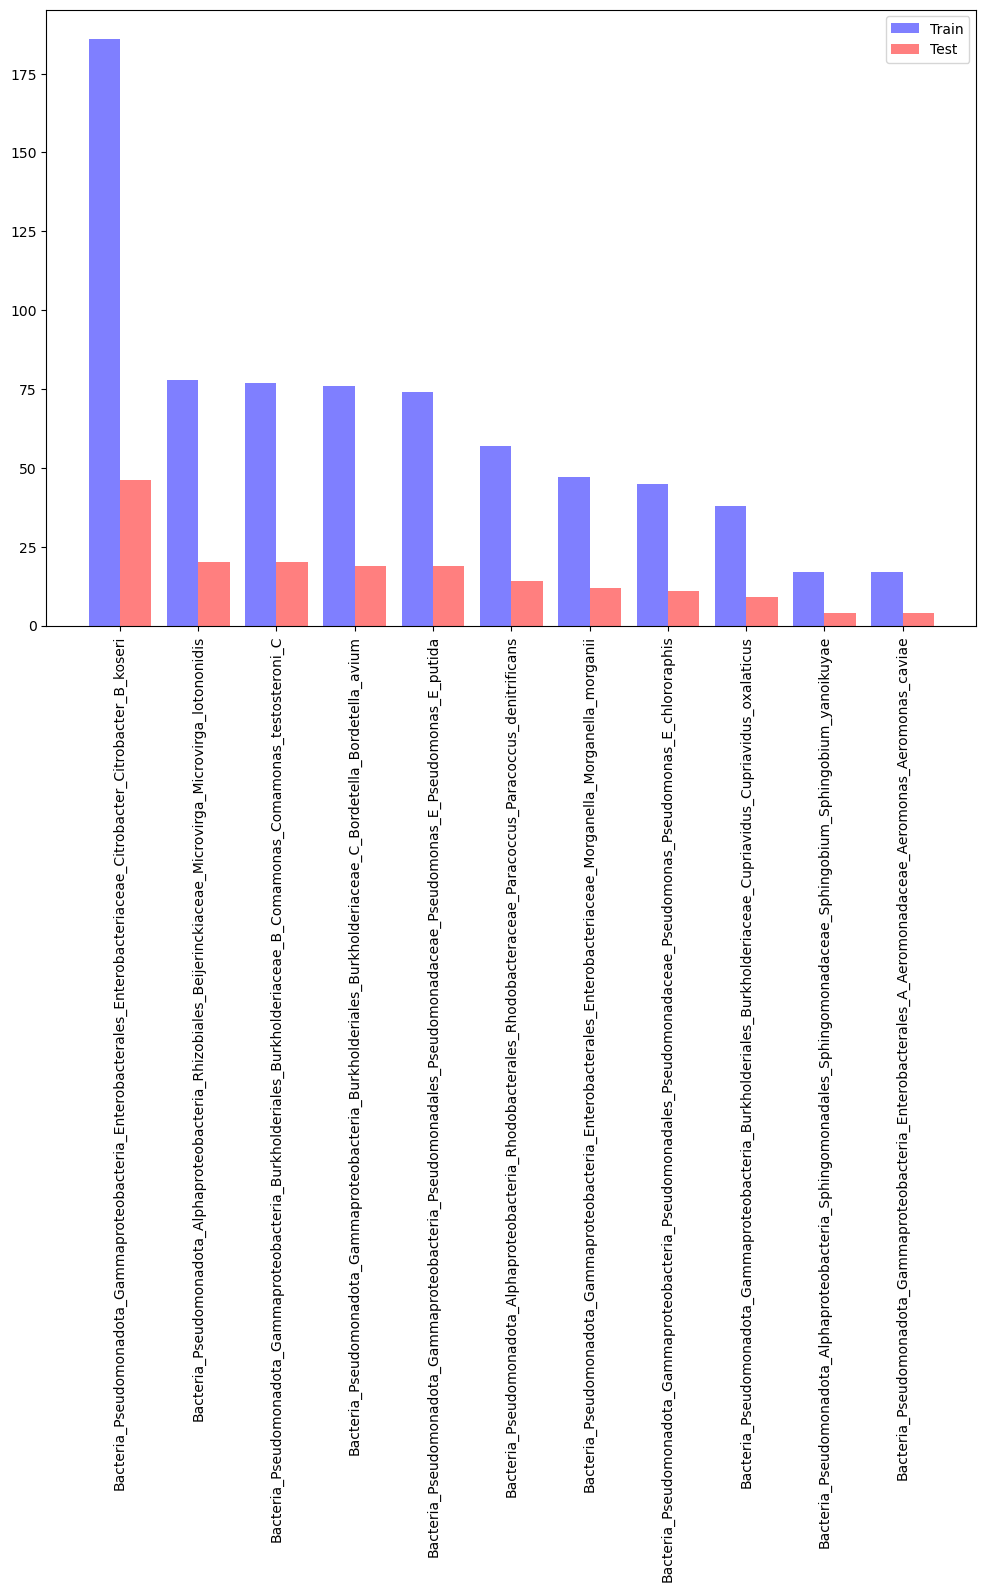

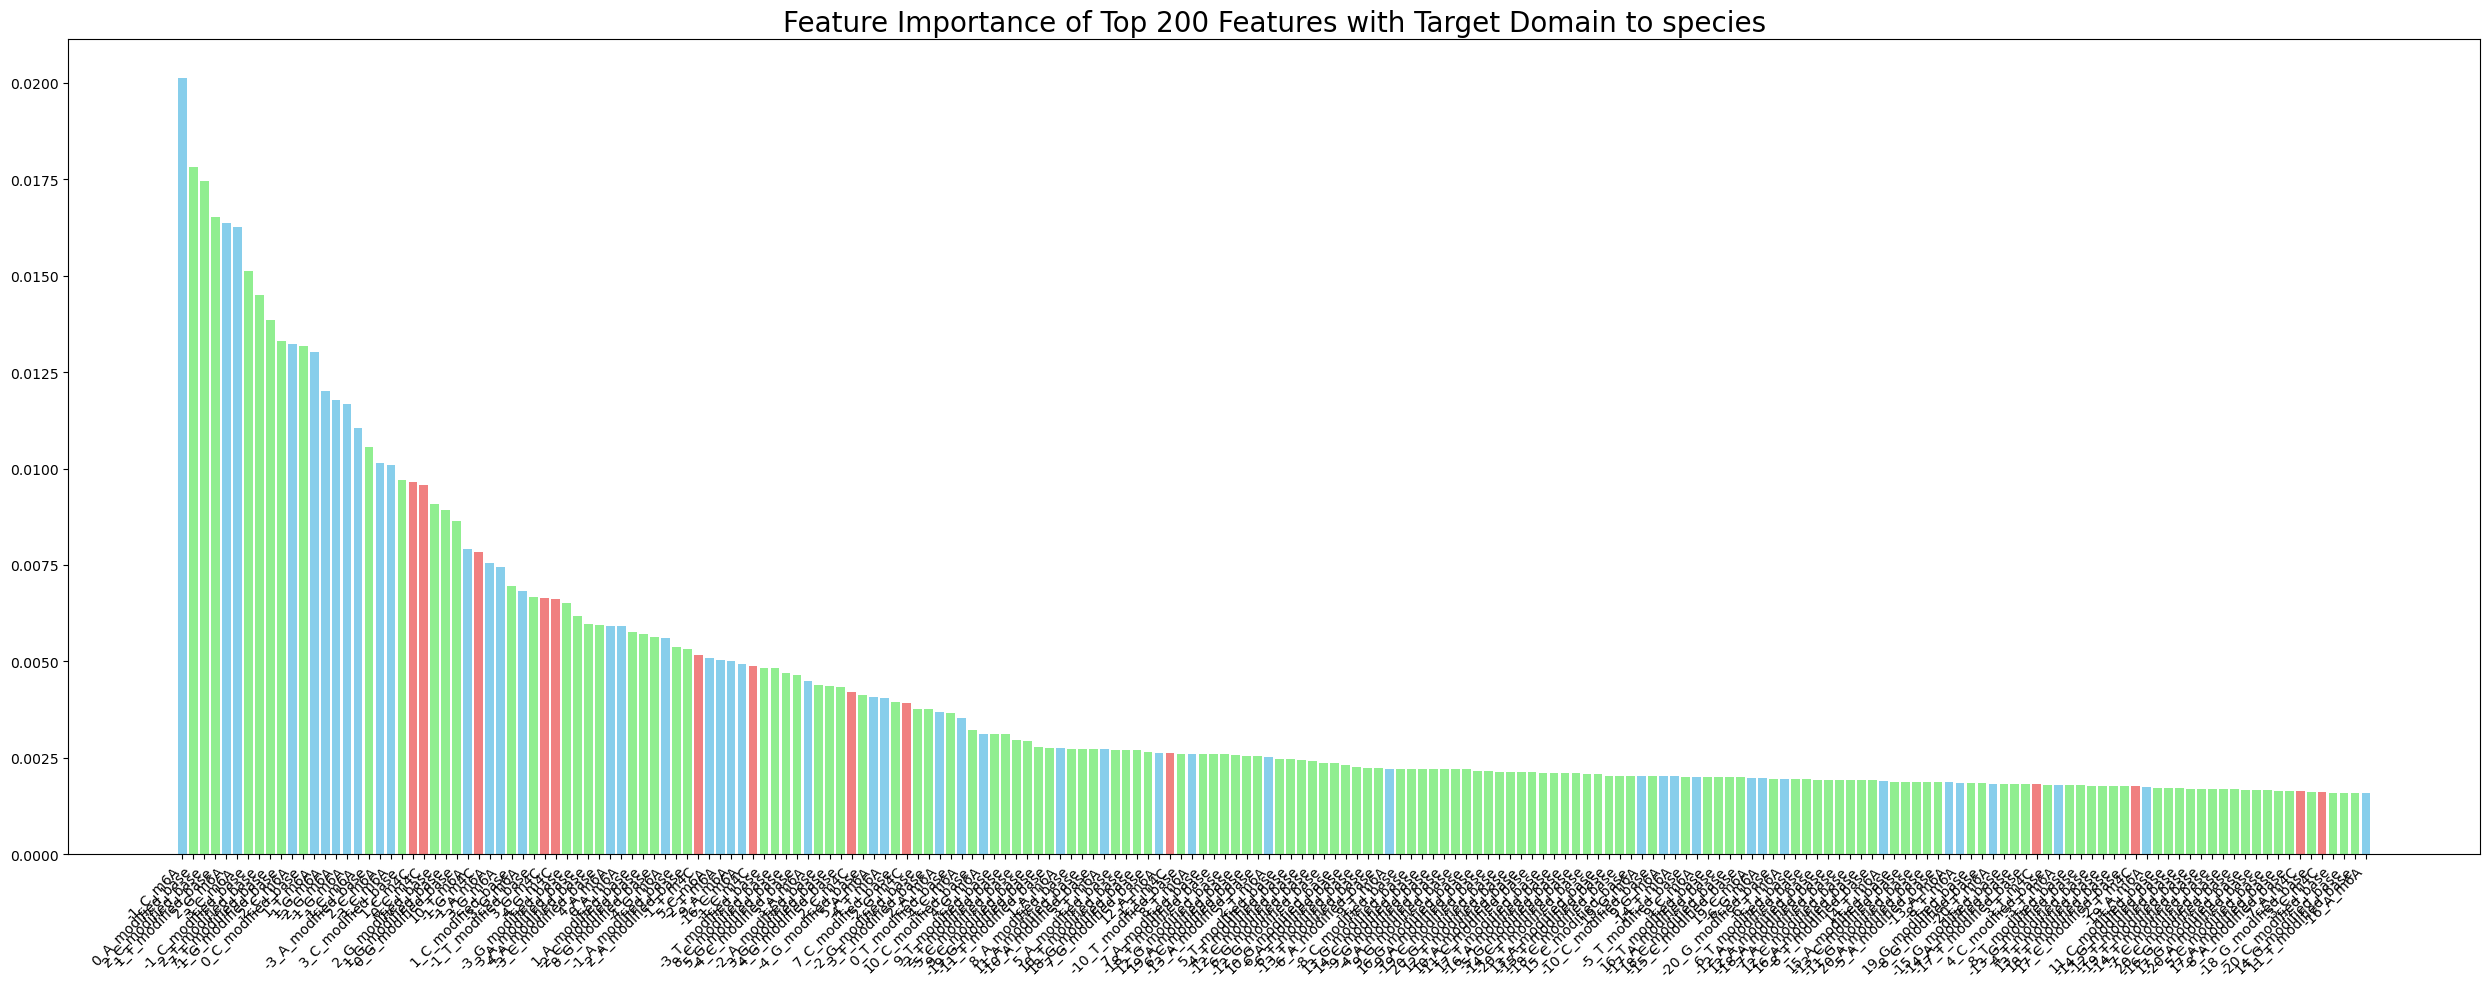

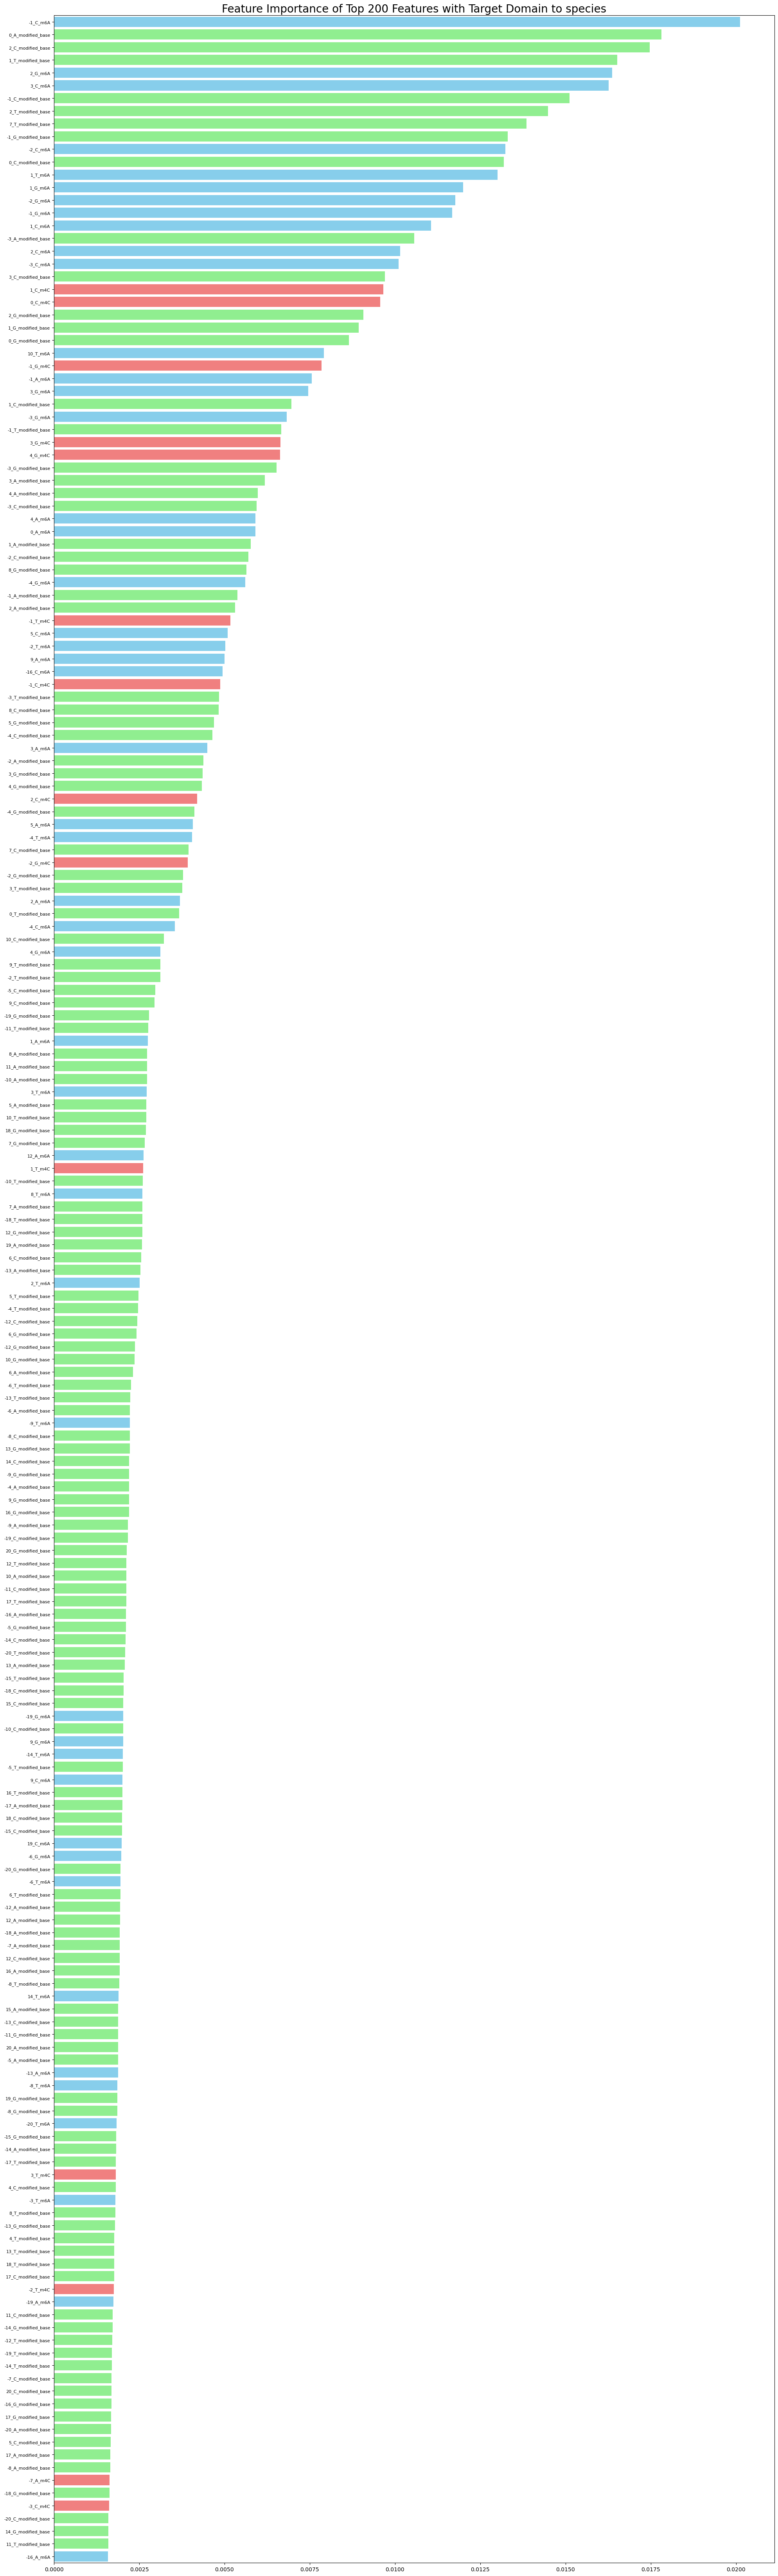

Metrics for target Domain to species with all features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


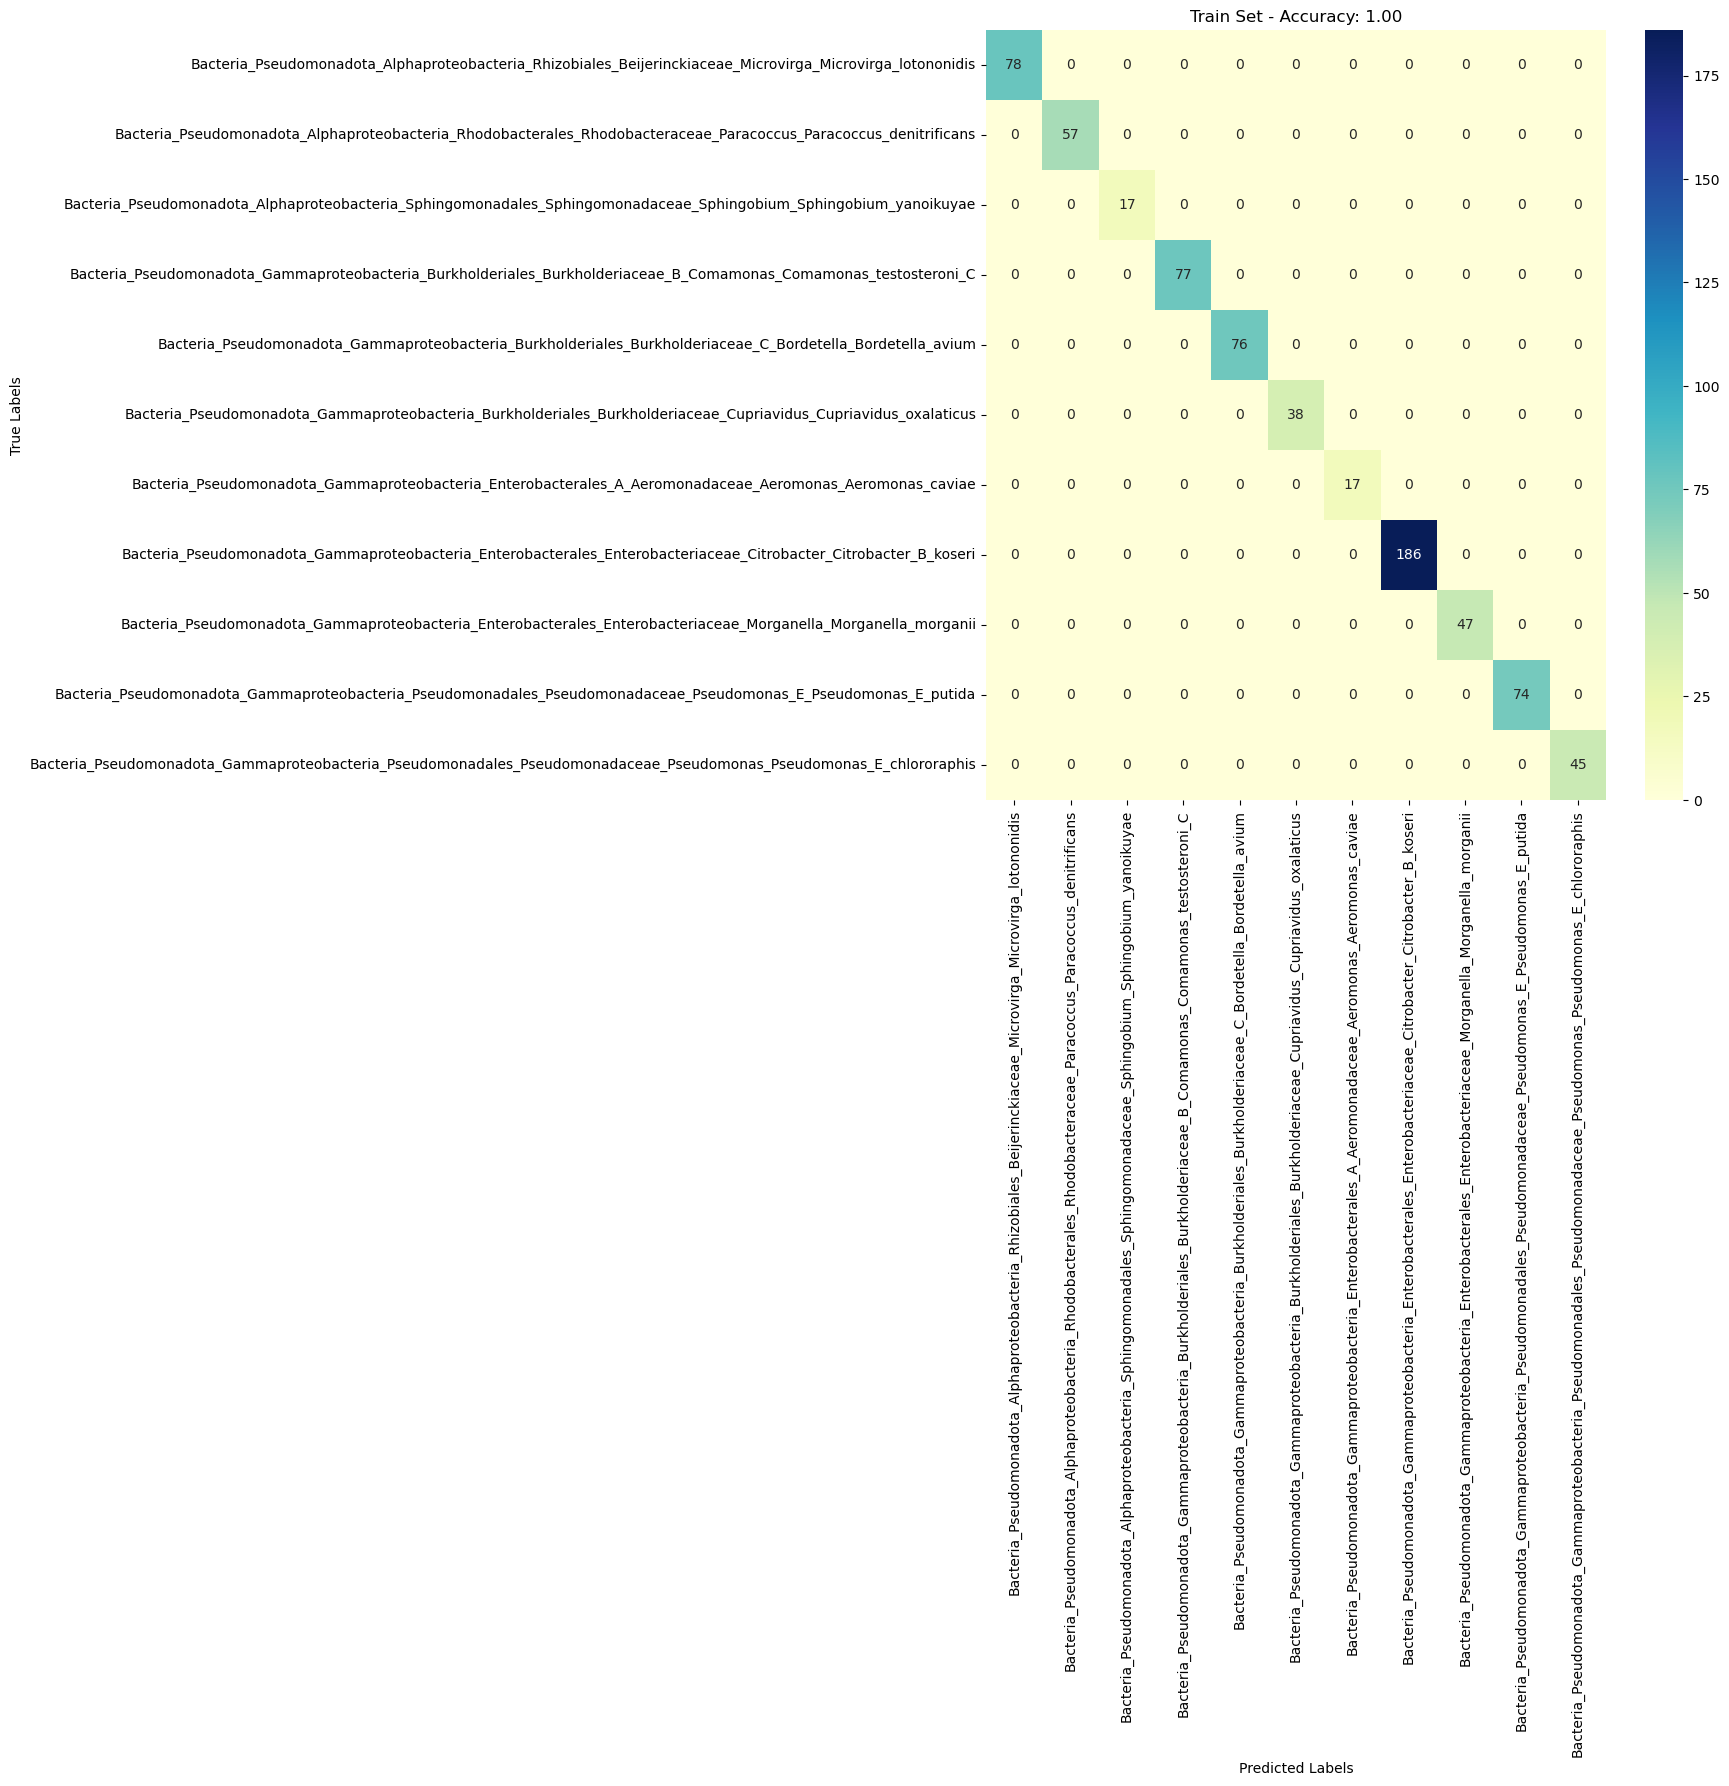

/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


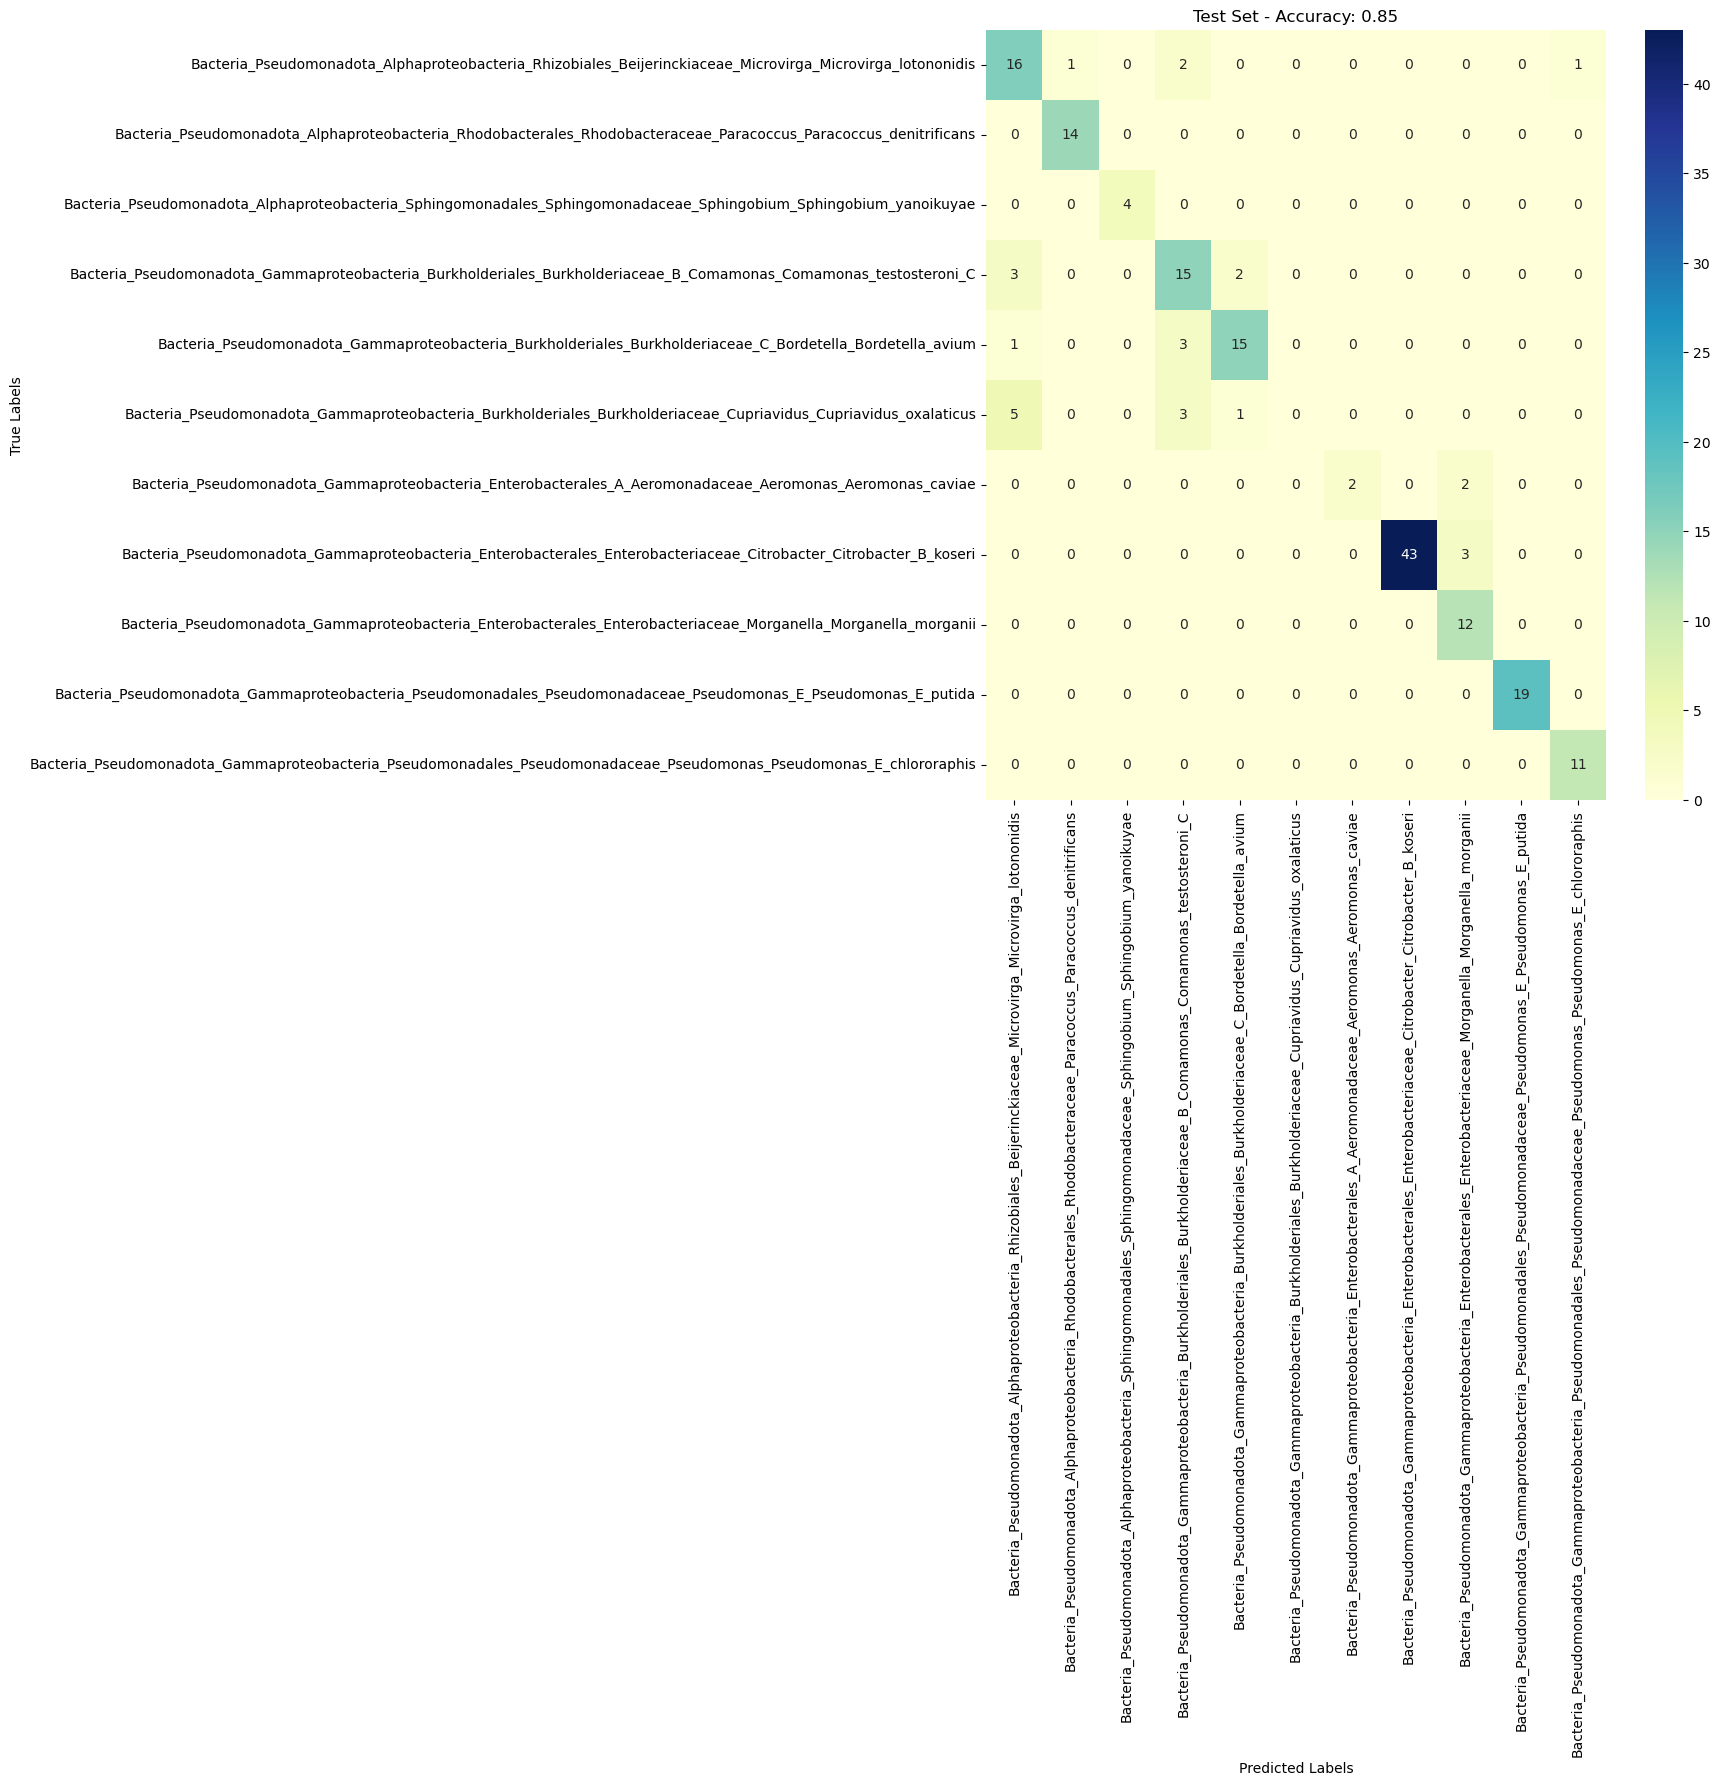

Metrics for target Domain to species with top 200 features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.848315   0.821896  0.848315  0.829591


In [19]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 200)

Training the model with target: Domain to species
Before filtering, number of classes: 15
After filtering, number of classes: 15
Dropped classes: {nan}
Before filtering, number of classes: 15
After filtering, number of classes: 11
Plotting the distribution of train and test sets


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


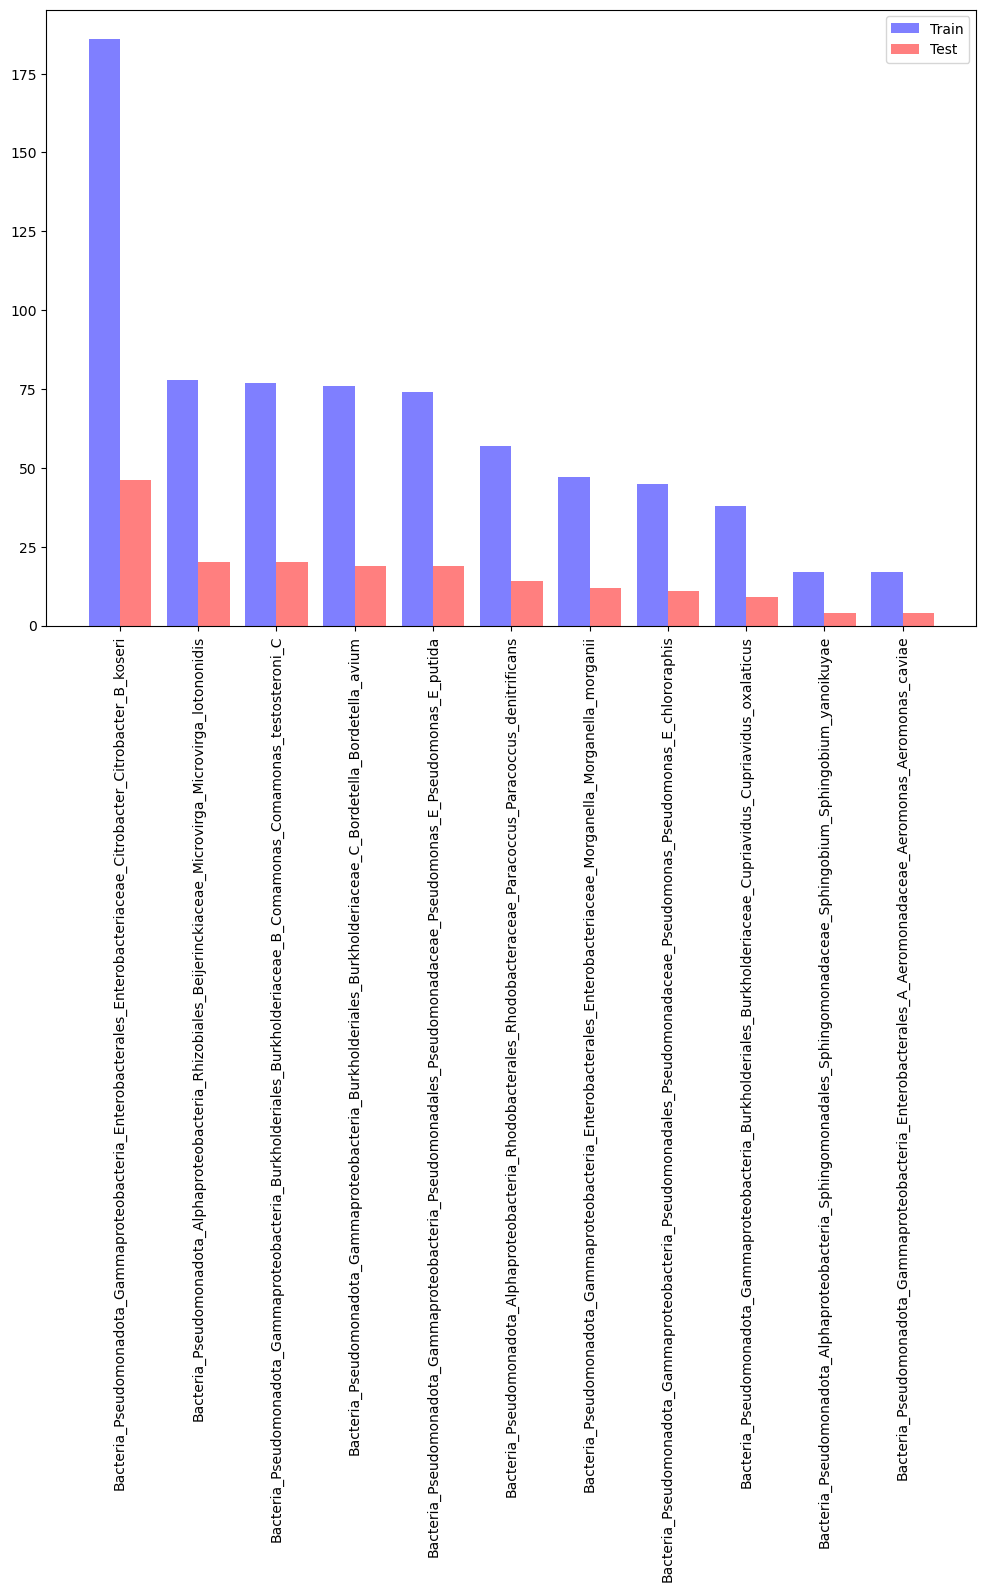

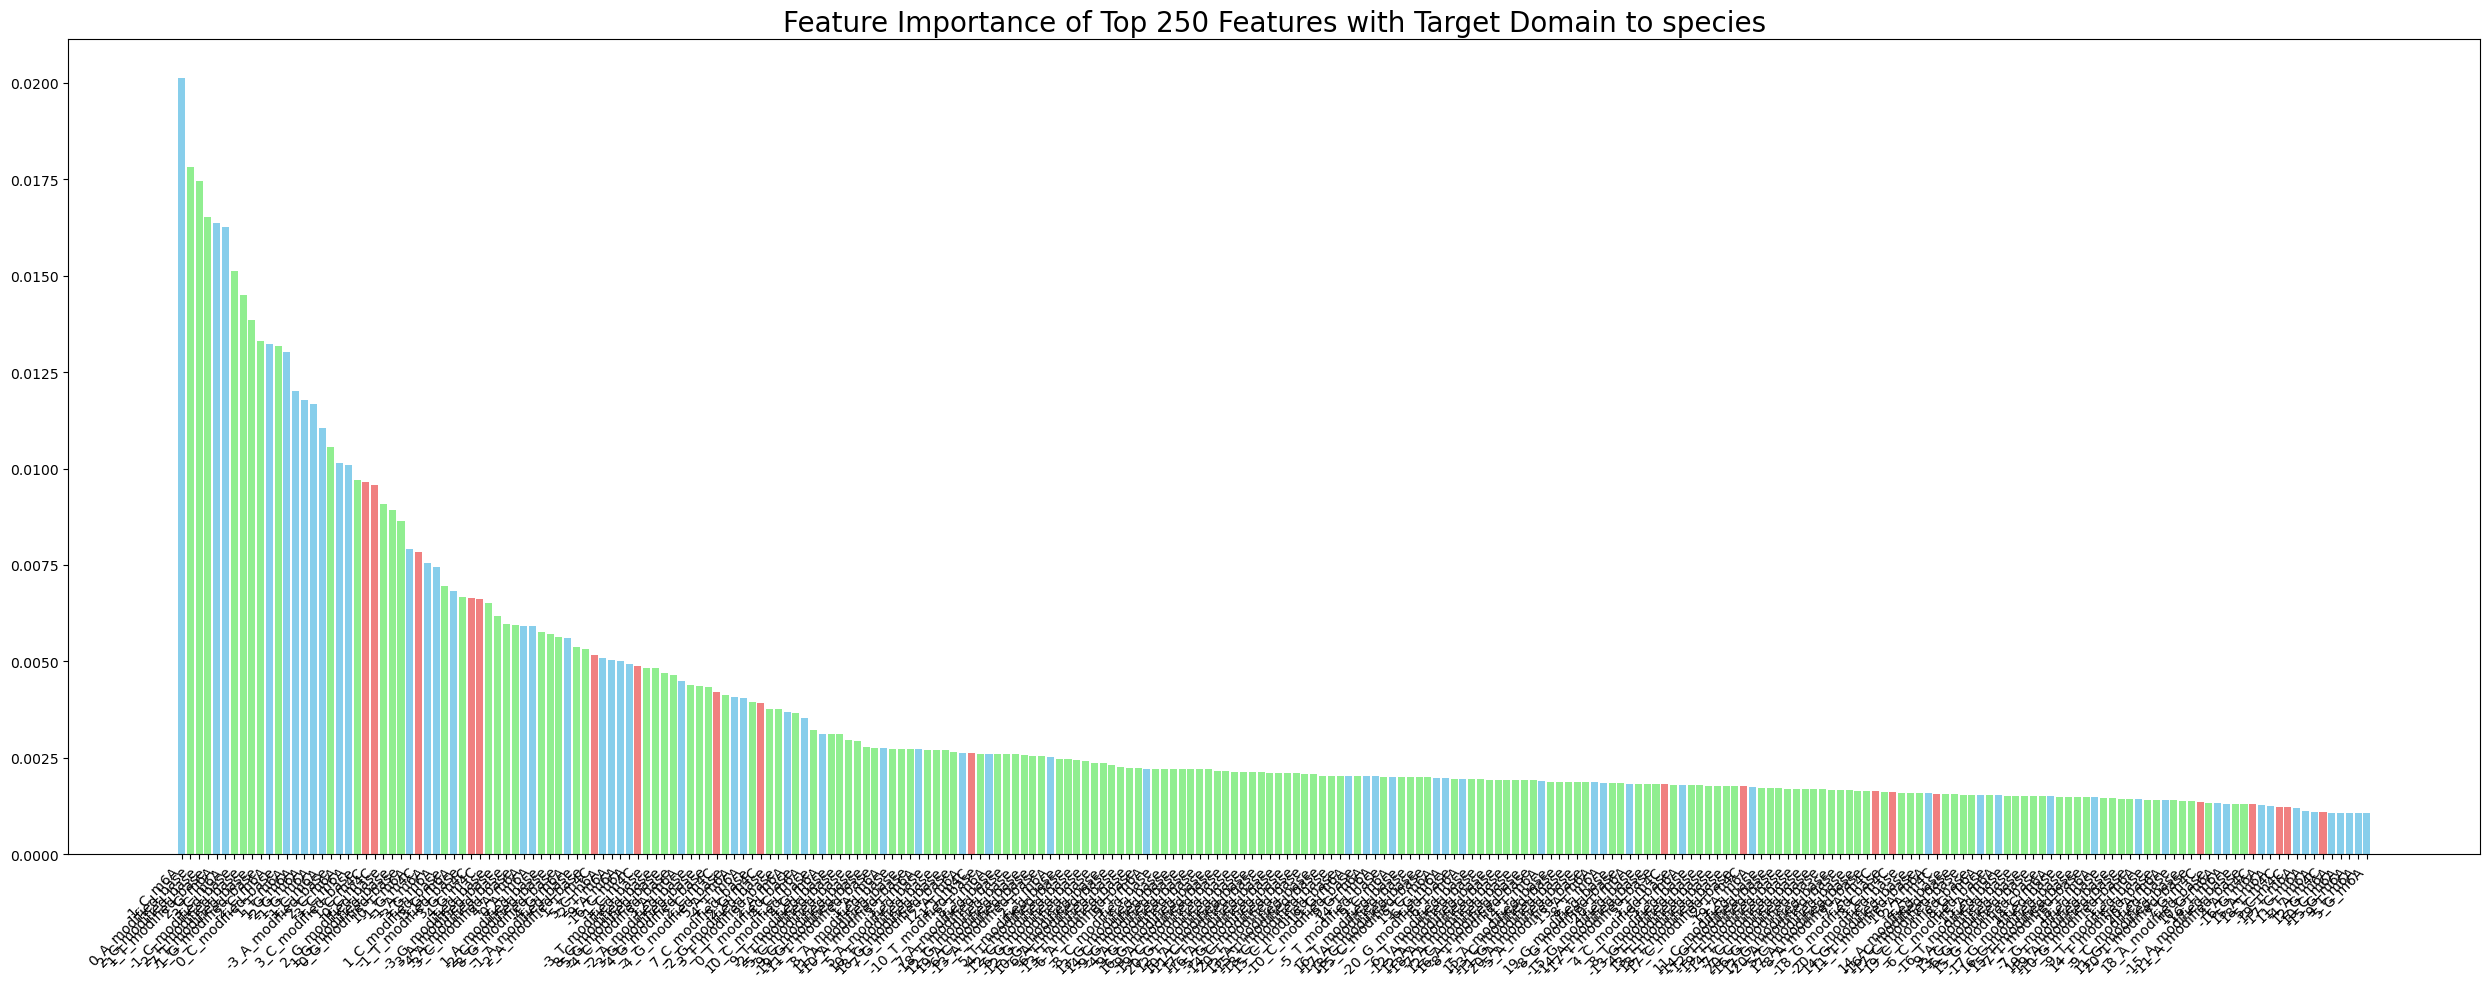

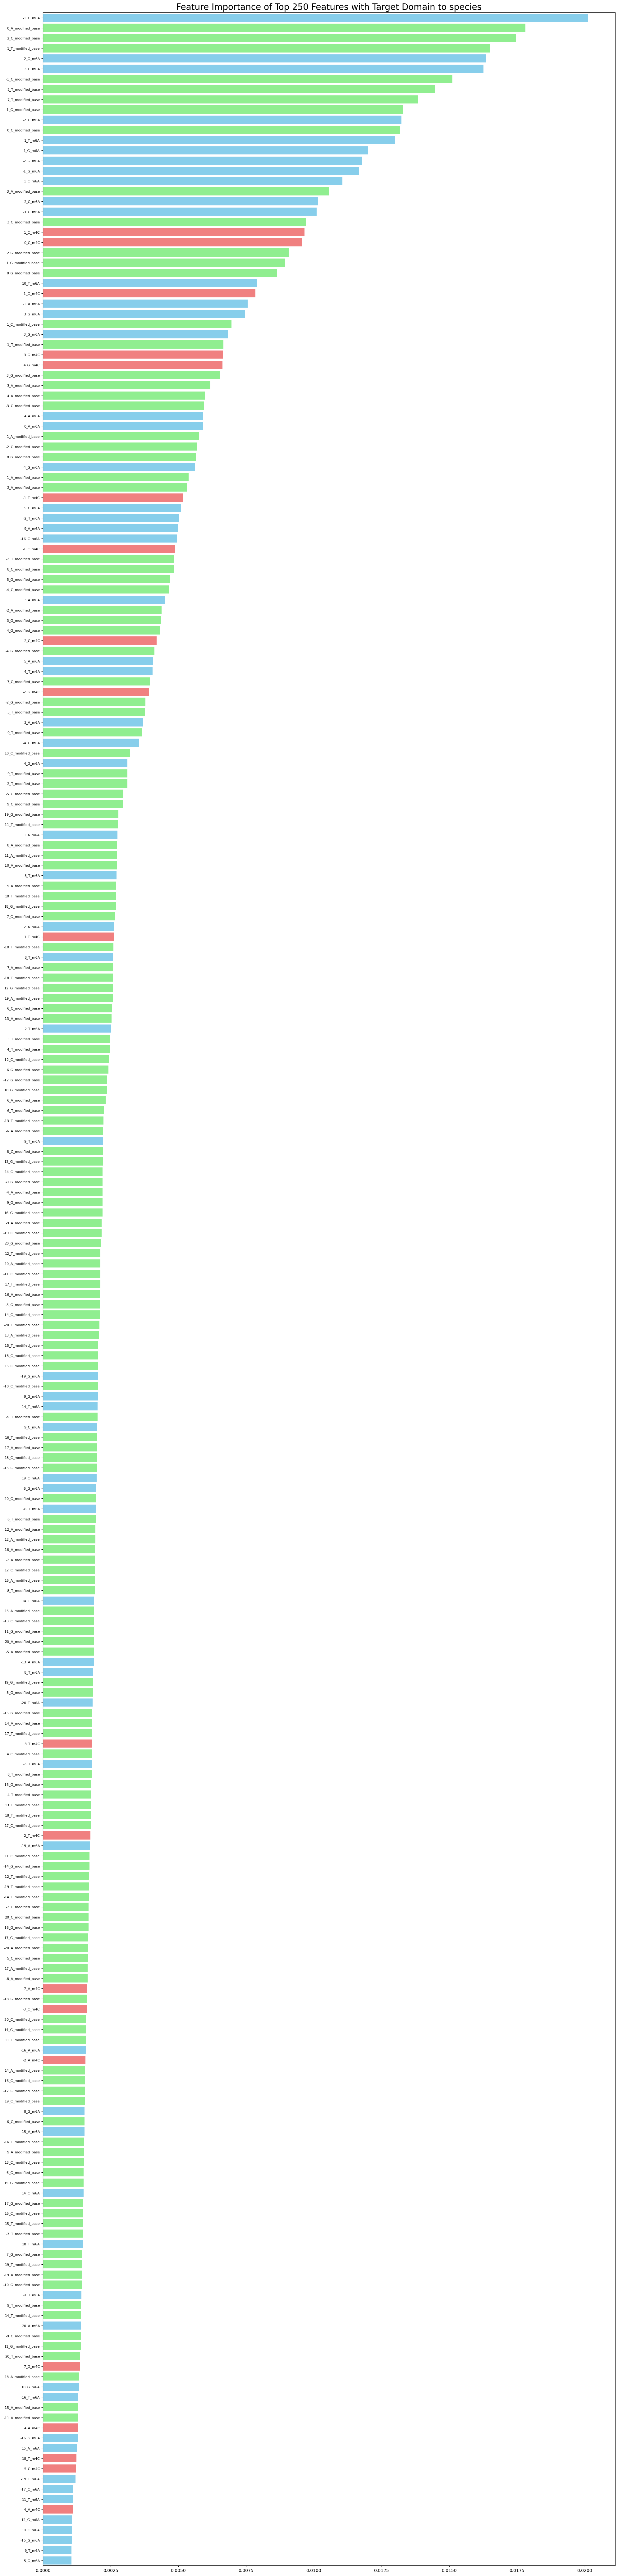

Metrics for target Domain to species with all features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787   0.871968  0.870787  0.859151


/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


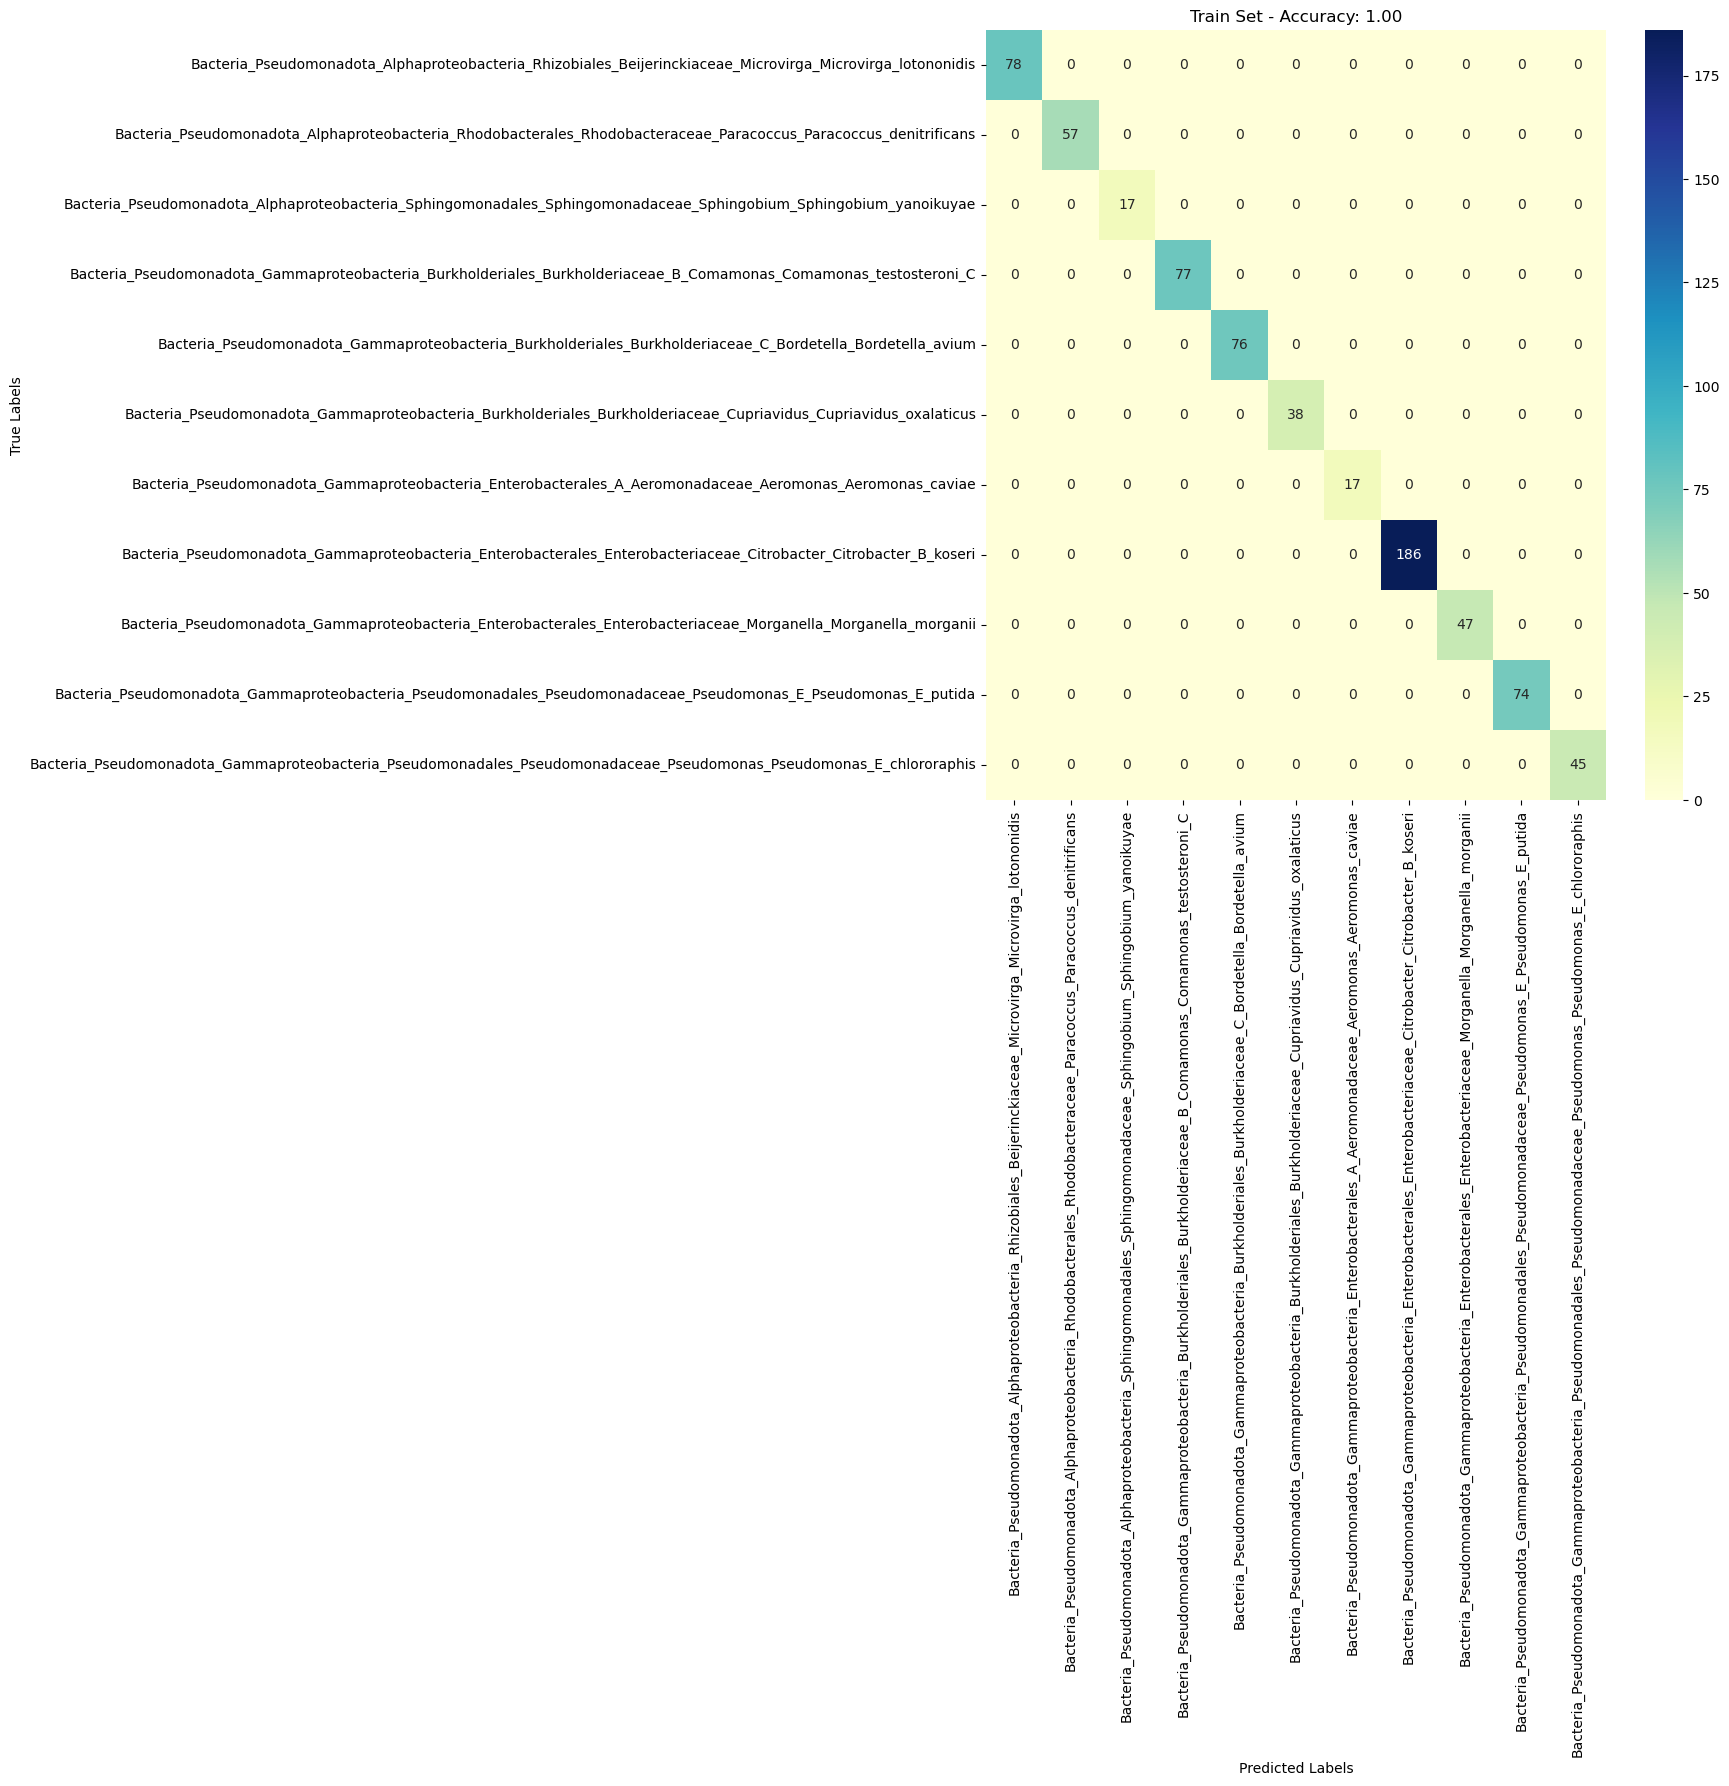

/tmp/markkan5/26831858/ipykernel_3755835/1133593661.py:35: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


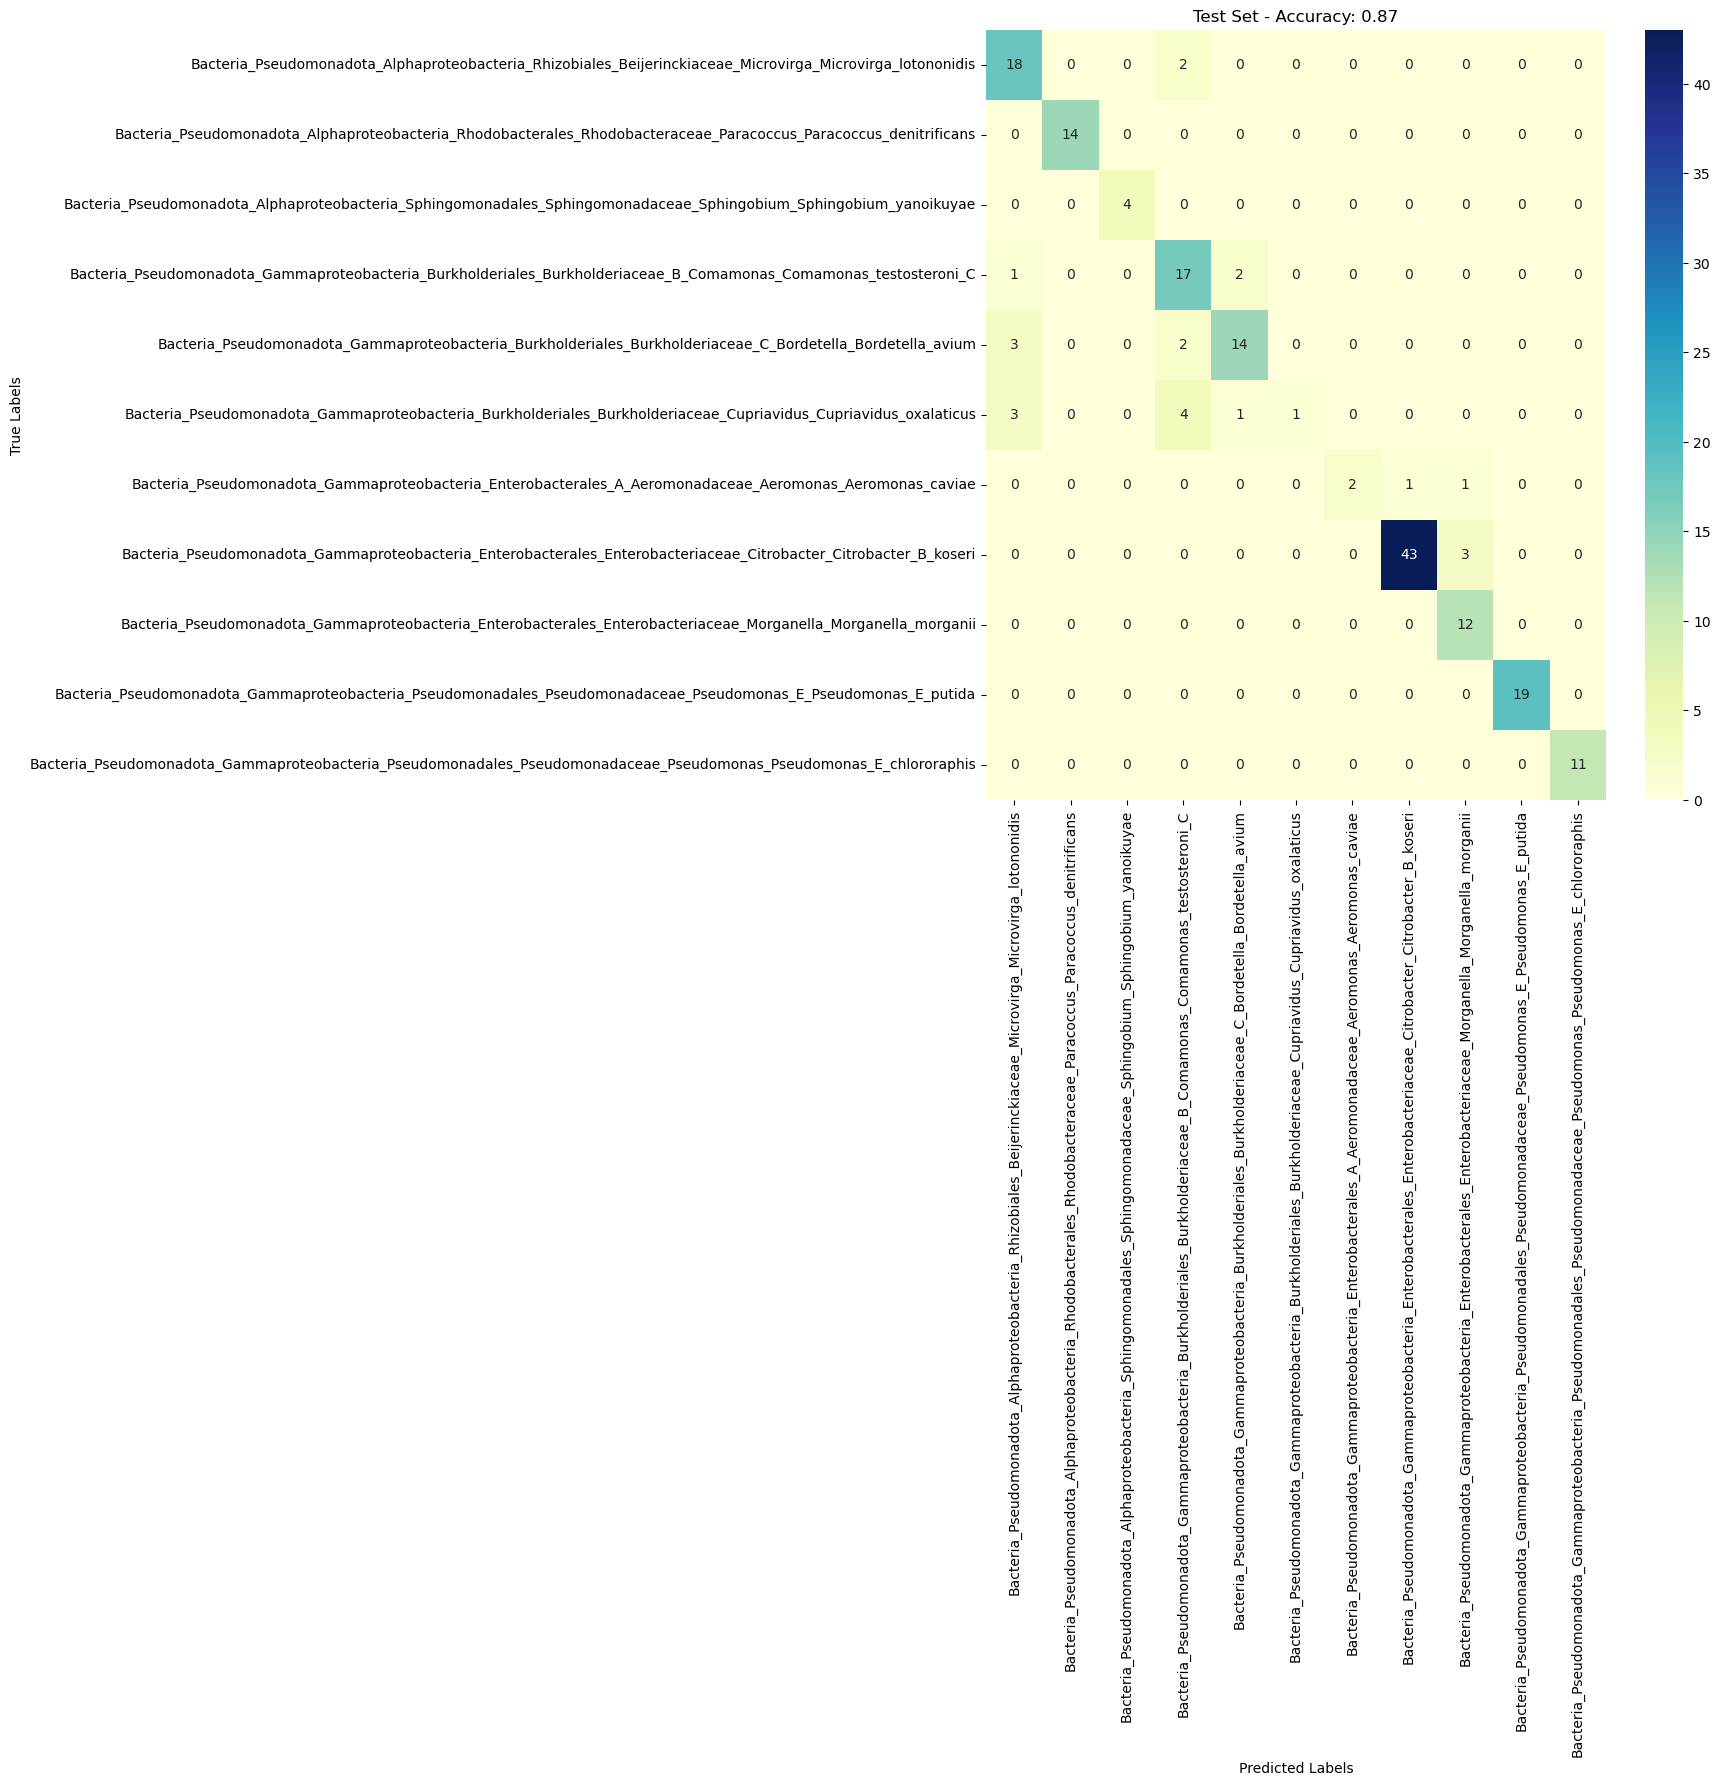

Metrics for target Domain to species with top 250 features
   Accuracy Train  Accuracy Test  Precision    Recall  F1 Score
0             1.0       0.870787    0.89102  0.870787  0.857286


In [20]:
y_test_DS, y_test_pred_DS = train_test_model(data, 'Domain to species', 250)

Using X features yields the best accuracy at the species level test accuracy : Y <br>